In [1]:
import pandas as pd

In [2]:
df = pd.read_excel(r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\base 141 (134).xlsx", dtype={'iin' : str}).rename(columns={
    'school_ru' : 'school',
    'fio' : 'name',
    'dich' : 'answers',
})

## Data processing

In [3]:
df = df.loc[:, ['school', 'grade', 'subject', 'lang', 'lang_test', 'iin', 'answers', 'score']]

In [4]:
# Removing whitespaces
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [5]:
df['subject'] = df['subject'].str[2:].apply(lambda x: x[:-1] if ('1' in x or '2' in x) else x)

In [6]:
df['lang_test'].unique()

array([1, 3, 2], dtype=int64)

In [7]:
lang_map = {
    1 : 'Казахский',
    2 : 'Русский',
    3 : 'Английский'
}
df['lang'] = df['lang'].map(lang_map)
df['lang_test'] = df['lang_test'].map(lang_map)

In [8]:
subject_map = {
    'SCIE' : 'Естествознание и познание мира', 
    'PHYS' : 'Физика', 
    'ENFL' : 'Английский язык', 
    'MATH' : 'Математика', 
    'BIOL' : 'Биология', 
    'CHEM' : 'Химия'
}
df['subject'] = df['subject'].map(subject_map)

In [9]:
df.isna().values.any()

False

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11342 entries, 0 to 11341
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school     11342 non-null  object
 1   grade      11342 non-null  int64 
 2   subject    11342 non-null  object
 3   lang       11342 non-null  object
 4   lang_test  11342 non-null  object
 5   iin        11342 non-null  object
 6   answers    11342 non-null  object
 7   score      11342 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 709.0+ KB


* sub check

In [11]:
subject_check = df[df['lang'] != df['lang_test']]['subject'].unique()
subject_check

array(['Английский язык'], dtype=object)

* lang check

In [12]:
lang_check = df[['iin', 'lang', 'lang_test']].assign(iin_number = lambda x: x.groupby('iin').ngroup()).sort_values(by='iin_number')
lang_check

,iin,lang,lang_test,iin_number
5589,009609552260,Казахский,Казахский,0
6462,009609552260,Казахский,Английский,0
227,009609552260,Казахский,Казахский,0
380,009609552260,Казахский,Казахский,0
1047,009609552260,Казахский,Казахский,0
...,...,...,...,...
4460,130306504747,Казахский,Казахский,2761
3189,130306504747,Казахский,Английский,2761
1712,160130503610,Казахский,Казахский,2762
4461,160130503610,Казахский,Казахский,2762


In [13]:
# Checking for iins with different language of study
iins = {}
diff_lang = set()
for iin, lang in zip(lang_check['iin'], lang_check['lang']):
    if not iin in iins:
        iins[iin] = lang
    else:
        if not iins[iin] == lang:
            diff_lang.add(iin)
print(diff_lang)

set()


## Calculations

In [14]:
df['percent'] = df.apply(lambda row: row['score'] / 20 * 100, axis=1)

Contingent

In [15]:
total_participants = df['iin'].nunique()
print(f"Total number of participants: {total_participants}")

Total number of participants: 2763


In [16]:
grade_participants = df.groupby(['grade'])['iin'].nunique().reset_index()
display(grade_participants)
print(sum(grade_participants['iin']))

,grade,iin
0,6,1126
1,8,1038
2,10,599


2763


In [17]:
subject_participants = df.groupby(['grade', 'subject'])['iin'].nunique().reset_index()
subject_participants.head(3)

,grade,subject,iin
0,6,Английский язык,1117
1,6,Естествознание и познание мира,1124
2,6,Математика,1124


In [18]:
lang_participants = df.groupby(['grade', 'subject', 'lang'])['iin'].nunique().reset_index()
lang_participants.head(3)

,grade,subject,lang,iin
0,6,Английский язык,Казахский,1001
1,6,Английский язык,Русский,116
2,6,Естествознание и познание мира,Казахский,1005


In [19]:
cont_merged = pd.merge(pd.merge(lang_participants, subject_participants, on=['grade', 'subject'], suffixes=('', '_subject')), grade_participants, on='grade', suffixes=('', '_grade'))
cont_merged = cont_merged.assign(iin_total = total_participants)
cont_merged.head(5)

,grade,subject,lang,iin,iin_subject,iin_grade,iin_total
0,6,Английский язык,Казахский,1001,1117,1126,2763
1,6,Английский язык,Русский,116,1117,1126,2763
2,6,Естествознание и познание мира,Казахский,1005,1124,1126,2763
3,6,Естествознание и познание мира,Русский,119,1124,1126,2763
4,6,Математика,Казахский,1005,1124,1126,2763


In [20]:
# suffix_dict = {'iin_subject' : '_subject', 'iin_grade' : '_grade', 'iin_total' : '_total'}
# for index in range(len(cont_merged.columns)-1):
#     column = cont_merged.columns[index]
#     next_column = cont_merged.columns[index+1]
#     if column in suffix_dict:
#         cont_merged[f"percent{suffix_dict[column]}"] = cont_merged.apply(lambda x: x[column] / x[next_column] * 100, axis=1).round(1)             
#         # print(cont_merged.columns[index])

In [21]:
cont_merged

,grade,subject,lang,iin,iin_subject,iin_grade,iin_total
0,6,Английский язык,Казахский,1001,1117,1126,2763
1,6,Английский язык,Русский,116,1117,1126,2763
2,6,Естествознание и познание мира,Казахский,1005,1124,1126,2763
3,6,Естествознание и познание мира,Русский,119,1124,1126,2763
4,6,Математика,Казахский,1005,1124,1126,2763
5,6,Математика,Русский,119,1124,1126,2763
6,8,Английский язык,Казахский,935,1025,1038,2763
7,8,Английский язык,Русский,90,1025,1038,2763
8,8,Биология,Казахский,936,1027,1038,2763
9,8,Биология,Русский,91,1027,1038,2763


In [22]:
# suffixes = ['_subject', '_grade', '_total']
# suffixes = {'iin_subject' : '_subject', 'iin_grade' : '_grade', 'iin_total' : '_total'}

# for column, suffix in suffixes.items():
#     if column in cont_merged.columns:
#         cont_merged[f"percent{suffix}"] = cont_merged[column].map(lambda x: x / )

Percent

In [23]:
g_school = df.groupby('school')['percent'].mean().reset_index().round(1).sort_values(by='percent', ascending=False)
g_school

,school,percent
55,"КГУ ""Коктауская средняя школа""",64.6
61,"КГУ ""Кумжарганская основная средняя школа""",64.5
25,"КГУ ""Енбекская основная средняя школа""",62.1
68,"КГУ ""Майтюбинская средняя школа""",59.8
118,"КГУ ""Шокысуйская основная школа""",59.5
...,...,...
20,"КГУ ""Булакская основная школа""",26.9
104,"КГУ ""Средняя школа имени Саги Жиенбаева""",26.3
29,"КГУ ""Жанаталапская основная школа ясли-сад""",25.7
70,"КГУ ""Наркызылская основная средняя школа""",25.3


In [24]:
g_school_subject = df.groupby(['school', 'subject'])['percent'].mean().reset_index().round(1).sort_values(by='percent', ascending=False)
g_school_subject

,school,subject,percent
153,"КГУ ""Енбекская основная средняя школа""",Математика,85.6
835,КГУ «Хазретовская общеобразовательная средняя ...,Биология,82.5
335,"КГУ ""Коктауская средняя школа""",Химия,80.6
514,"КГУ ""Сагинская общеобразовательная средняя школа""",Физика,79.4
369,"КГУ ""Кумжарганская основная средняя школа""",Математика,79.1
...,...,...,...
45,"КГУ ""Алабасская основная средняя школа""",Математика,3.3
46,"КГУ ""Алабасская основная средняя школа""",Физика,0.0
47,"КГУ ""Алабасская основная средняя школа""",Химия,0.0
326,"КГУ ""Кокбулакская средняя школа""",Естествознание и познание мира,0.0


Splitting answers into columns

In [25]:
import numpy as np

cols = np.arange(1,21)

df[cols] = df['answers'].apply(lambda x: pd.Series(list(x)))

In [26]:
df[cols] = df[cols].astype(int)
df[cols] = df[cols].map(lambda x: x - 9 if x == 9 else x)

In [27]:
df

,school,grade,subject,lang,lang_test,iin,answers,score,percent,1,...,11,12,13,14,15,16,17,18,19,20
0,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111031505028,01100000000101001010,6,30.0,0,...,0,1,0,1,0,0,1,0,1,0
1,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111225600781,00010000000001110009,4,20.0,0,...,0,0,0,1,1,1,0,0,0,0
2,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120105600946,10011011001001001000,8,40.0,1,...,1,0,0,1,0,0,1,0,0,0
3,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120113501733,01010001900010100110,7,35.0,0,...,0,0,1,0,1,0,0,1,1,0
4,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120506500771,10111000000111010001,9,45.0,1,...,0,1,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11337,"КГУ ""Кумжарганская общеобразовательная средняя...",10,Физика,Казахский,Казахский,081216651095,11010011000001100001,8,40.0,1,...,0,0,0,1,1,0,0,0,0,1
11338,КГУ «Общеобразовательная средняя школа имени Ж...,10,Физика,Казахский,Казахский,081218552048,10011000001100000101,7,35.0,1,...,1,1,0,0,0,0,0,1,0,1
11339,КГУ «Жабасакская общеобразовательная средняя ш...,10,Физика,Казахский,Казахский,081220553394,10000001100000000010,4,20.0,1,...,0,0,0,0,0,0,0,0,1,0
11340,"КГУ ""Кызылжарская средняя школа""",10,Физика,Казахский,Казахский,081222652036,10009001000009000000,2,10.0,1,...,0,0,0,0,0,0,0,0,0,0


Assigning regions to each school

---

In [128]:
inspection = pd.read_excel(r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\Inspection or not.xlsx").drop(columns=['Населенный пункт', '№']).rename(columns={'Район' : 'region', 
                                                                                                                                                                                               'Наименование организации' : 'school', 
                                                     
                                                                                                                                                                                               'Инспекция' : 'inspection', 
                                                                                                                                                                                               'Примечание' : 'control_school'})
# Removing whitespaces
inspection = inspection.map(lambda x: " ".join(x.split()) if isinstance(x, str) else x)

In [91]:
# regions = pd.read_excel(r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\Сельские школы\data\Все школы.xlsx").rename(columns={
#     'Район':'region',
#     'Наименование организации':'school'
# })

In [93]:
# regions = regions[regions['Область'] == 'Актюбинская область'][['region', 'school']]

In [129]:
merged_df = pd.merge(df, inspection, on='school', how='left')

In [130]:
schools_region_map = {
    'КГУ "Копинская средняя школа" отдел образования Хромтауского района' : 'Хромтауский район',
    'КГУ "Копинская средняя школа" отдел образования Байганинского района' : 'Байганинский район',
    'КГУ "Общеобразовательная средняя школа имени Абая" отдел образования Темирского района' : 'Темирский район',
    'КГУ «Общеобразовательная средняя школа имени Абая» отдел образования Айтекебийского района' : 'Айтекебийский район'
}

merged_df.loc[(merged_df['school'].isin(schools_region_map.keys())) & (merged_df['region'].isna()), 'region'] = merged_df['school'].map(schools_region_map)

In [131]:
merged_df.isna().values.any()

True

In [132]:
merged_df.isna().value_counts()

school  grade  subject  lang   lang_test  iin    answers  score  percent  1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19     20     region  inspection  control_school
False   False  False    False  False      False  False    False  False    False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   True        True              8469
                                                                                                                                                                                                                              False       True              2489
                                                                                                                                                                                                                                          Fal

In [135]:
cols = ['inspection', 'control_school']
for col in cols:
    merged_df[col] = merged_df[col].apply(lambda x: 1 if isinstance(x, str) else 0)
merged_df.isna().values.any()

False

In [137]:
# Double check
check_df = merged_df.groupby(['school'])['region'].nunique().reset_index()

to_update = check_df[check_df['region'] != 1]['school']

two_regions = merged_df[merged_df['school'].isin(to_update)][['school', 'region']]
print(two_regions['school'].unique())
display(two_regions.groupby('school')['region'].value_counts().reset_index())

[]


,school,region,count


In [144]:
# Doubleck check
grouped = merged_df.groupby('school')['region'].nunique().reset_index()
over_one = grouped[grouped['region'] != 1]
print(len(grouped))
display(over_one)

141


,school,region


In [138]:
# --------------------------------------- #
school = merged_df['school'].unique().tolist()
grades = merged_df['grade'].unique()
subjects = merged_df['subject'].unique().tolist()
# --------------------------------------- #

In [145]:
# Counting number of regions
merged_df['region'].nunique()

13

Contingent

In [146]:
contingent_total = merged_df['iin'].nunique()
print(f"Total number of students: {contingent_total}")

Total number of students: 2763


In [147]:
contingent_grade = merged_df.groupby(['grade'])['iin'].nunique().reset_index()
contingent_grade['fraction'] = contingent_grade['iin'].apply(lambda x: x / contingent_total * 100).round(1)
contingent_grade
# print(f"Number of students by grade: {contingent_grade}")

,grade,iin,fraction
0,6,1126,40.8
1,8,1038,37.6
2,10,599,21.7


In [148]:
contingent_grade_lang = merged_df.groupby(['grade', 'lang'])['iin'].nunique().reset_index()

for index in range(0, len(contingent_grade_lang['iin'])-1, 2):
    contingent_grade_lang.loc[index, 'grade_cont'] = contingent_grade_lang.loc[index, 'iin'] + contingent_grade_lang.loc[index+1, 'iin']

contingent_grade_lang.loc[:, 'fraction'] = contingent_grade_lang['iin'].apply(lambda x: x / contingent_total * 100).round(1)
contingent_grade_lang.loc[:, 'total_cont'] = contingent_grade_lang['iin'].sum()

display(contingent_grade_lang)

# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\contingent_grade_lang.xlsx"
# contingent_grade_lang.to_excel(file_path, index=False)

,grade,lang,iin,grade_cont,fraction,total_cont
0,6,Казахский,1007,1126.0,36.4,2763
1,6,Русский,119,NaN,4.3,2763
2,8,Казахский,947,1038.0,34.3,2763
3,8,Русский,91,NaN,3.3,2763
4,10,Казахский,556,599.0,20.1,2763
5,10,Русский,43,NaN,1.6,2763


In [156]:
contingent_dict = {}
subject_order = {
    6 : ['Математика', 'Естествознание и познание мира', 'Английский язык'],
    8 : ['Математика', 'Биология', 'Физика', 'Химия', 'Английский язык'],
    10 : ['Математика', 'Биология', 'Физика', 'Химия', 'Английский язык']
}
for grade in grades:
    table = merged_df[merged_df['grade'] == grade]
    result_df = table.groupby(['region', 'grade', 'subject', 'lang'])['iin'].nunique().unstack('region').reset_index() #.drop(columns='grade')
    # Reorganising subject order
    new_table = pd.DataFrame()
    for g, cols in subject_order.items():
        for col in cols:
            to_concat = result_df[(result_df['subject'] == col) & (result_df['grade'] == g)]  
            new_table = pd.concat([new_table, to_concat])
    contingent_dict[grade] = new_table.iloc[:, 1:]
    display(new_table)


# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\contingent.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, dataframe in contingent_dict.items():
#         grade = str(grade)
#         dataframe.to_excel(writer, sheet_name=grade, index=False)

region,grade,subject,lang,Айтекебийский район,Актобе город,Алгинский район,Байганинский район,Иргизский район,Каргалинский район,Мартукский район,Мугалжарский район,Темирский район,Уилский район,Хобдинский район,Хромтауский район,Шалкарский район
4,6,Математика,Казахский,114.0,2.0,117.0,78.0,36.0,21.0,20.0,111.0,91.0,103.0,114.0,103.0,95.0
5,6,Математика,Русский,NaN,3.0,12.0,NaN,NaN,34.0,22.0,3.0,NaN,NaN,18.0,27.0,NaN
2,6,Естествознание и познание мира,Казахский,114.0,2.0,117.0,78.0,36.0,21.0,20.0,111.0,91.0,103.0,114.0,103.0,95.0
3,6,Естествознание и познание мира,Русский,NaN,3.0,12.0,NaN,NaN,34.0,22.0,3.0,NaN,NaN,18.0,27.0,NaN
0,6,Английский язык,Казахский,114.0,2.0,117.0,78.0,36.0,19.0,20.0,110.0,91.0,103.0,114.0,102.0,95.0
1,6,Английский язык,Русский,NaN,3.0,12.0,NaN,NaN,31.0,22.0,3.0,NaN,NaN,18.0,27.0,NaN


region,grade,subject,lang,Айтекебийский район,Актобе город,Алгинский район,Байганинский район,Иргизский район,Каргалинский район,Мартукский район,Мугалжарский район,Темирский район,Уилский район,Хобдинский район,Хромтауский район,Шалкарский район
4,8,Математика,Казахский,107.0,1.0,66.0,104.0,42.0,6.0,31.0,115.0,82.0,95.0,90.0,99.0,98.0
5,8,Математика,Русский,NaN,NaN,NaN,NaN,NaN,25.0,27.0,4.0,NaN,NaN,17.0,17.0,NaN
2,8,Биология,Казахский,108.0,1.0,68.0,104.0,42.0,6.0,29.0,115.0,82.0,93.0,91.0,99.0,98.0
3,8,Биология,Русский,NaN,NaN,NaN,NaN,NaN,25.0,28.0,4.0,NaN,NaN,17.0,17.0,NaN
6,8,Физика,Казахский,108.0,1.0,68.0,104.0,42.0,6.0,29.0,116.0,82.0,94.0,91.0,98.0,98.0
7,8,Физика,Русский,NaN,NaN,NaN,NaN,NaN,25.0,28.0,4.0,NaN,NaN,17.0,17.0,NaN
8,8,Химия,Казахский,108.0,1.0,68.0,104.0,42.0,6.0,29.0,115.0,82.0,93.0,91.0,98.0,98.0
9,8,Химия,Русский,NaN,NaN,NaN,NaN,NaN,25.0,28.0,4.0,NaN,NaN,17.0,17.0,NaN
0,8,Английский язык,Казахский,106.0,1.0,66.0,105.0,42.0,6.0,31.0,115.0,82.0,95.0,89.0,99.0,98.0
1,8,Английский язык,Русский,NaN,NaN,NaN,NaN,NaN,25.0,27.0,4.0,NaN,NaN,17.0,17.0,NaN


region,grade,subject,lang,Айтекебийский район,Алгинский район,Байганинский район,Иргизский район,Каргалинский район,Мартукский район,Мугалжарский район,Темирский район,Уилский район,Хобдинский район,Хромтауский район,Шалкарский район
4,10,Математика,Казахский,84.0,42.0,69.0,20.0,3.0,13.0,61.0,30.0,68.0,73.0,47.0,41.0
5,10,Математика,Русский,3.0,NaN,NaN,NaN,15.0,16.0,2.0,NaN,NaN,4.0,3.0,NaN
2,10,Биология,Казахский,85.0,41.0,68.0,22.0,3.0,13.0,61.0,26.0,67.0,72.0,36.0,41.0
3,10,Биология,Русский,3.0,NaN,NaN,NaN,15.0,13.0,2.0,NaN,NaN,4.0,1.0,NaN
6,10,Физика,Казахский,85.0,41.0,68.0,22.0,3.0,13.0,54.0,20.0,67.0,72.0,30.0,41.0
7,10,Физика,Русский,3.0,NaN,NaN,NaN,15.0,15.0,2.0,NaN,NaN,4.0,2.0,NaN
8,10,Химия,Казахский,85.0,41.0,68.0,22.0,3.0,8.0,54.0,14.0,67.0,72.0,15.0,41.0
9,10,Химия,Русский,3.0,NaN,NaN,NaN,15.0,13.0,2.0,NaN,NaN,4.0,NaN,NaN
0,10,Английский язык,Казахский,84.0,42.0,69.0,20.0,3.0,13.0,61.0,30.0,68.0,73.0,47.0,41.0
1,10,Английский язык,Русский,3.0,NaN,NaN,NaN,15.0,16.0,2.0,NaN,NaN,4.0,3.0,NaN


Number of schools

In [154]:
school_count = merged_df.groupby('region')['school'].nunique().reset_index().sort_values(by='school', ascending=False)
min = school_count.loc[school_count['school'] == school_count['school'].min(), ['region', 'school']]
max = school_count.loc[school_count['school'] == school_count['school'].max(), ['region', 'school']]
print(f"Max school in {max['region'].values[0]}: {max['school'].values[0]}\nMin schools in {min['region'].values[0]}: {min['school'].values[0]}")
display(school_count)

file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\number_of_schools_by_region.xlsx"
school_count.to_excel(file_path, index=False)

Max school in Хобдинский район: 20
Min schools in Актобе город: 1


,region,school
10,Хобдинский район,20
7,Мугалжарский район,15
2,Алгинский район,14
11,Хромтауский район,14
0,Айтекебийский район,13
12,Шалкарский район,13
3,Байганинский район,12
8,Темирский район,12
9,Уилский район,10
6,Мартукский район,8


In [42]:
# Number of regions with one school
one_school = school_count[school_count['school'] == 1]
one_school_list = one_school['region'].tolist()
print(f"Number of regions with one school: {one_school.nunique().values[0]}")
display(one_school)

Number of regions with one school: 9


,region,school
4,Байзакский район,1
5,Енбекшиказахский район,1
6,Есильский район,1
8,Карасайский район,1
9,Карасуский район,1
11,Келесский район,1
13,Мойынкумский район,1
15,Район им.Габита Мусрепова,1
21,район Самар,1


Percent

In [43]:
sub_percent = merged_df.groupby(['grade', 'subject'])['percent'].mean().round(1).reset_index()

percent_subject_dict = {}
for grade in grades:
    t = sub_percent[sub_percent['grade'] == grade] #.drop(columns='grade')
    # display(t)
    new_table = pd.DataFrame()
    for g, subs in subject_order.items():
        for subject in subs:
            to_concat = t[(t['subject'] == subject) & (t['grade'] == g)]
            new_table = pd.concat([new_table, to_concat])
    display(new_table.iloc[:, 1:])
    percent_subject_dict[grade] = new_table.iloc[:, 1:]

# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\1.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, table in percent_subject_dict.items():
#         grade = str(grade)
#         table.to_excel(writer, sheet_name=grade, index=False)

,subject,percent
2,Математика,33.7
1,Естествознание и познание мира,37.5
0,Английский язык,35.1


,subject,percent
5,Математика,34.1
4,Биология,40.5
6,Физика,39.0
7,Химия,44.4
3,Английский язык,36.9


,subject,percent
10,Математика,32.4
9,Биология,34.2
11,Физика,34.4
12,Химия,33.3
8,Английский язык,35.4


In [44]:
sub_lang_percent = merged_df.groupby(['grade', 'subject', 'lang'])['percent'].mean().round(1).reset_index()

percent_subject_dict_lang = {}
for grade in grades:
    t = sub_lang_percent[sub_lang_percent['grade'] == grade] #.drop(columns='grade')
    # display(t)
    new_table = pd.DataFrame()
    for g, subs in subject_order.items():
        for subject in subs:
            to_concat = t[(t['subject'] == subject) & (t['grade'] == g)]
            new_table = pd.concat([new_table, to_concat])
    display(new_table.iloc[:, 1:])
    percent_subject_dict_lang[grade] = new_table.iloc[:, 1:]

# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\percent_subject_lang.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, table in percent_subject_dict_lang.items():
#         grade = str(grade)
#         table.to_excel(writer, sheet_name=grade, index=False)

,subject,lang,percent
4,Математика,Казахский,33.8
5,Математика,Русский,33.0
2,Естествознание и познание мира,Казахский,37.4
3,Естествознание и познание мира,Русский,38.4
0,Английский язык,Казахский,34.9
1,Английский язык,Русский,37.5


,subject,lang,percent
10,Математика,Казахский,33.4
11,Математика,Русский,41.7
8,Биология,Казахский,39.4
9,Биология,Русский,52.6
12,Физика,Казахский,38.1
13,Физика,Русский,48.1
14,Химия,Казахский,44.3
15,Химия,Русский,45.7
6,Английский язык,Казахский,36.4
7,Английский язык,Русский,42.3


,subject,lang,percent
20,Математика,Казахский,32.2
21,Математика,Русский,34.2
18,Биология,Казахский,33.5
19,Биология,Русский,45.2
22,Физика,Казахский,34.1
23,Физика,Русский,38.4
24,Химия,Казахский,32.9
25,Химия,Русский,39.1
16,Английский язык,Казахский,35.0
17,Английский язык,Русский,41.2


6


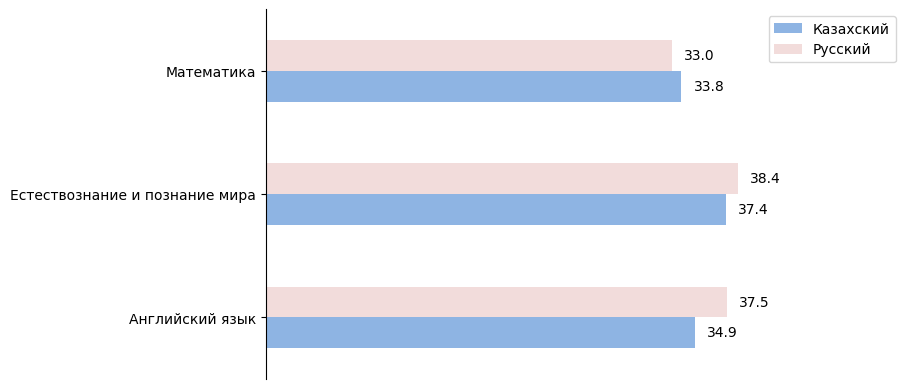

8


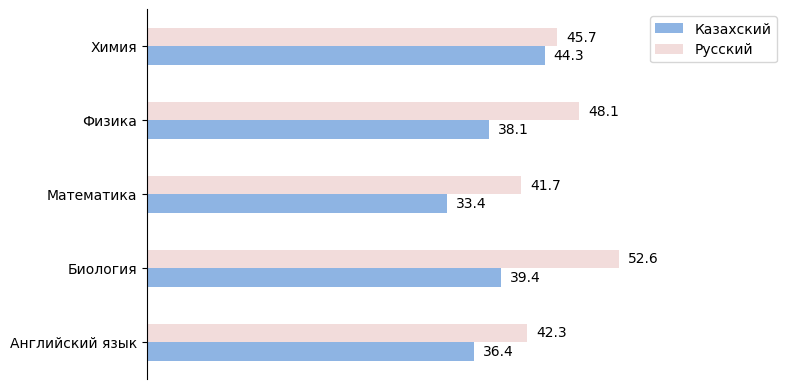

10


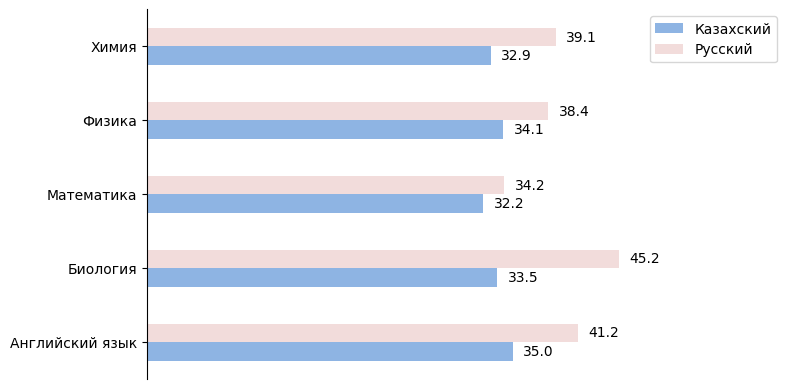

In [45]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

for grade in grades:
    print(grade)
    slp = sub_lang_percent[sub_lang_percent['grade'] == grade]

    custom_colors = ['#8EB4E3', '#F2DCDB']
    pivot_df = slp.pivot_table(index='subject', columns='lang', values='percent')

    ax = pivot_df.plot(kind='barh', stacked=False, color=custom_colors)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('')
    plt.xticks([])

    # Remove outer border/spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)

    # Add data labels to the bars
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 1, p.get_y() + p.get_height() / 2.0, f'{width:.1f}', ha='left', va='center')
    plt.savefig(rf"C:\Users\kassenov_r\report-automation\small_schools\lang_bars\{grade}", bbox_inches='tight', dpi=1200)
    plt.show()

In [157]:
rsp_dict = {}
for grade in grades:
    subject_dict ={}
    for subject in subjects:
        table = merged_df[(merged_df['grade'] == grade) & (merged_df['subject'] == subject)][['region', 'grade', 'subject', 'percent']]
        if not t.empty:
            subject_dict[subject] = table
    rsp_dict[grade] = subject_dict

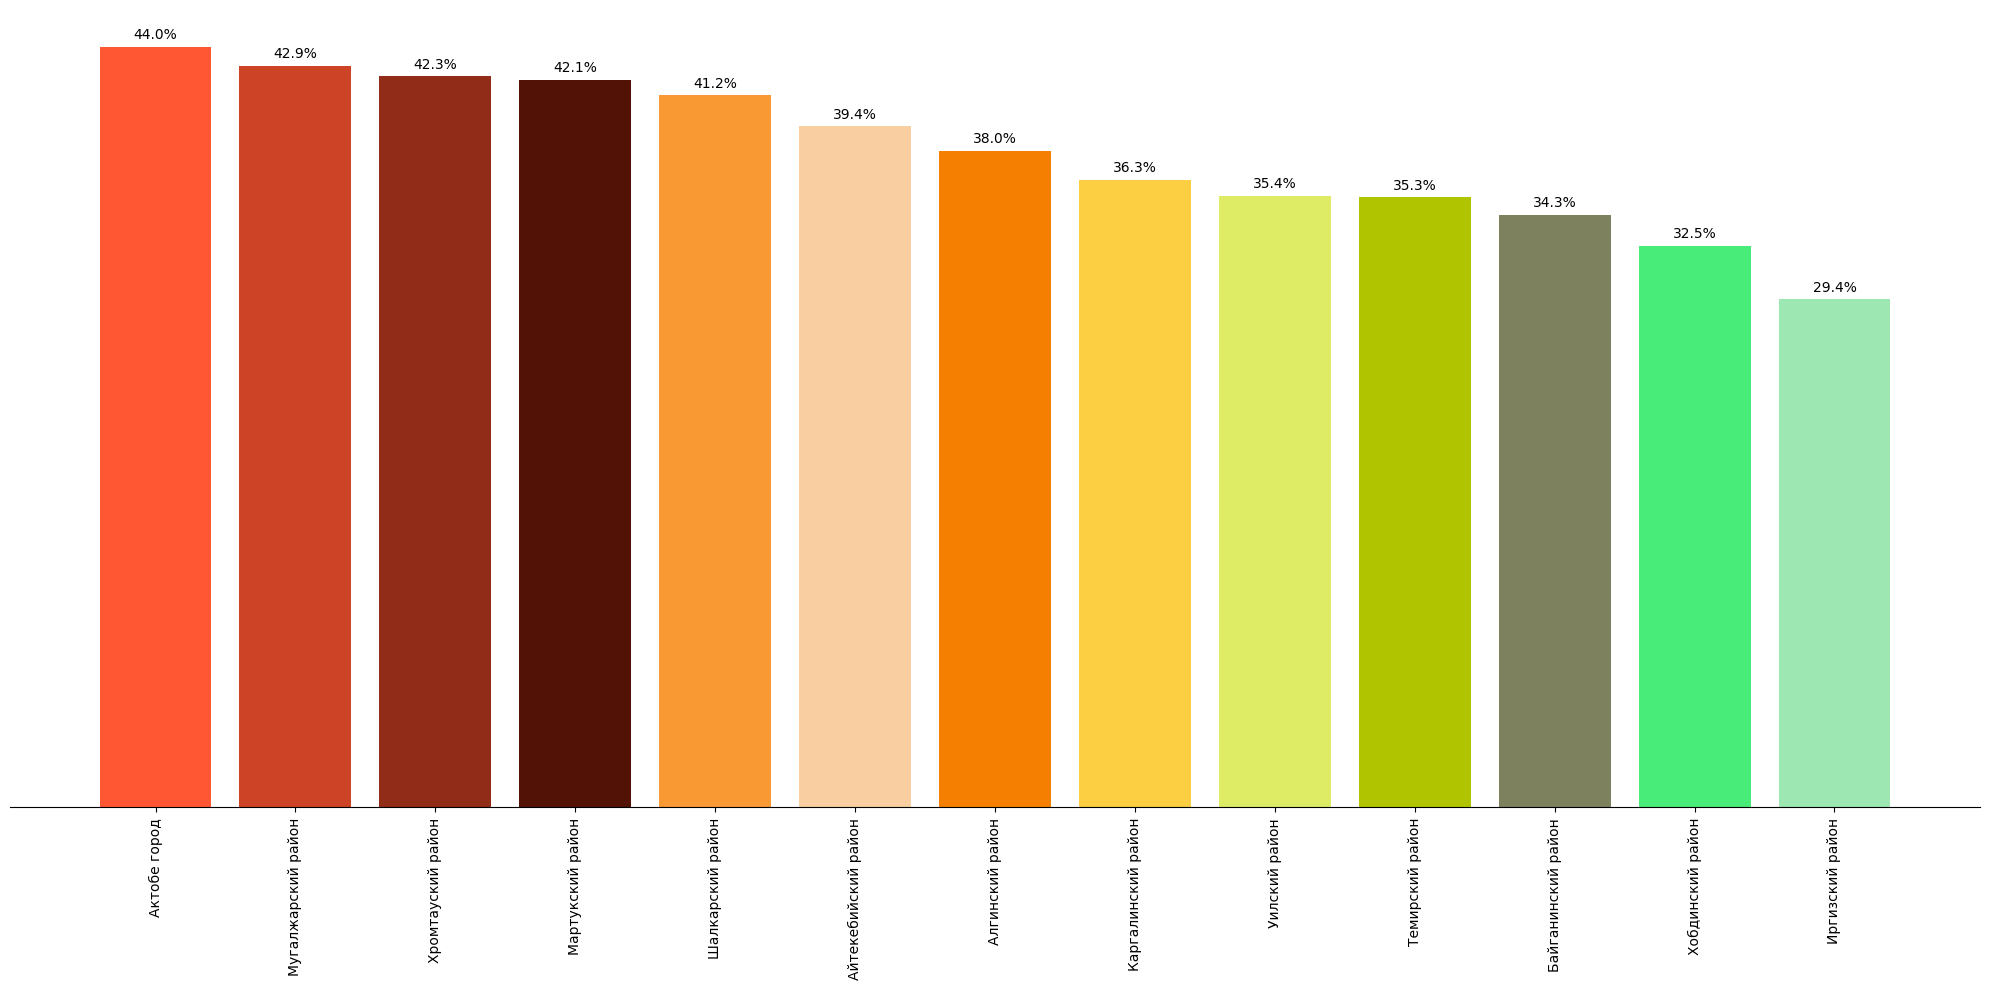

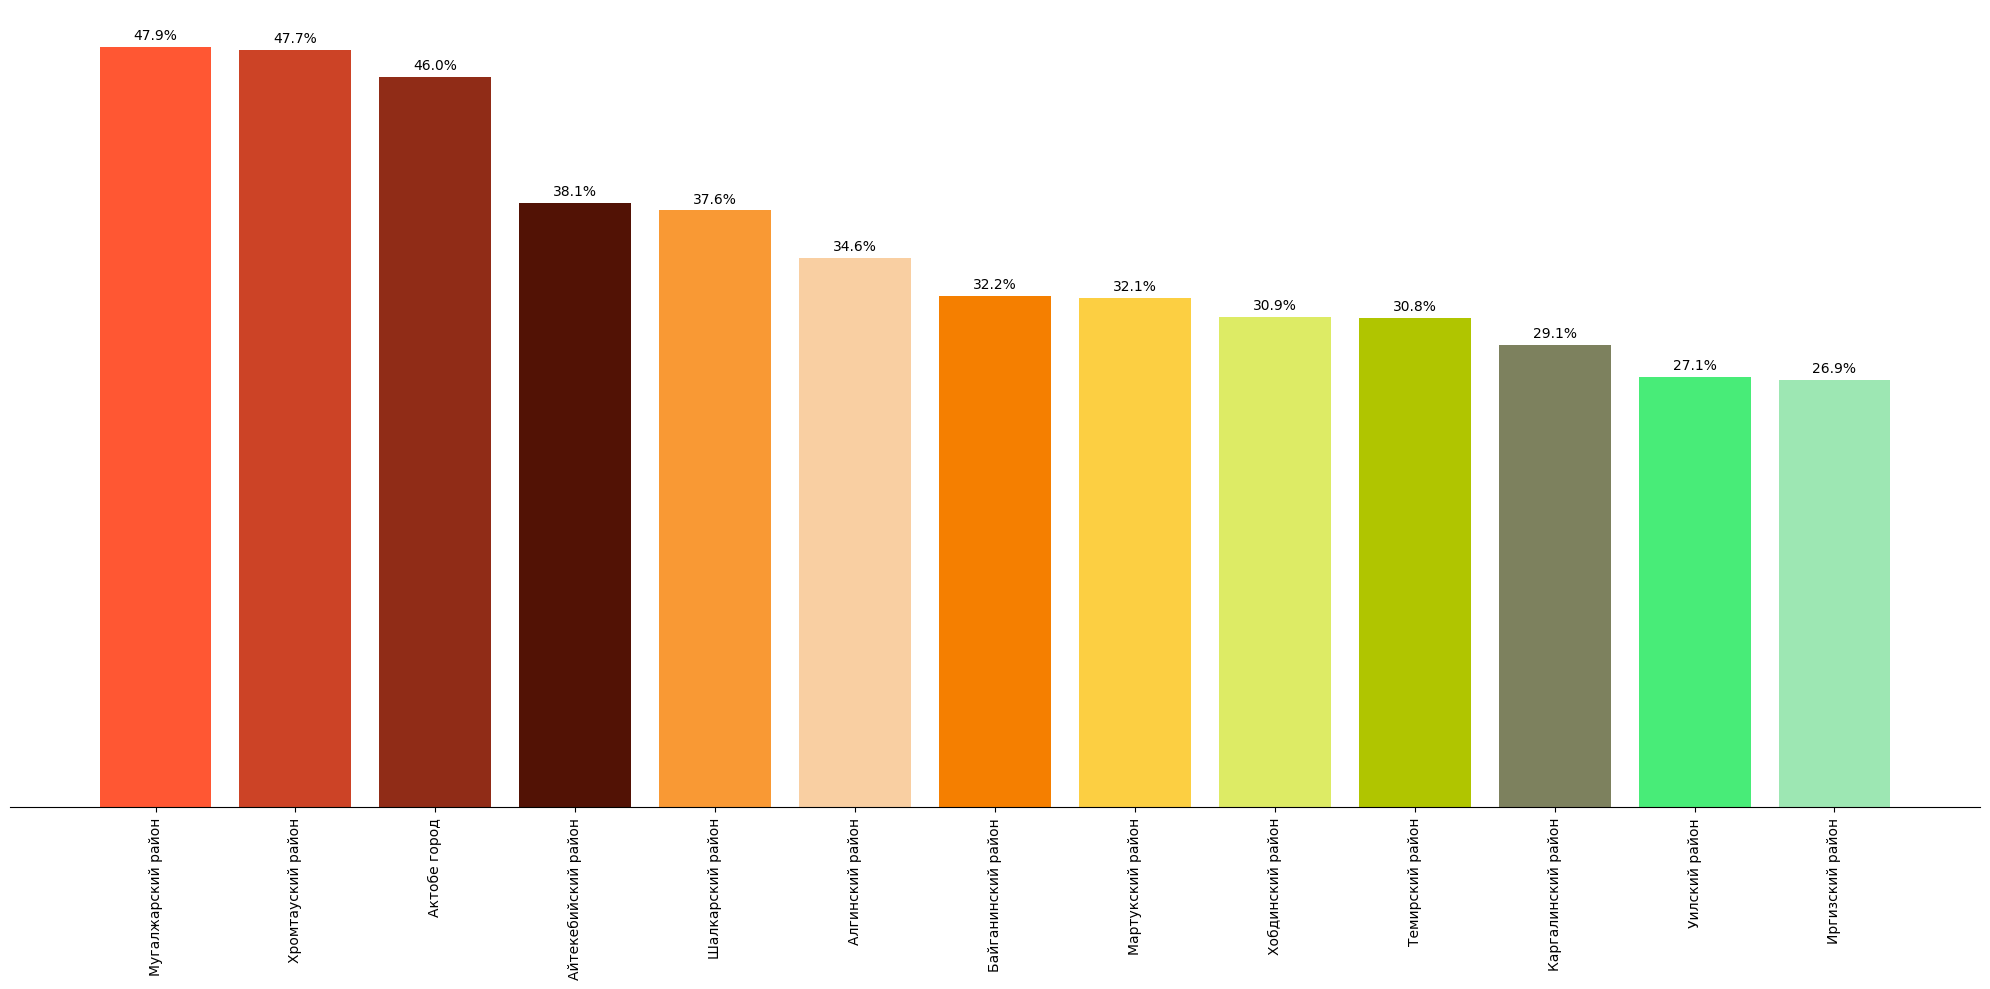

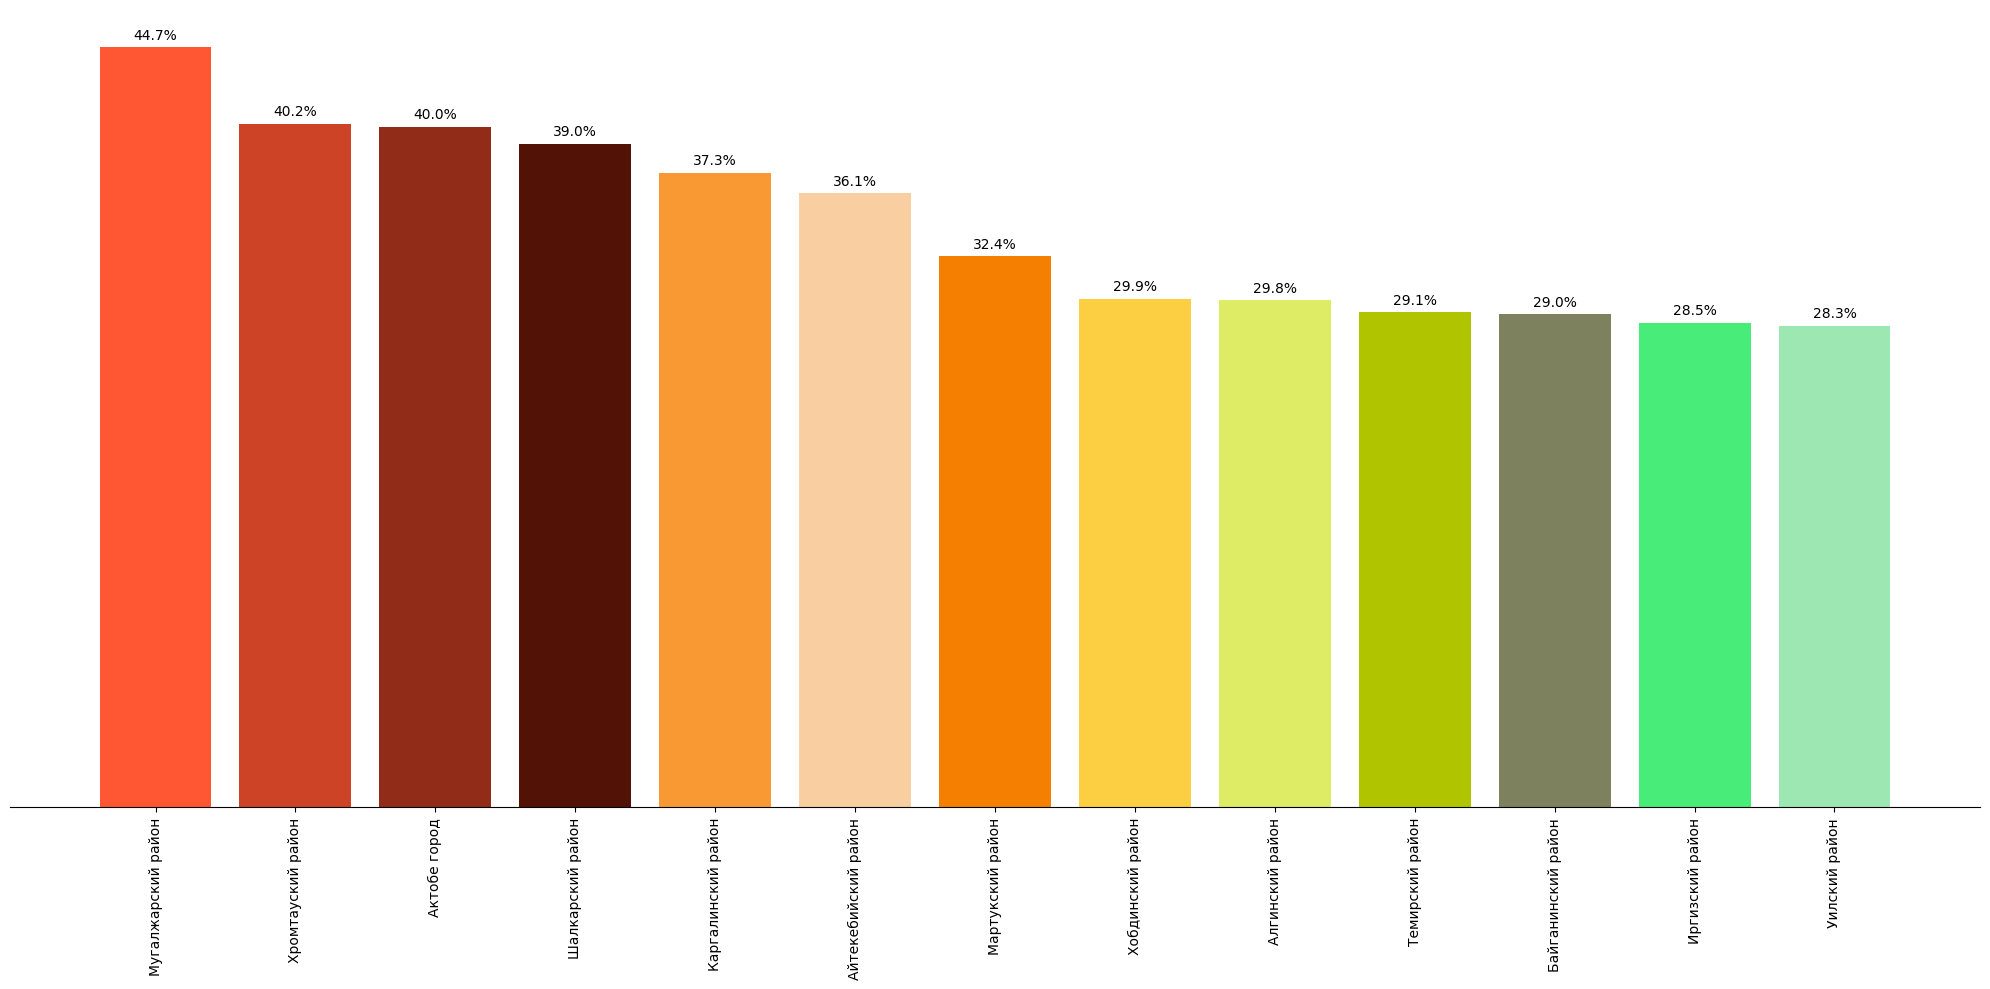

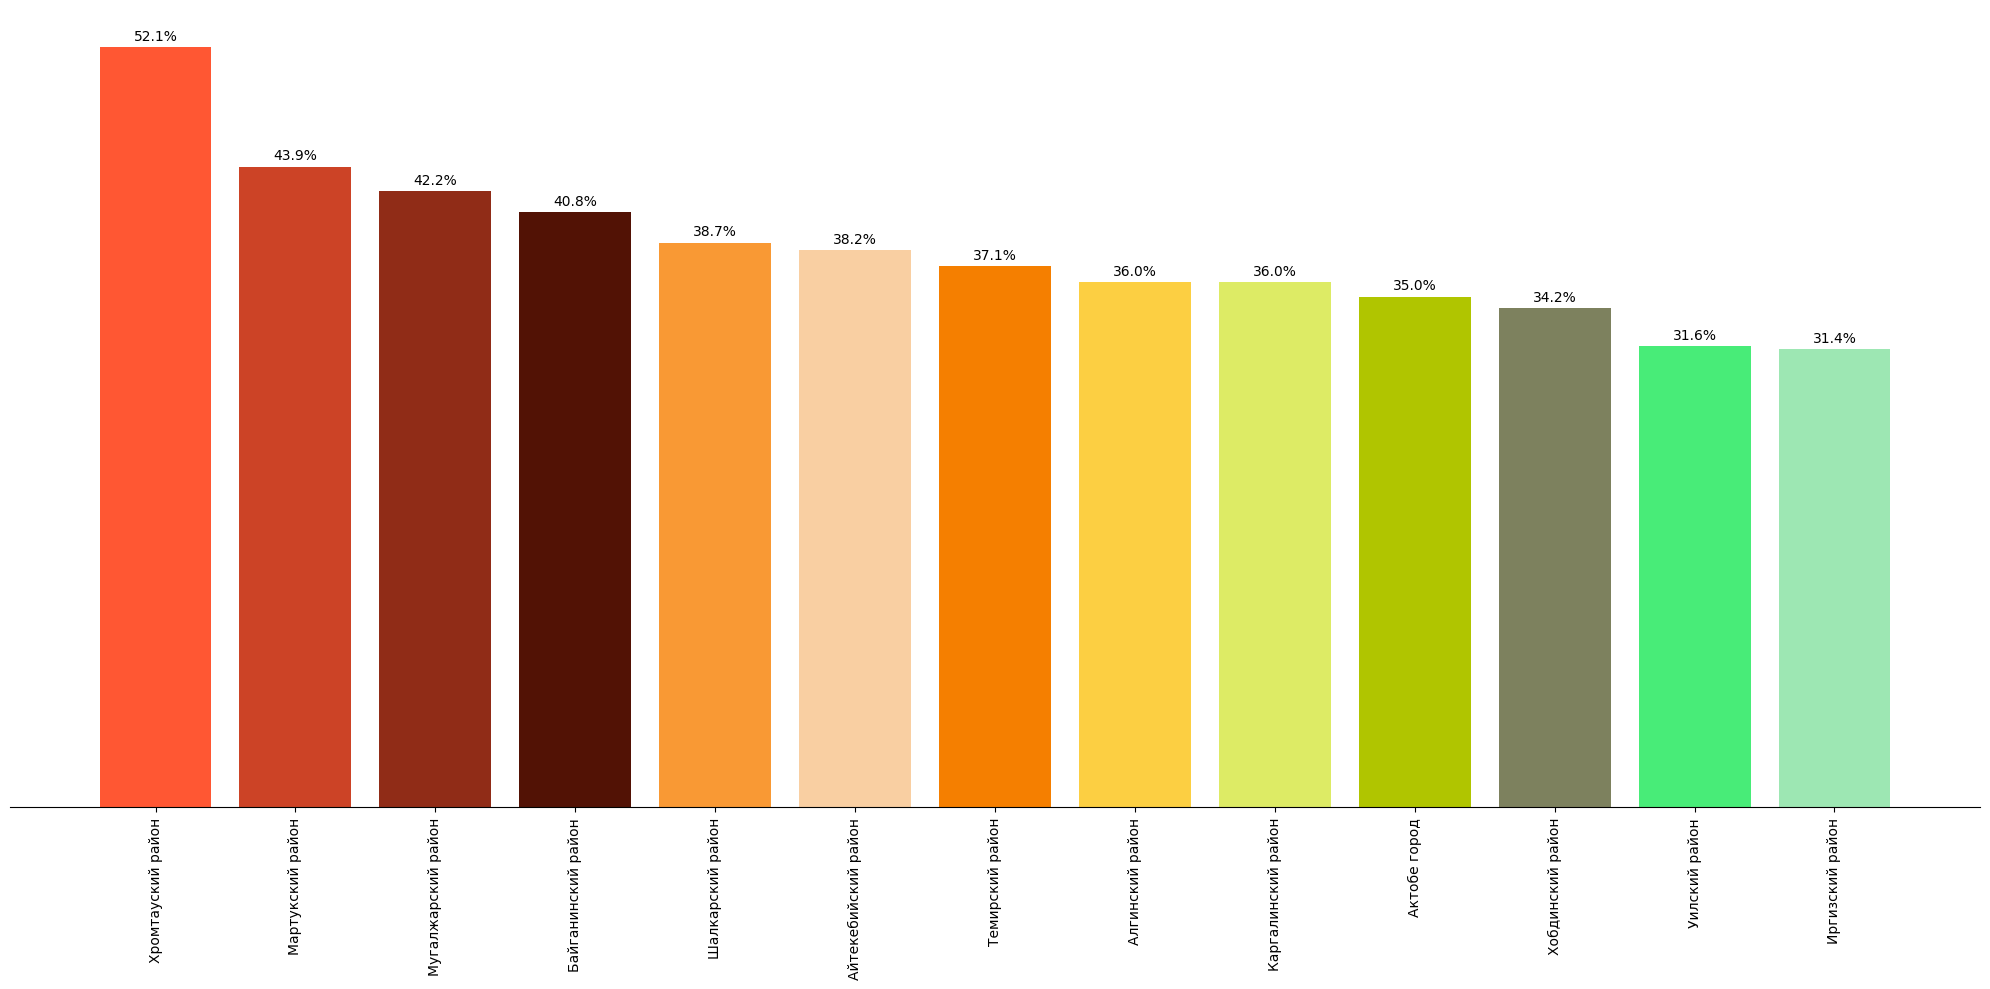

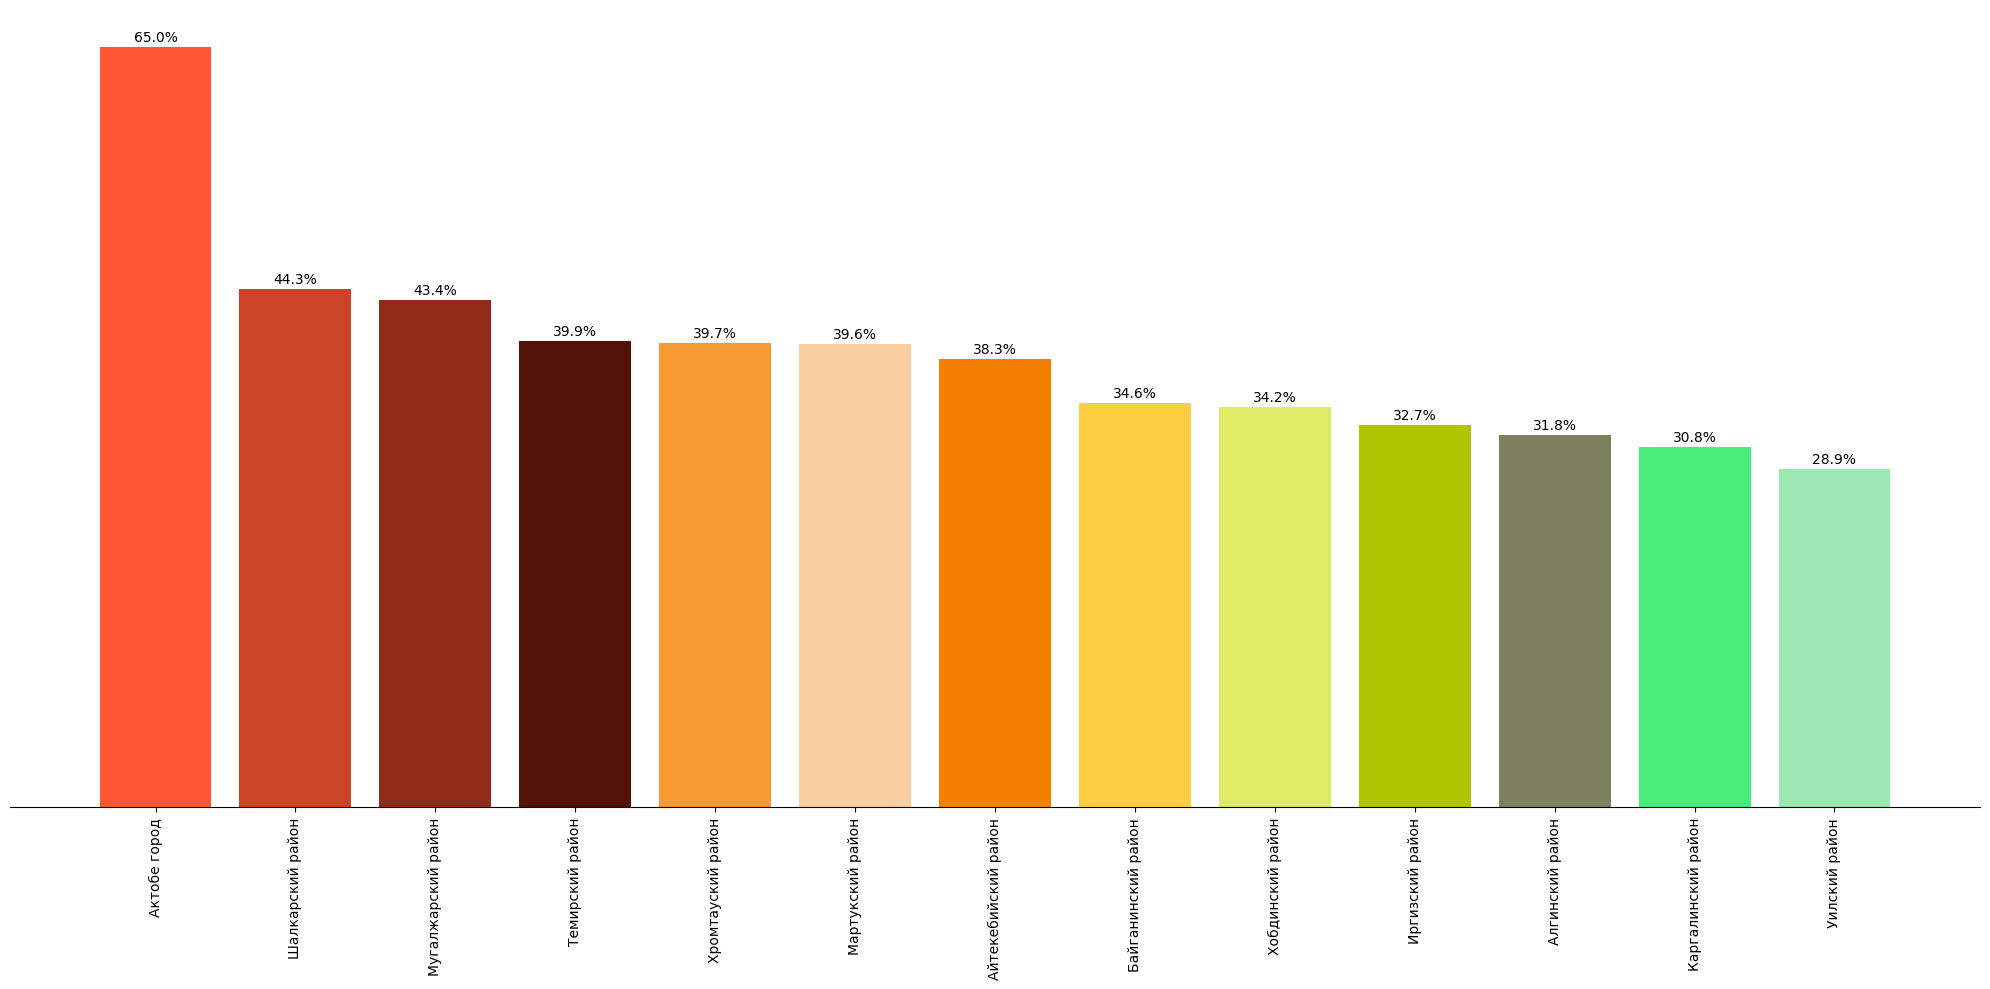

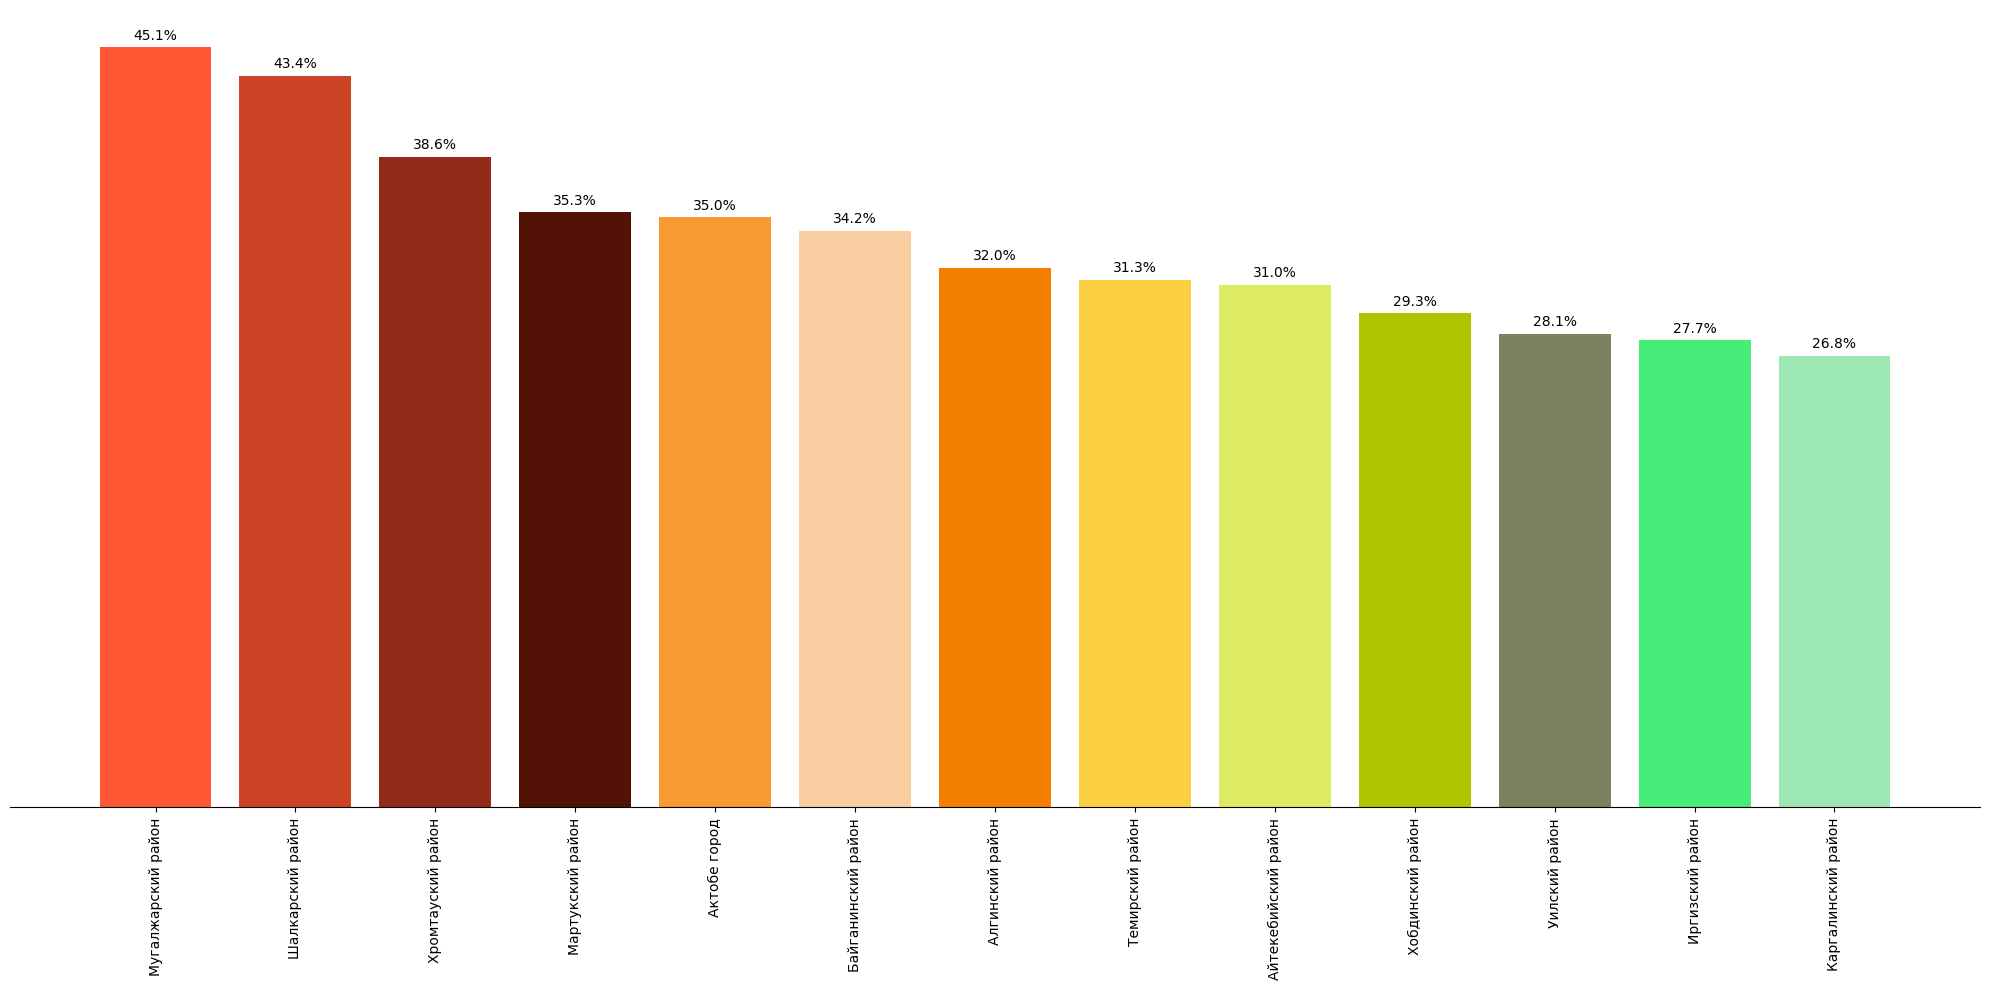

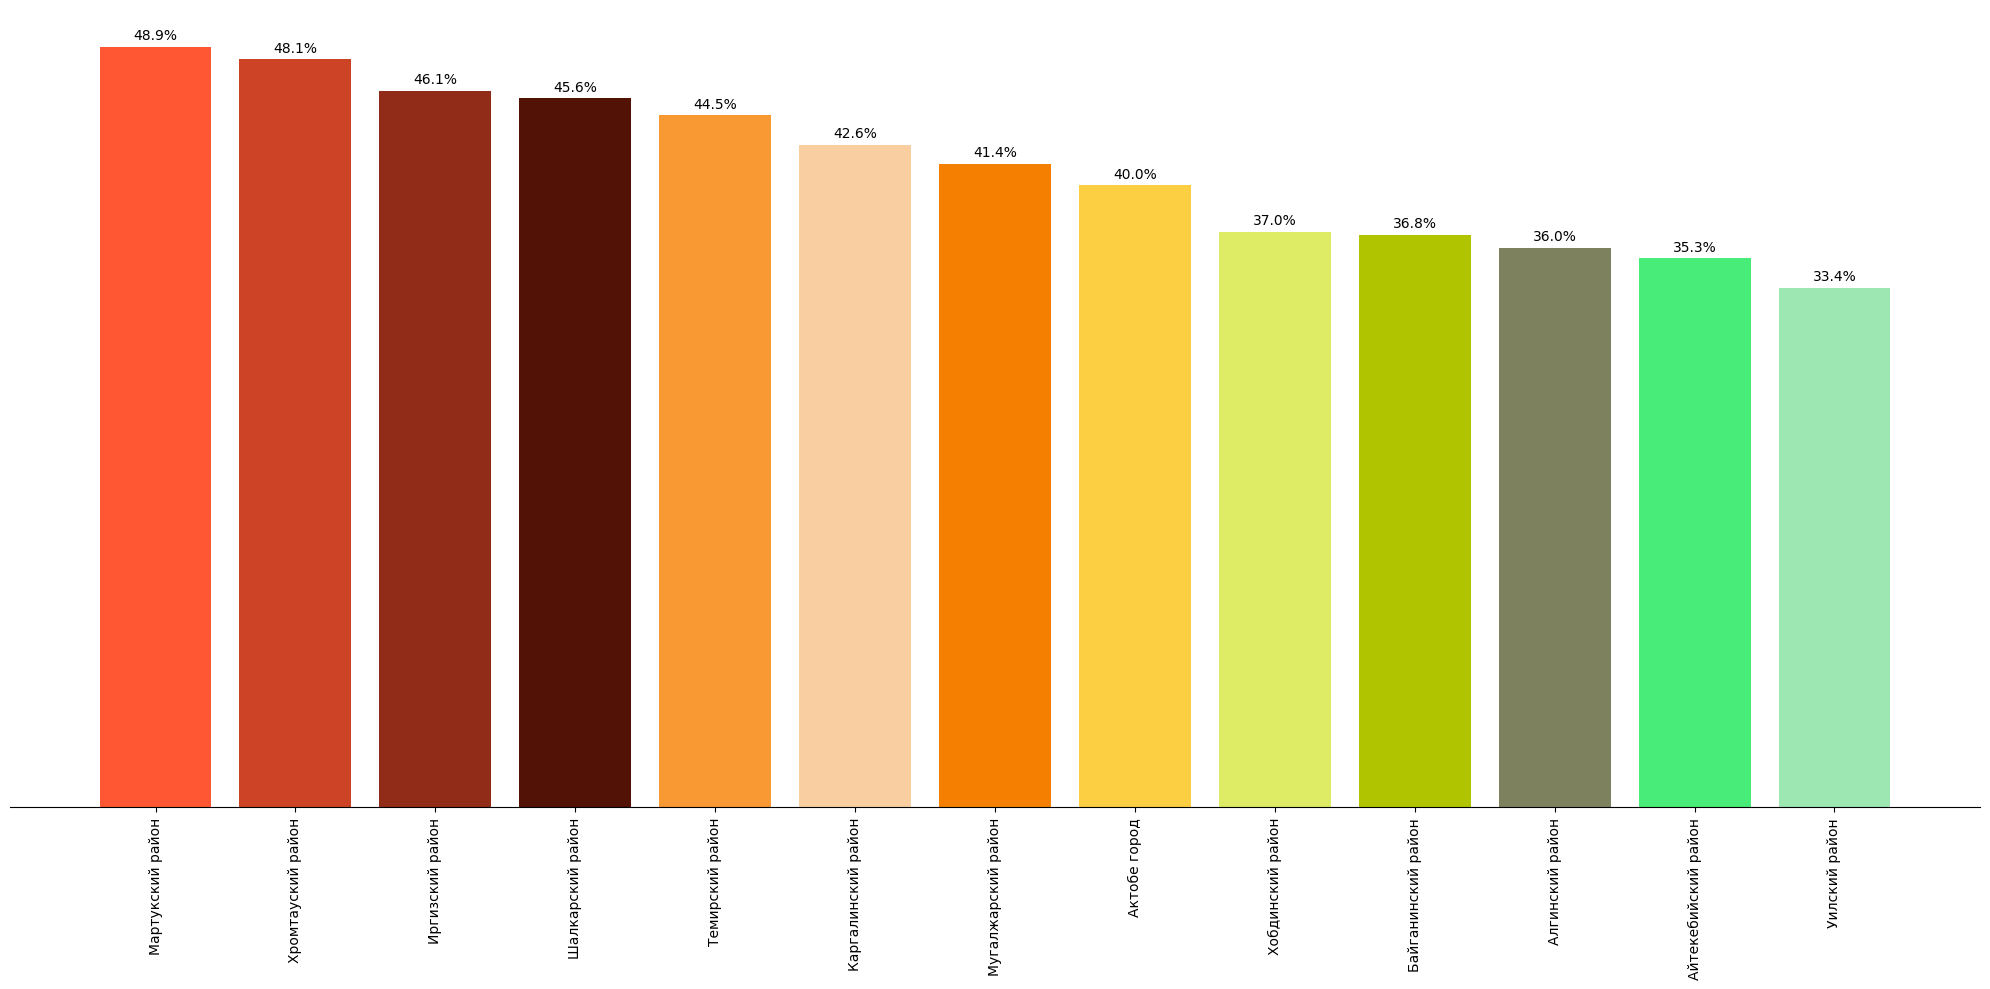

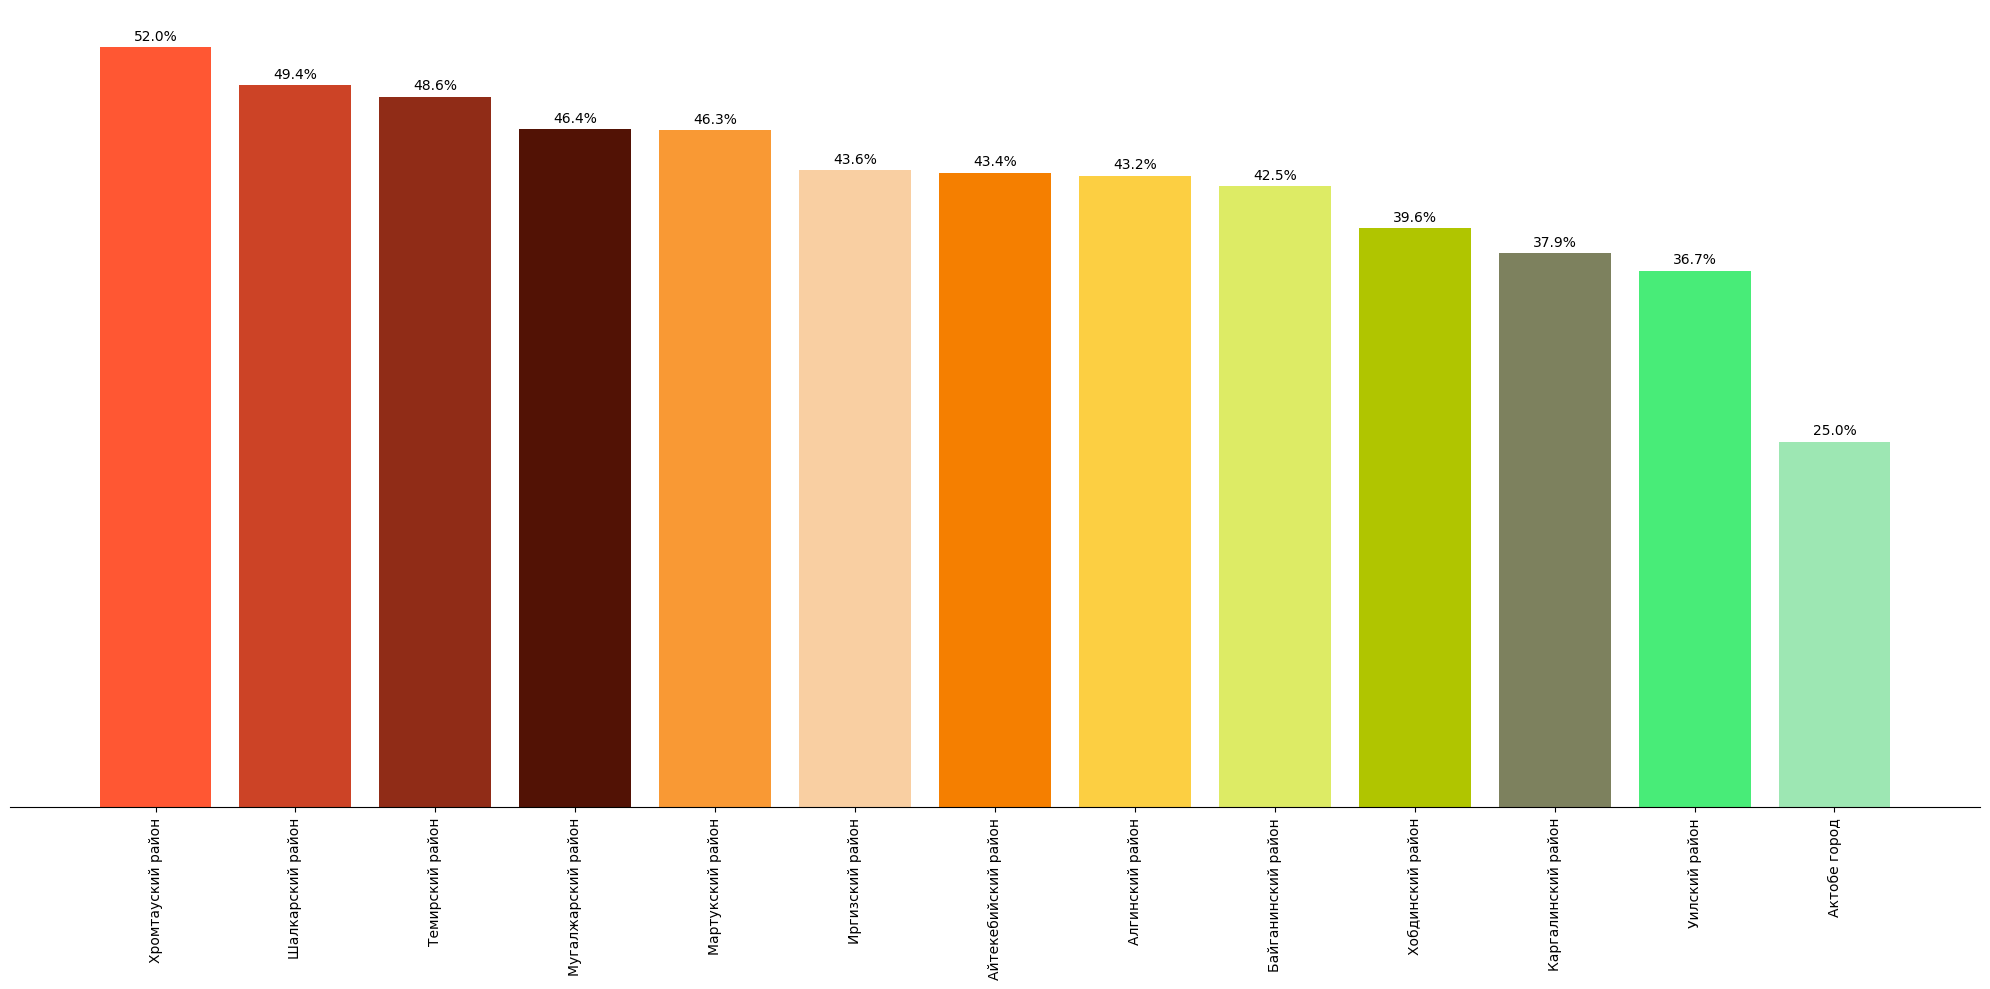

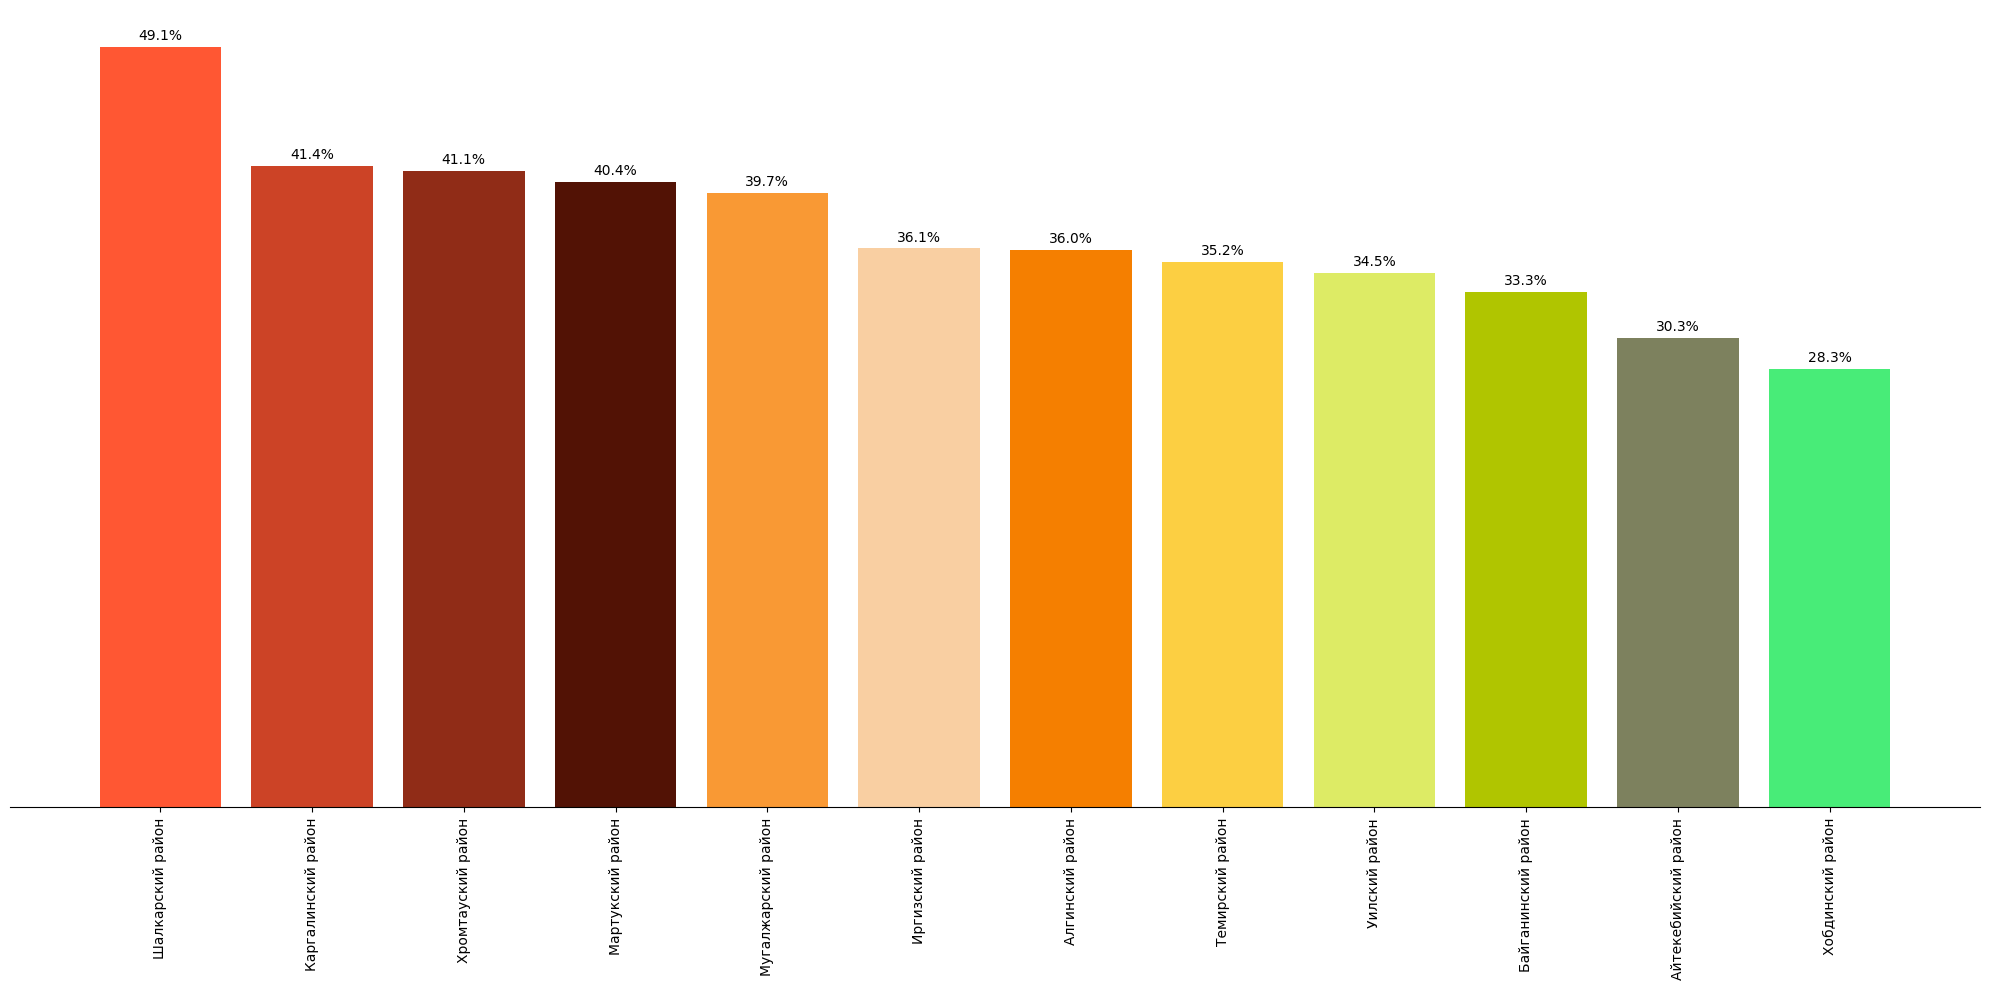

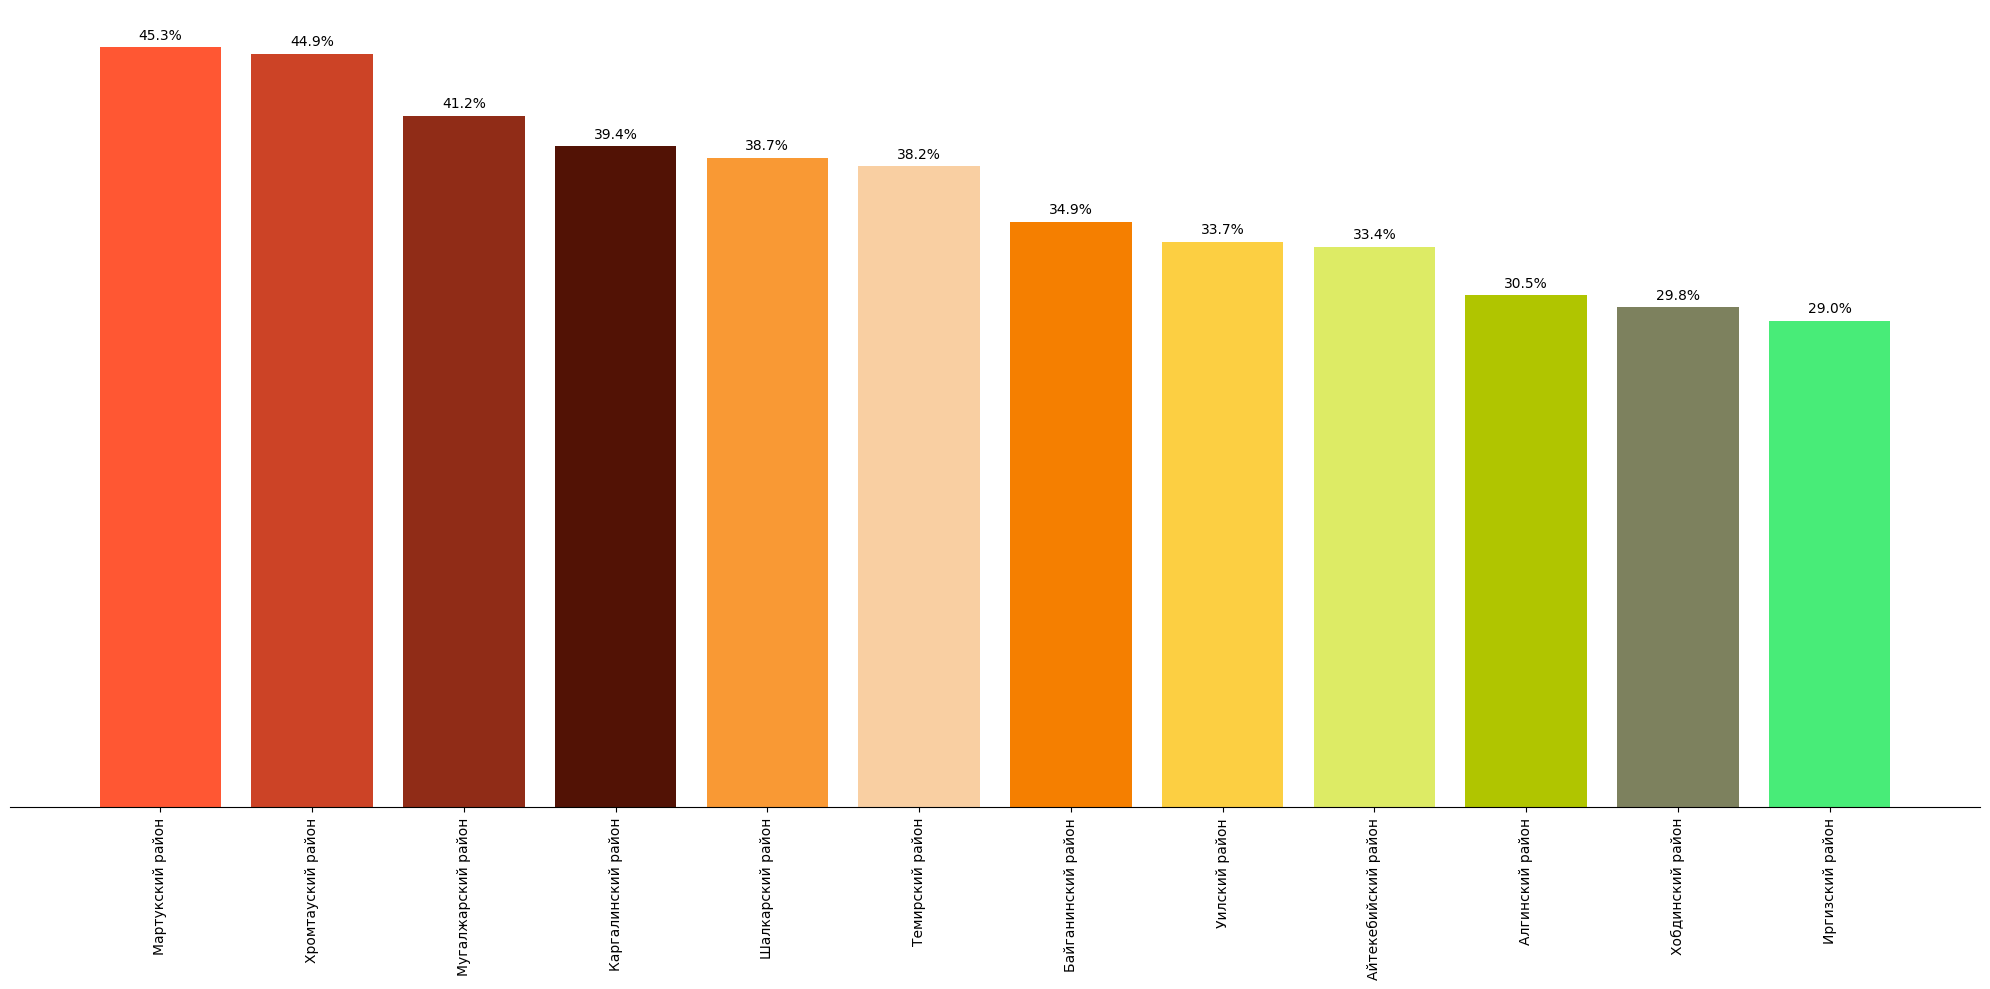

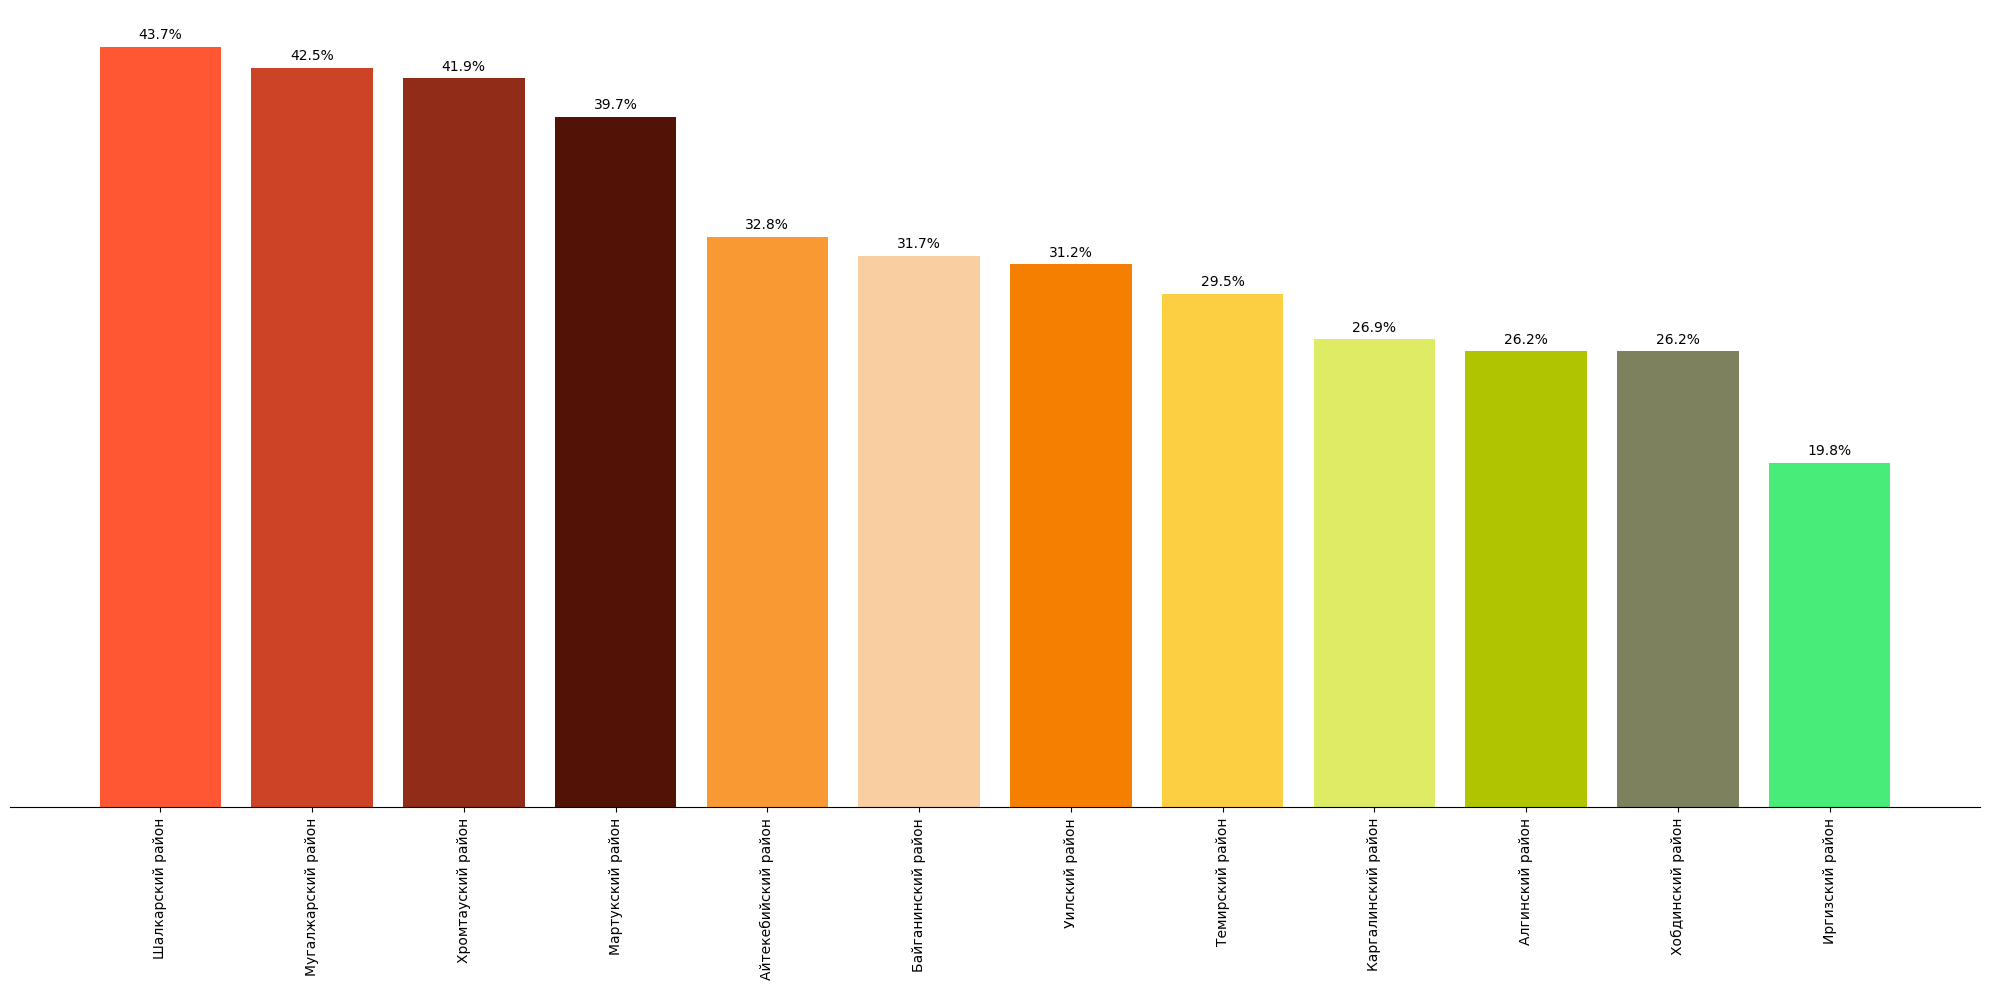

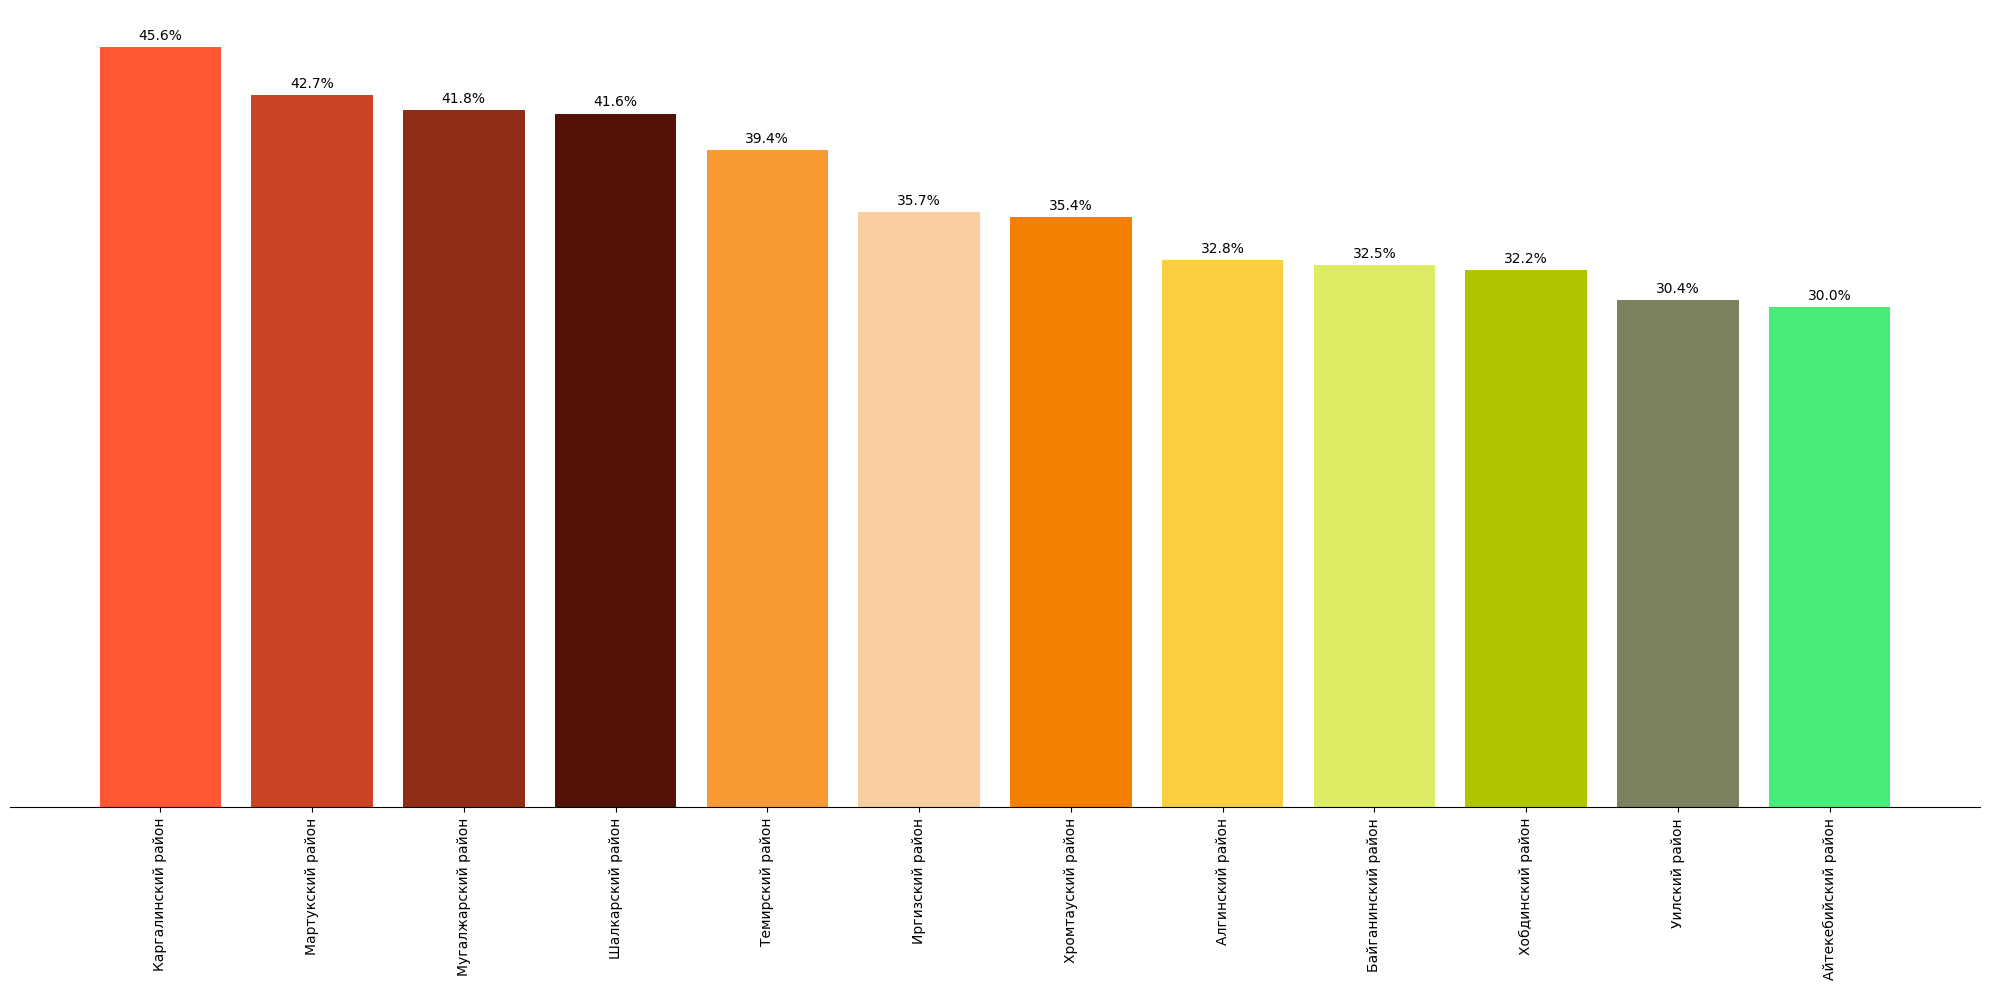

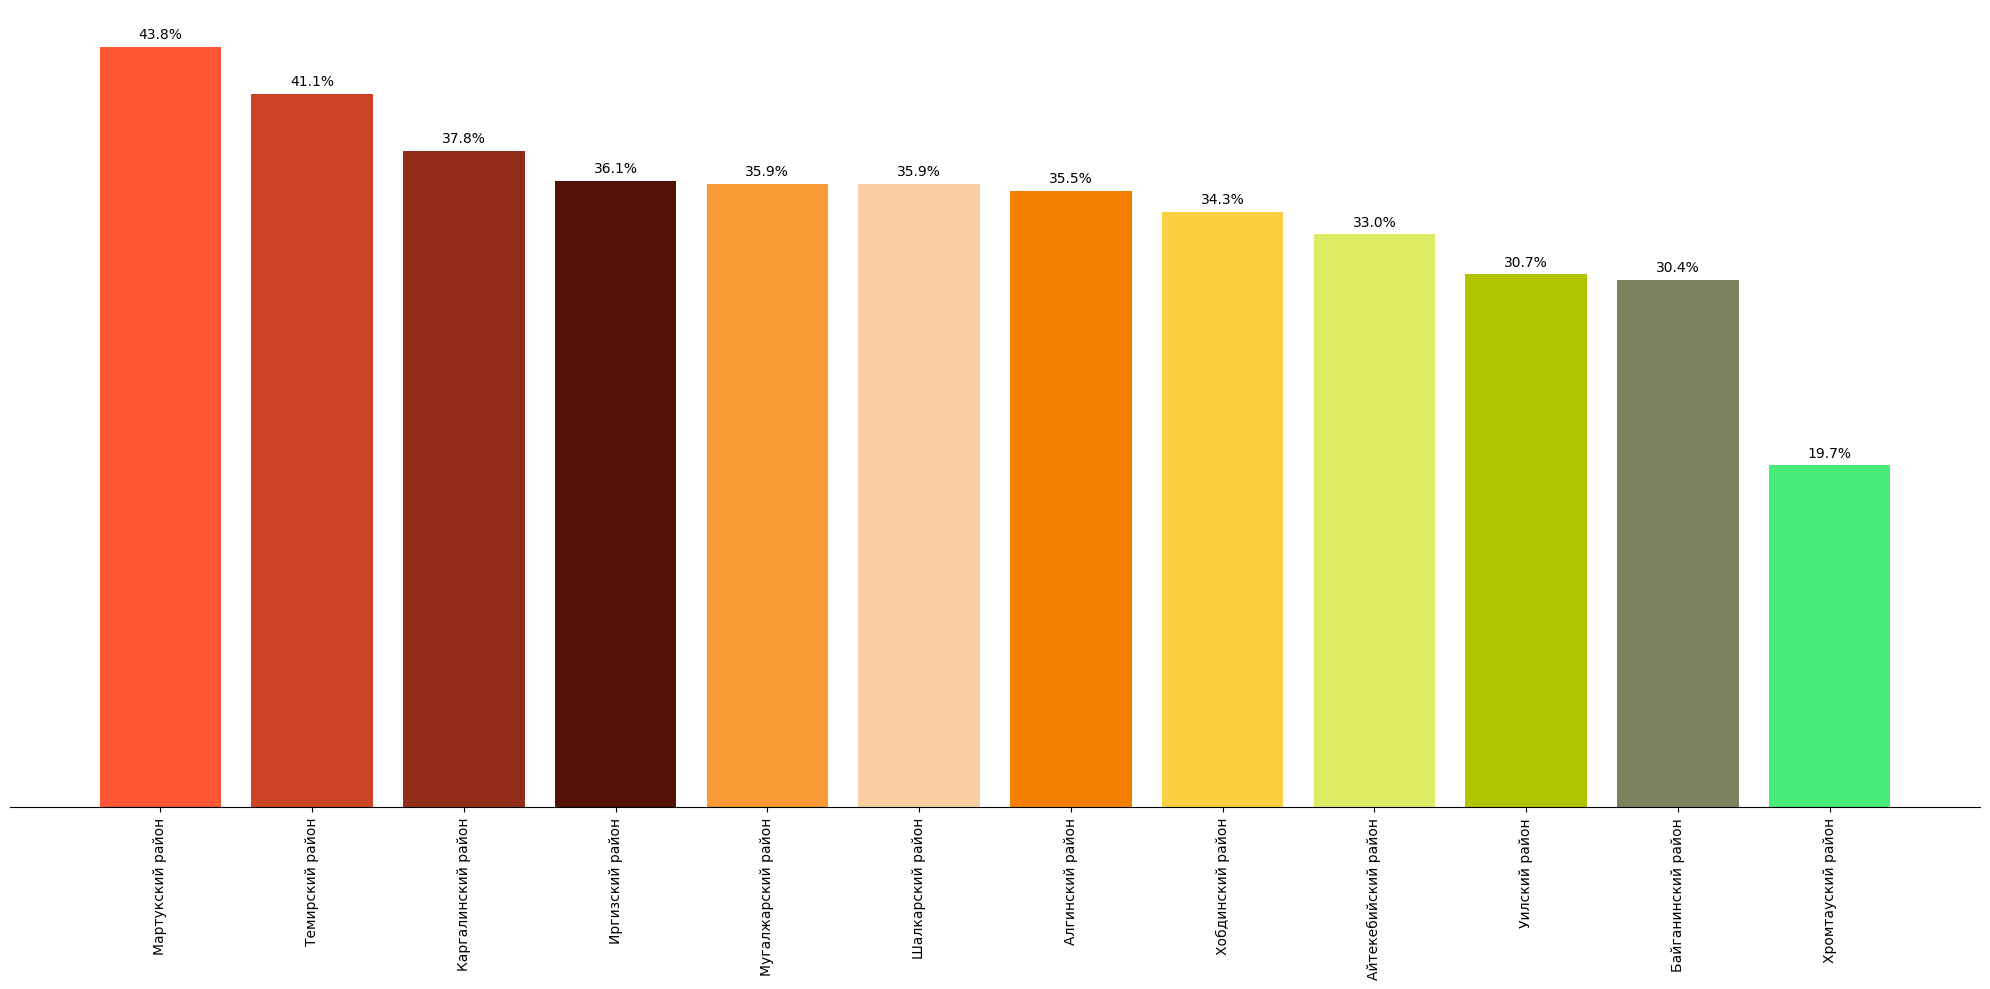

In [159]:
import pandas as pd
import matplotlib.pyplot as plt

custom_colors = [
    '#FF5733', '#CC4326', '#902C17', '#521205', '#F99934', '#F9CFA2', '#F57F00', '#FCCF42',
    '#DDEB65', '#B0C500', '#7D815E', '#48EC78', '#9DE7B3', '#9DE7E0', '#00C3B1', '#0288BA',
    '#0052BB', '#7469C1', '#EEB6E7', '#E511CB', '#D53176', '#C2BBBF'
]

for grade, subs in rsp_dict.items():
    for subject, table in subs.items():
        t = table[(table['grade'] == grade) & (table['subject'] == subject)][['region', 'percent']]
        if not t.empty:
            t_grouped = t.groupby('region')['percent'].mean().round(1).reset_index().sort_values(by='percent', ascending=False)
            
            plt.figure(figsize=(20, 10))
            regions = t_grouped['region']
            percent = t_grouped['percent']
            
            # Sort data by 'percent' column in descending order
            # sorted_data = t.sort_values('percent', ascending=False)
            # regions = sorted_data['region']
            # percent = sorted_data['percent']
            
            # Get a color for each region
            unique_regions = regions.unique()
            color_dict = {region: custom_colors[i % len(custom_colors)] for i, region in enumerate(unique_regions)}
            
            # Plotting
            # for region, perc in zip(regions, percent):
            #     plt.bar(region, perc, color=color_dict[region])

            for region, perc in zip(t_grouped['region'], t_grouped['percent']):
                plt.bar(region, perc, color=color_dict[region])
                plt.text(region, perc + 0.5, f'{perc}%', ha='center')
            
            # Set labels and title
            plt.xlabel('')
            plt.ylabel('')
            plt.title('')
            plt.xticks(rotation=90)
            plt.yticks([])
            
            # Remove borders
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(True)
            plt.gca().spines['left'].set_visible(False)
            
            # Remove y ticks
            # plt.yticks([])
            
            # Show legend with colors
            handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[region]) for region in color_dict.keys()]
            # plt.legend(handles, color_dict.keys(), title='', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.savefig(rf"C:\Users\kassenov_r\report-automation\small_schools\lang_bars\{grade}_{subject}.png", dpi=600)
            plt.show()

141


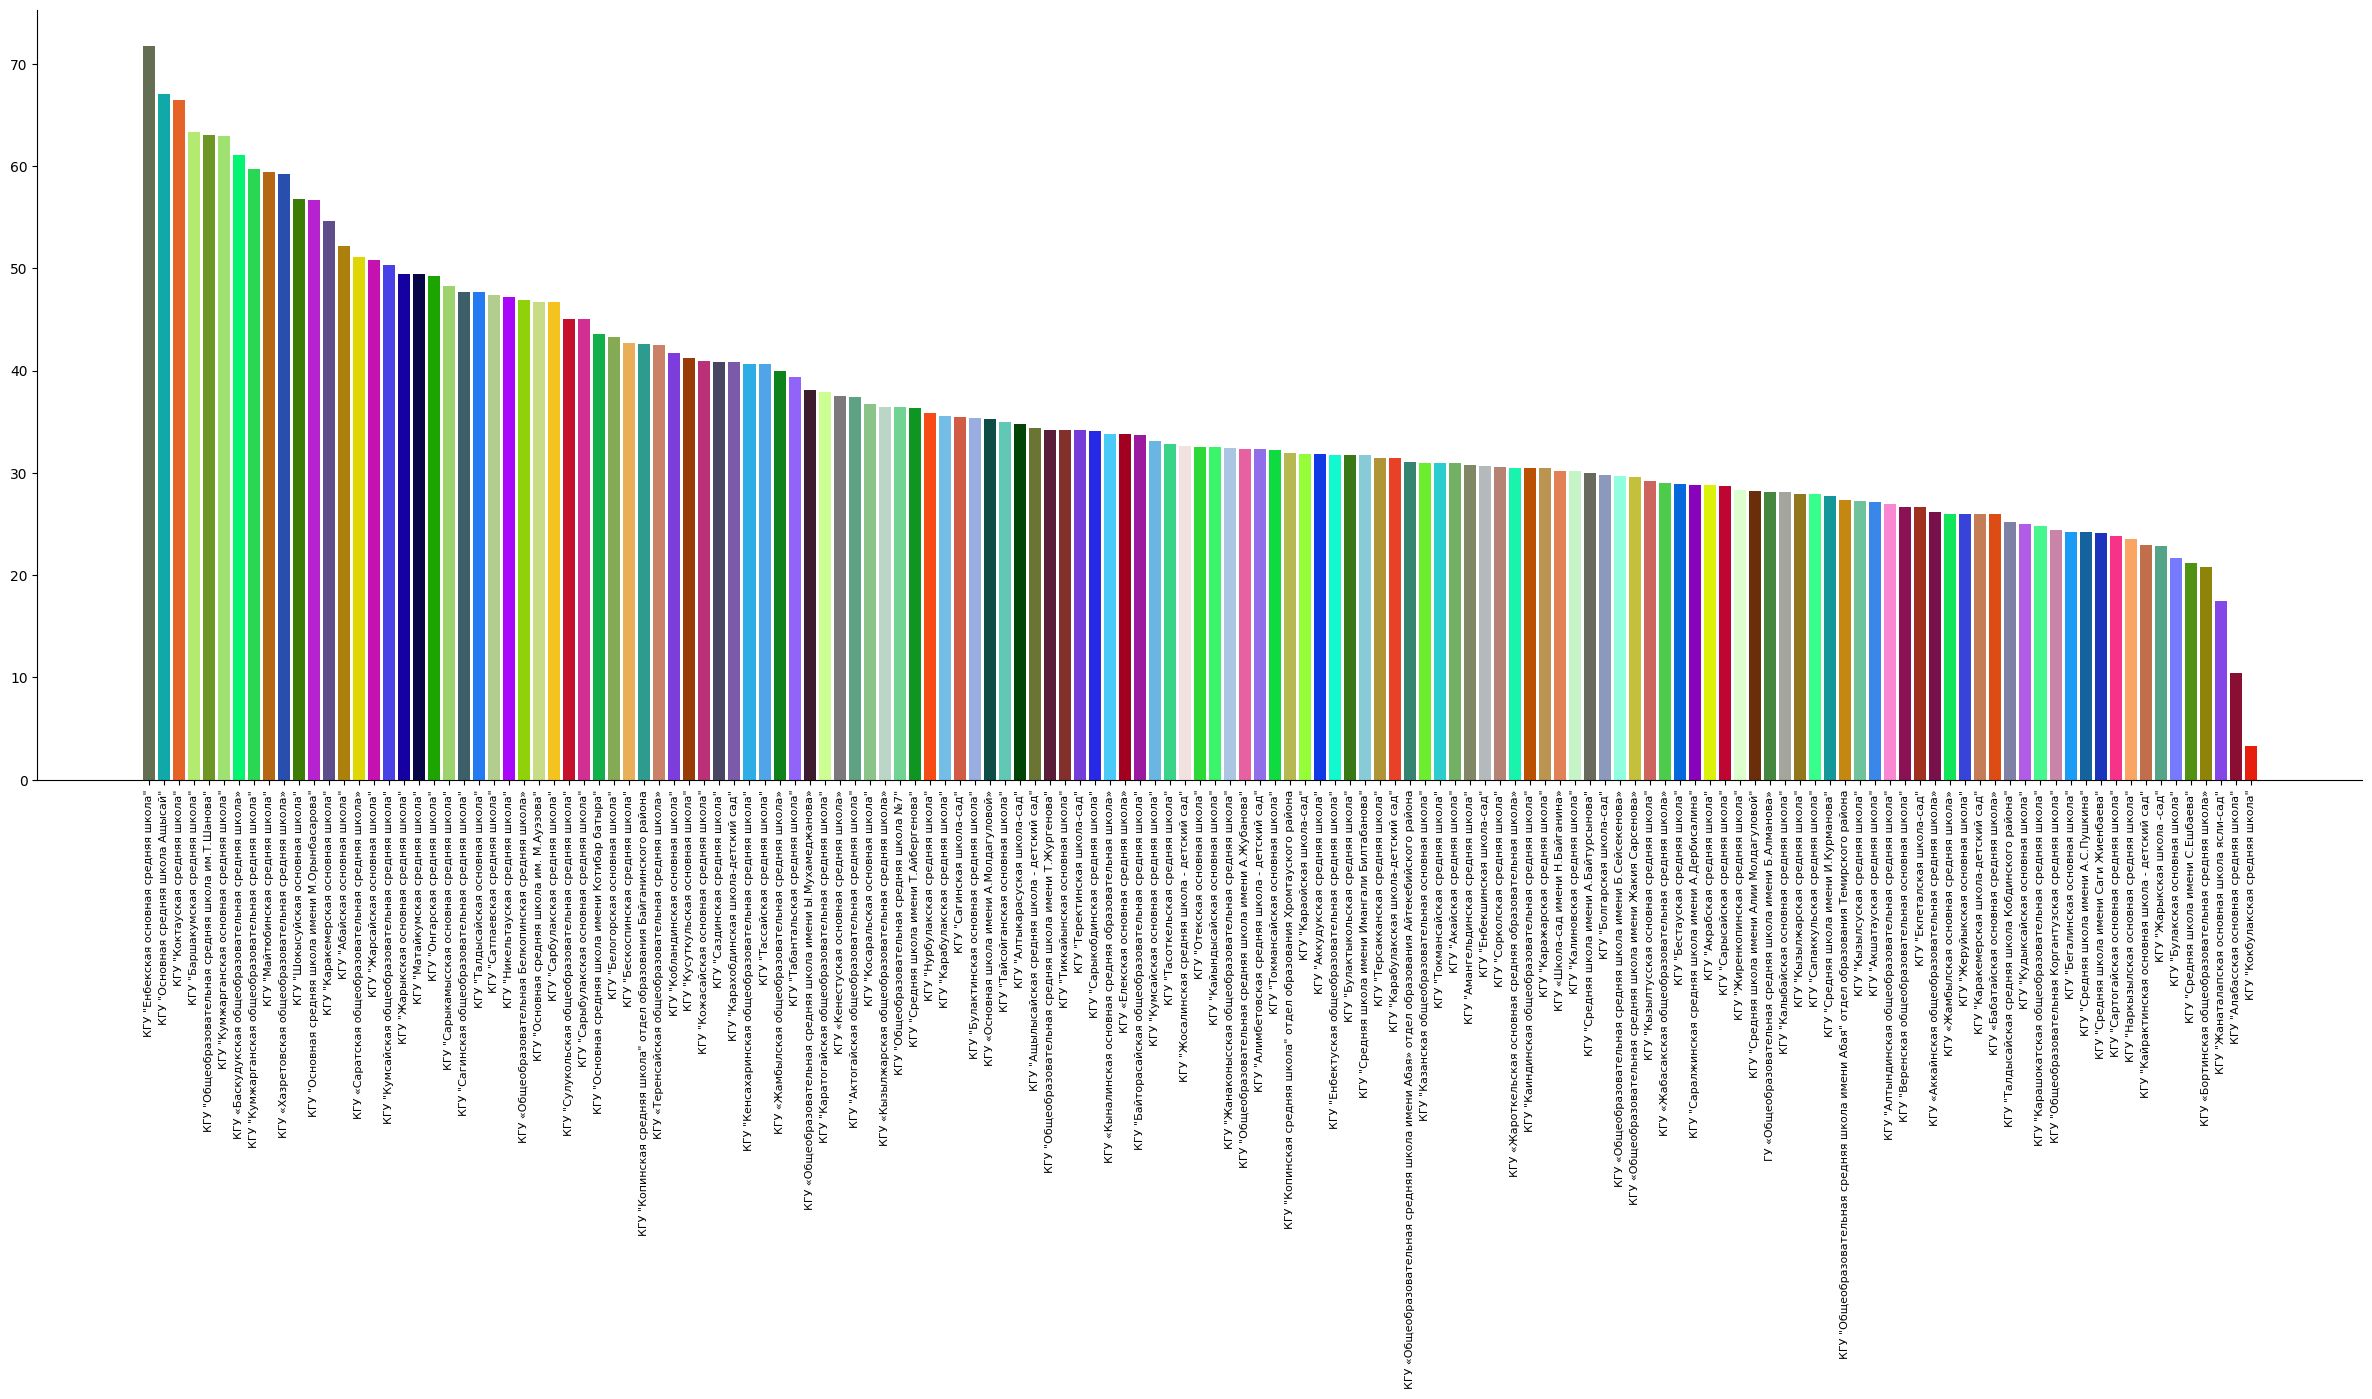

141


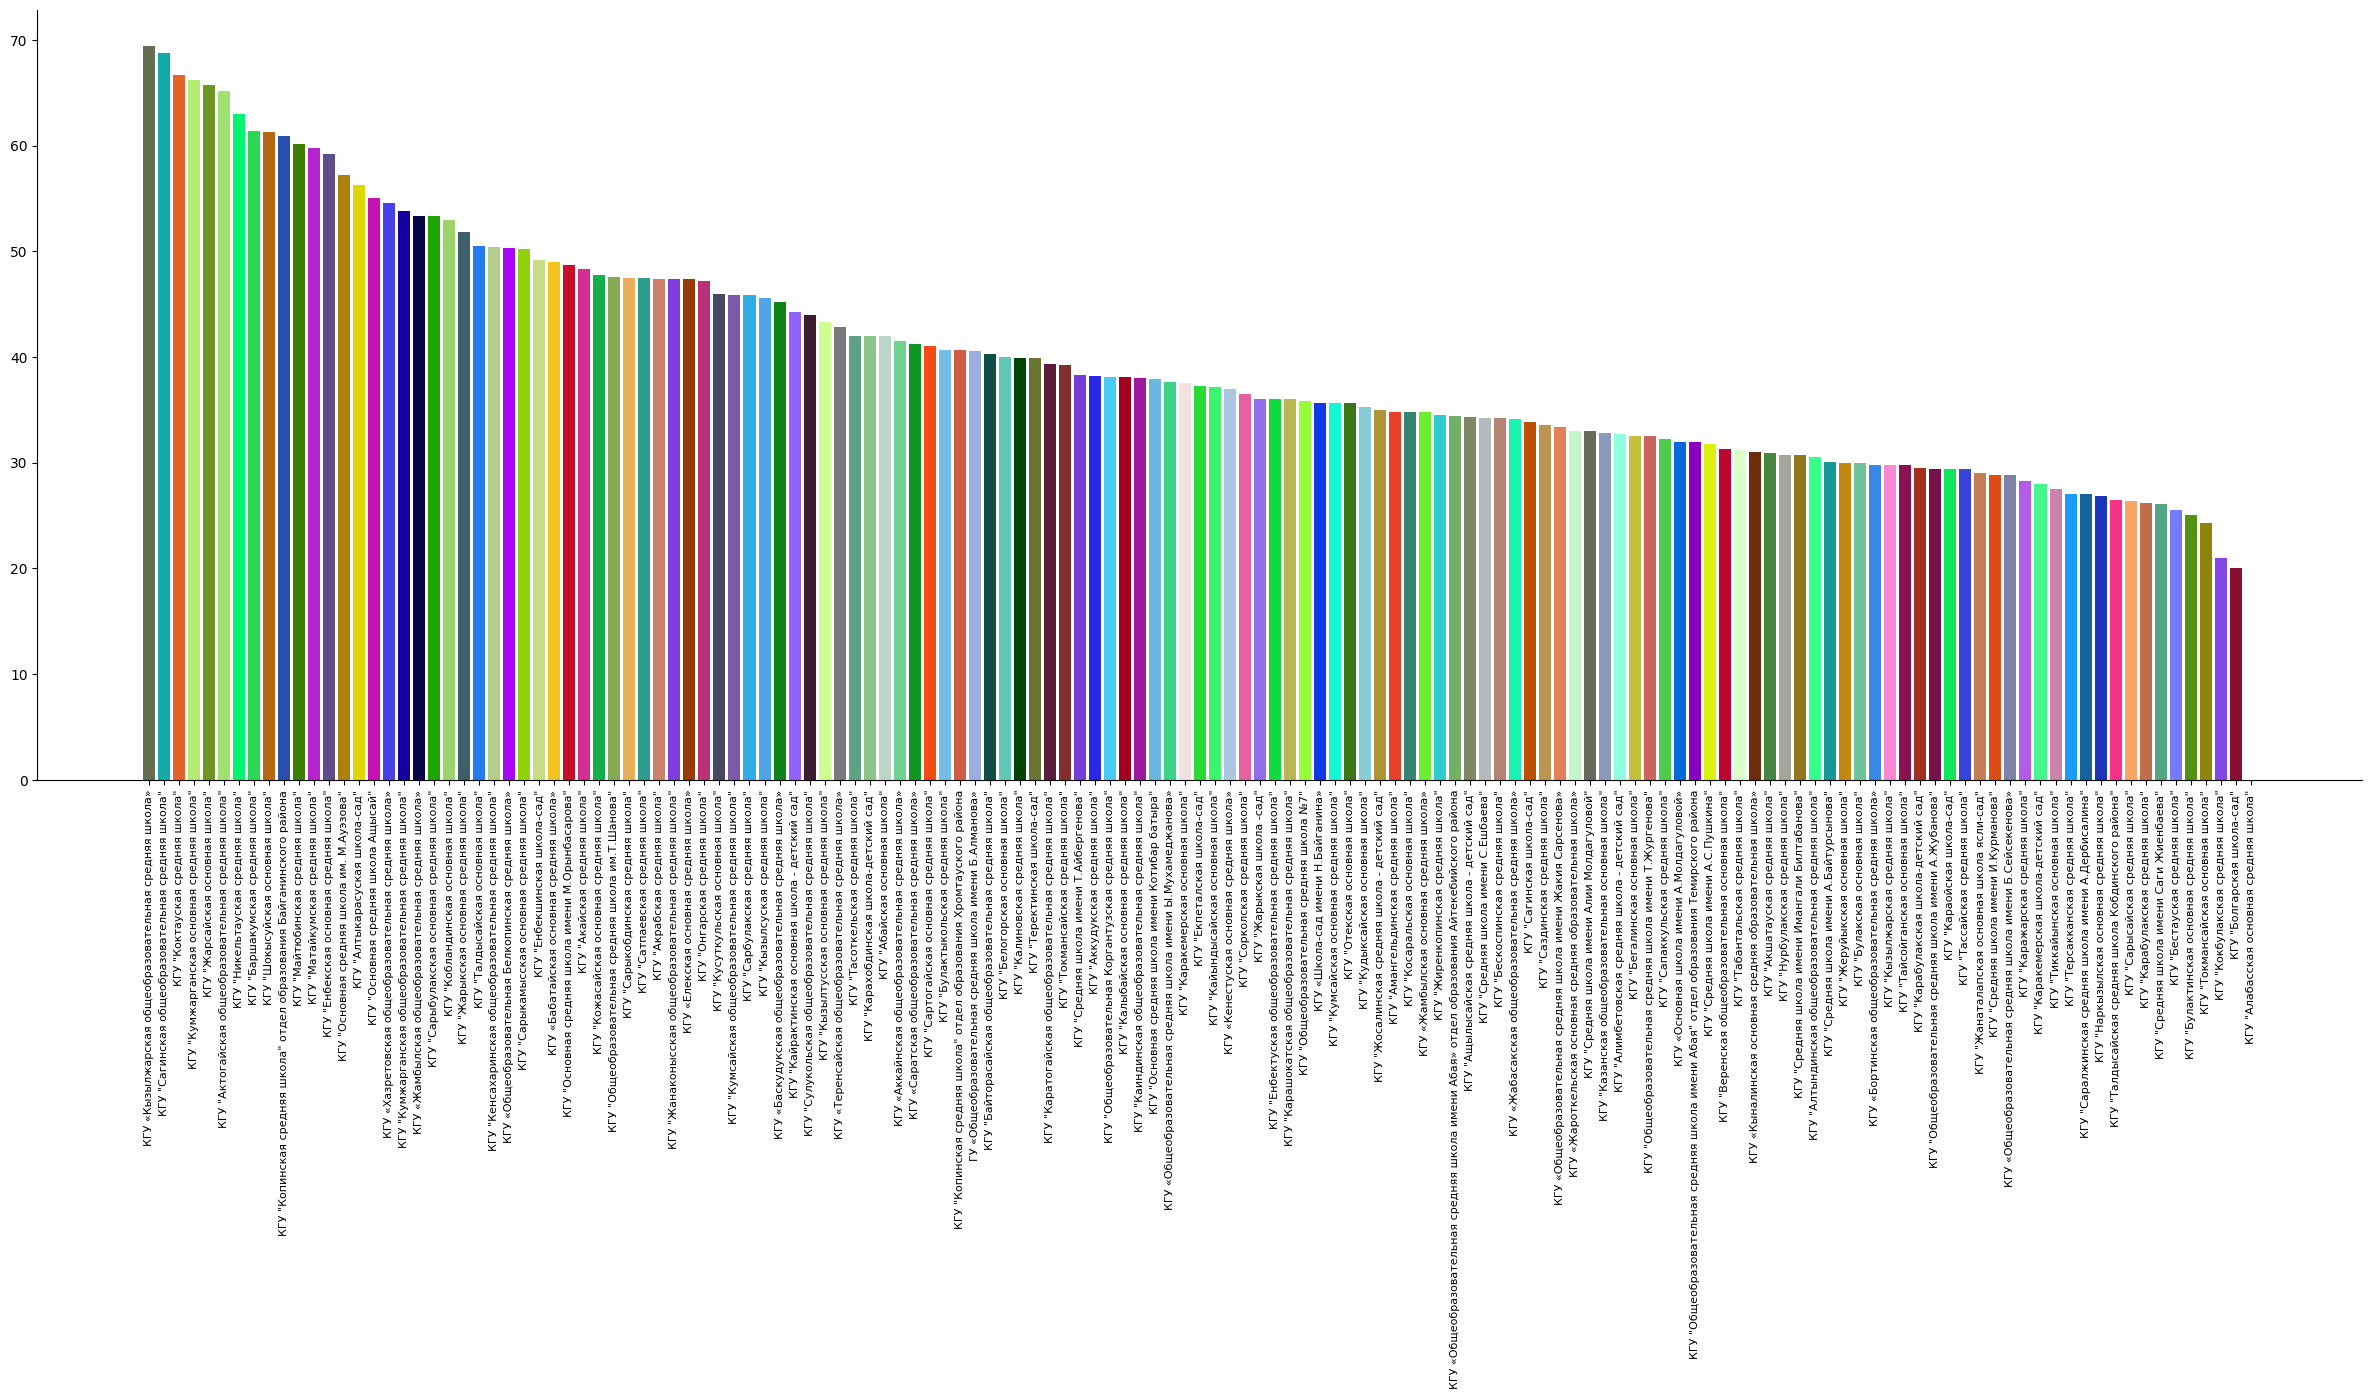

84


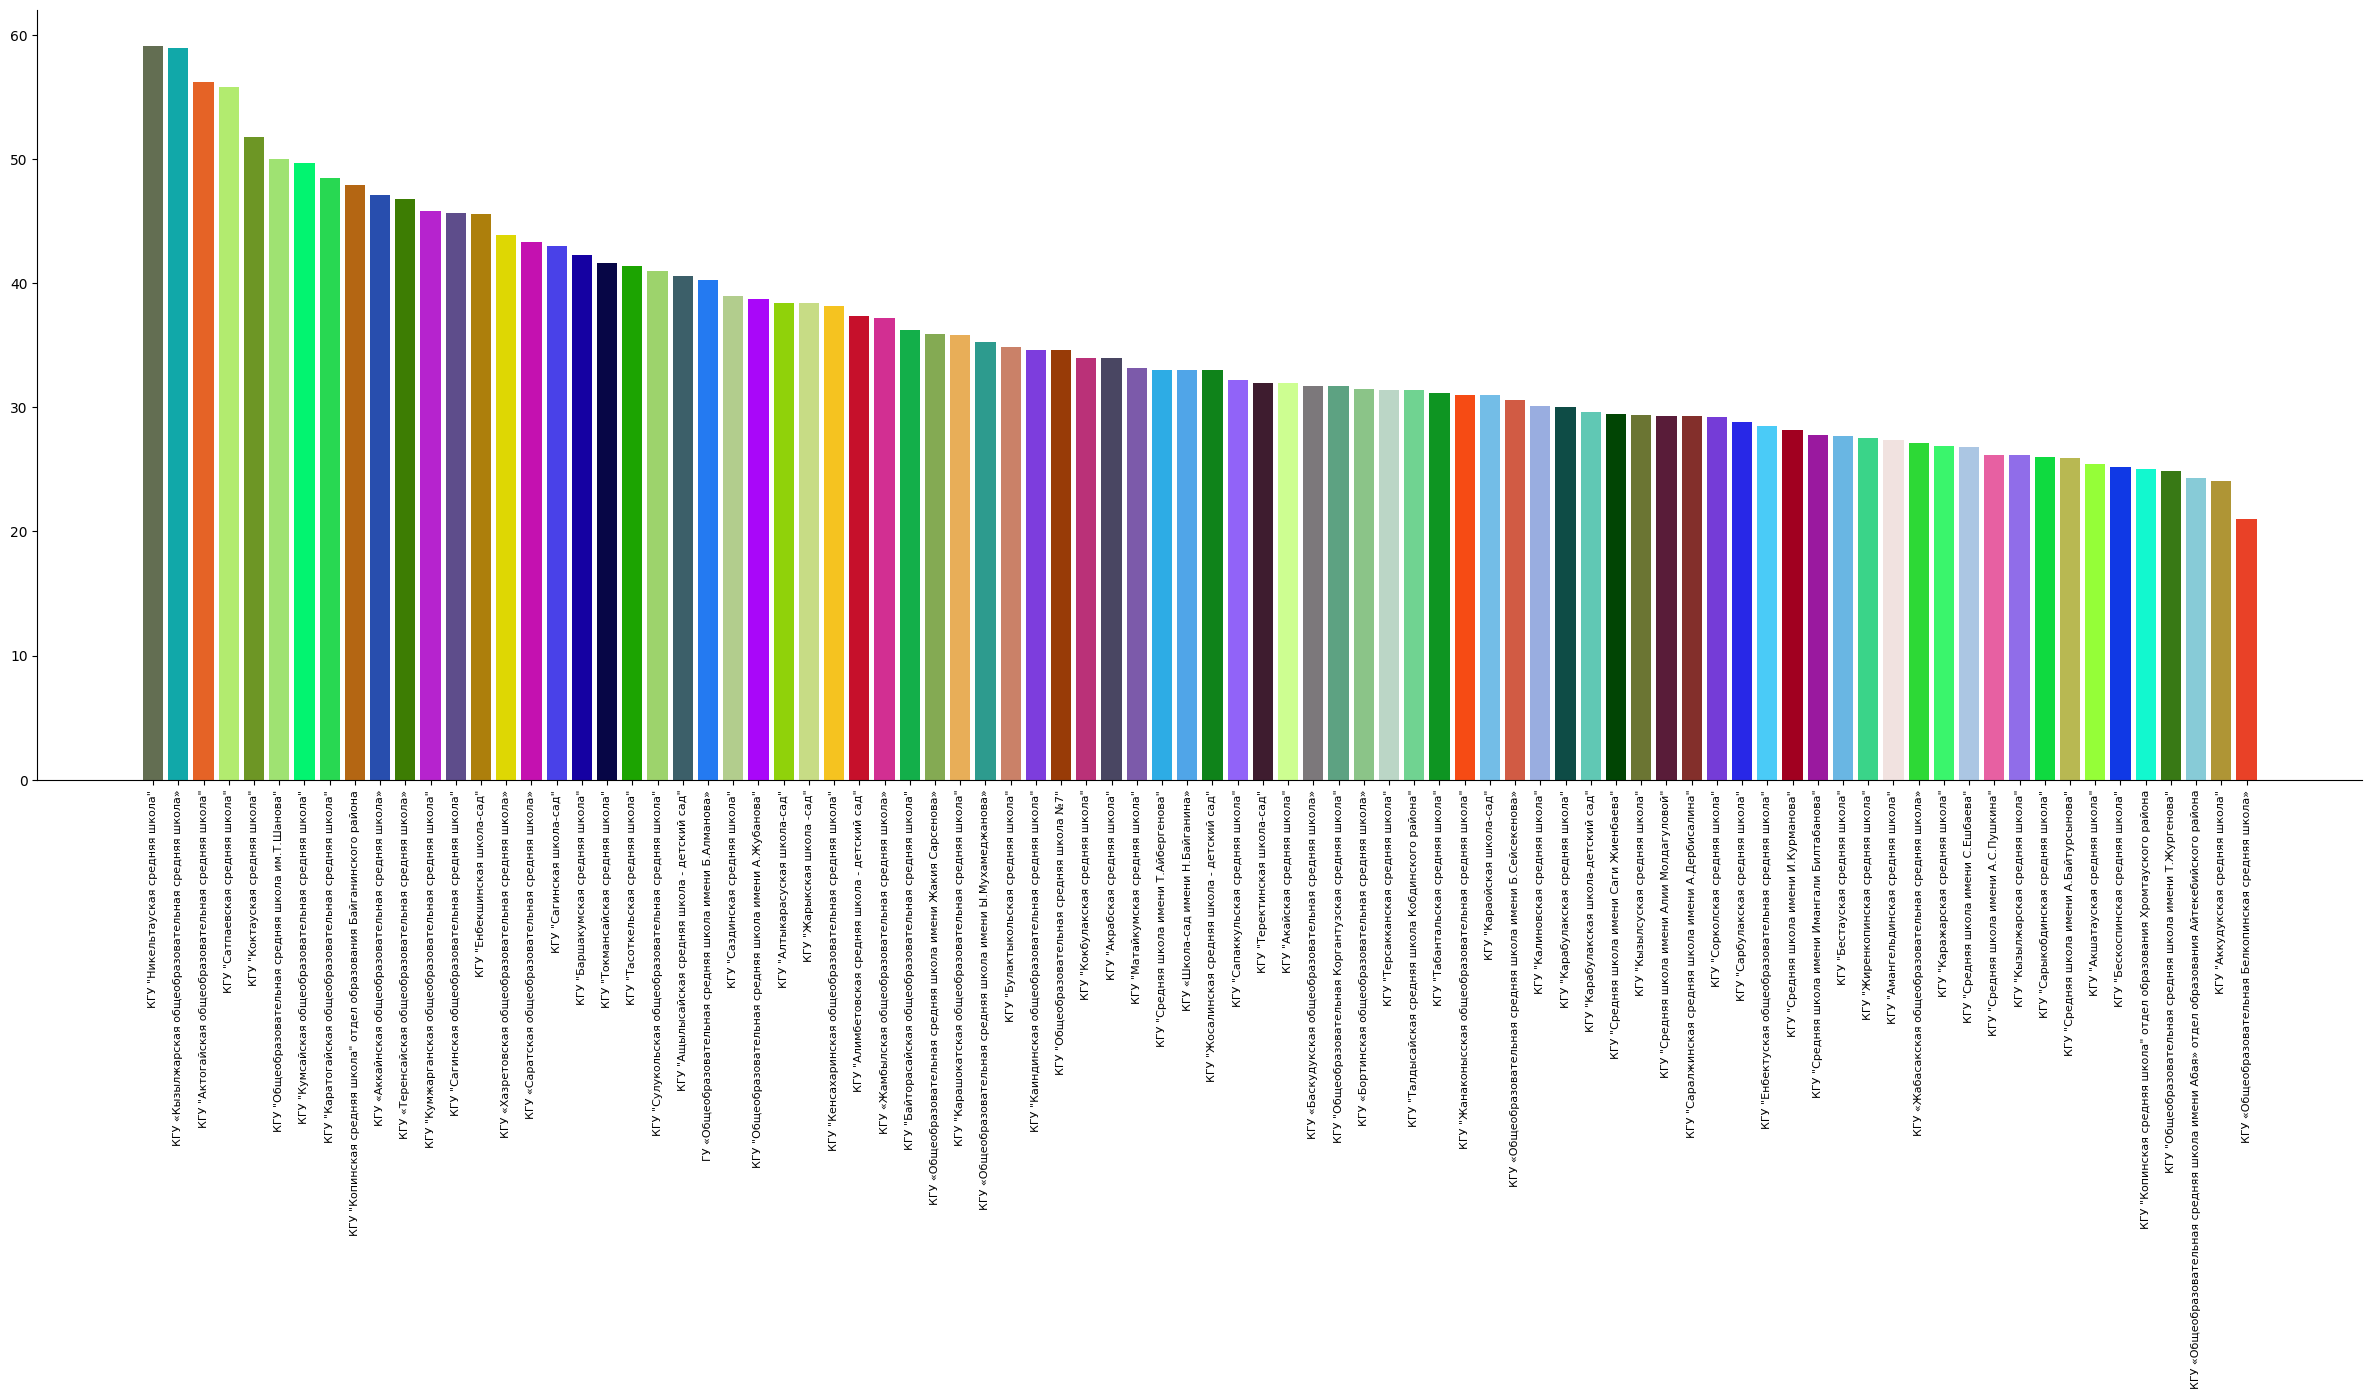

In [48]:
# Percent ranking by school
import matplotlib.pyplot as plt
import random

def generate_hex_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

num_colors = 141
hex_colors = [generate_hex_color() for _ in range(num_colors)]

total_ranking = merged_df.groupby(['school', 'grade'])['percent'].mean().round(1).reset_index().sort_values(by='percent', ascending=False)
for grade in grades:
    t = total_ranking[total_ranking['grade'] == grade][['school', 'percent']]
    school = t['school']
    percent = t['percent']

    print(school.nunique())

    plt.figure(figsize=(30, 10))

    unique_schools = school.unique()
    color_dict = {school: hex_colors[i % len(hex_colors)] for i, school in enumerate(unique_schools)}

    for s, p in zip(school, percent):
        plt.bar(s, p, color=color_dict[s])
        # plt.text(s, p + 0.5, f"{p}", ha='center', fontsize=4)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    plt.xticks(rotation=90, fontsize=8)
    # plt.yticks([])

    plt.savefig(rf"C:\Users\kassenov_r\report-automation\small_schools\school_bars\{grade}.png", bbox_inches='tight', dpi=600)
    plt.show()

Segmentation

In [167]:
for_seg = merged_df[merged_df['region'] != 'Актобе город']
seg = for_seg.groupby(['region', 'grade', 'subject'])['percent'].mean().reset_index().round(1).rename(columns={'percent' : 'mean'})
seg_min = for_seg.groupby(['region', 'school', 'grade', 'subject'])['percent'].min().reset_index().groupby(['region', 'grade', 'subject'])['percent'].mean().reset_index().round(1).rename(columns={'percent' : 'min'})
seg_max = for_seg.groupby(['region', 'school', 'grade', 'subject'])['percent'].max().reset_index().groupby(['region', 'grade', 'subject'])['percent'].mean().reset_index().round(1).rename(columns={'percent' : 'max'})
seg_result = pd.merge(pd.merge(seg, seg_max, on=['region', 'grade', 'subject']), seg_min, on=['region', 'grade', 'subject']).assign(range = lambda x: x['max'] - x['min']).drop(columns=['max', 'min'])
seg_result

,region,grade,subject,mean,range
0,Айтекебийский район,6,Английский язык,38.1,31.9
1,Айтекебийский район,6,Естествознание и познание мира,39.4,29.6
2,Айтекебийский район,6,Математика,36.1,34.6
3,Айтекебийский район,8,Английский язык,38.3,18.4
4,Айтекебийский район,8,Биология,35.3,22.7
...,...,...,...,...,...
151,Шалкарский район,10,Английский язык,38.7,25.0
152,Шалкарский район,10,Биология,41.6,11.5
153,Шалкарский район,10,Математика,43.7,18.5
154,Шалкарский район,10,Физика,49.1,20.0


In [178]:
# Segmentation table (Ситуативное полотно)
segment_dict = {}


subject_order = {
    6 : ['Математика', 'Естествознание и познание мира', 'Английский язык'],
    8 : ['Математика', 'Биология', 'Физика', 'Химия', 'Английский язык'],
    10 : ['Математика', 'Биология', 'Физика', 'Химия', 'Английский язык']
}

for grade in grades:
    for subject in subjects:
        t = seg_result[(seg_result['grade'] == grade) & (seg_result['subject'] == subject)][['region', 'subject', 'mean', 'range']]
        g_mean = seg_result[seg_result['subject'] == subject]['mean'].mean()
        g_range_mean = seg_result[seg_result['subject'] == subject]['range'].mean()

        if not t.empty:
            for index, row in t.iterrows():
                mean_set = {1, 2} if t.loc[index, 'mean'] > g_mean else {3, 4}
                range_set = {2, 4} if t.loc[index, 'range'] > g_range_mean else {1, 3}

                intersection = mean_set.intersection(range_set)
                num = next(iter(intersection))

                t.loc[index, 'segment'] = num
        pivot = t.pivot_table(index='region', columns='subject', values='segment')
        pivot = pivot.reindex(columns=subject_order[grade])
        pivot.sort_values(by='Математика', inplace=True)
        display(pivot)
    segment_dict[grade] = pivot

# Saving the tables to xlsx
# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\segmentation_table_total.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, table in segment_dict.items():
#         table.to_excel(writer, sheet_name=f"{grade}")

subject,Математика,Естествознание и познание мира,Английский язык
region,,,
Каргалинский район,2.0,4.0,4.0
Мугалжарский район,2.0,1.0,1.0
Хромтауский район,2.0,2.0,2.0
Шалкарский район,2.0,2.0,1.0
Иргизский район,3.0,4.0,4.0
Мартукский район,3.0,1.0,3.0
Айтекебийский район,4.0,2.0,2.0
Алгинский район,4.0,2.0,4.0
Байганинский район,4.0,3.0,3.0


subject,Математика,Биология,Физика,Химия,Английский язык
region,,,,,
Шалкарский район,1.0,1.0,1.0,1.0,1.0
Мугалжарский район,2.0,1.0,1.0,2.0,2.0
Хромтауский район,2.0,1.0,1.0,2.0,2.0
Айтекебийский район,3.0,3.0,2.0,1.0,1.0
Алгинский район,3.0,3.0,3.0,1.0,3.0
Каргалинский район,3.0,2.0,4.0,2.0,4.0
Темирский район,3.0,1.0,2.0,2.0,1.0
Хобдинский район,3.0,1.0,3.0,1.0,3.0
Байганинский район,4.0,1.0,2.0,2.0,3.0


subject,Математика,Биология,Физика,Химия,Английский язык
region,,,,,
Мартукский район,1.0,1.0,1.0,1.0,2.0
Хромтауский район,1.0,3.0,1.0,3.0,1.0
Шалкарский район,1.0,1.0,1.0,3.0,1.0
Мугалжарский район,2.0,1.0,2.0,4.0,2.0
Алгинский район,3.0,3.0,3.0,3.0,4.0
Байганинский район,3.0,3.0,3.0,3.0,3.0
Каргалинский район,3.0,2.0,1.0,1.0,2.0
Темирский район,3.0,2.0,3.0,1.0,1.0
Уилский район,3.0,3.0,4.0,4.0,4.0


In [177]:
# Tables for segmentation with scatter plot
seg_dict = {}
for grade in grades:
    sub_dict = {}
    for subject in subjects:
        t = seg_result[(seg_result['grade'] == grade) & (seg_result['subject'] == subject)][['region', 'mean', 'range']]
        if not t.empty:
            mean_mean = t['mean'].mean()
            range_mean = t['range'].mean()
            to_concat = pd.DataFrame({'region' : ['.'], 'mean' : [mean_mean], 'range' : [range_mean]})
            result = pd.concat([t, to_concat]).round(1)

            sub_dict[subject] = result    
    seg_dict[grade] = sub_dict

# Saving the tables to xlsx
# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\segmentation_tables.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, subs in seg_dict.items():
#         for sub, table in subs.items():
#             table.to_excel(writer, sheet_name=f"{grade}_{sub}", index=False)

c:\Users\kassenov_r\report-automation\myenv\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


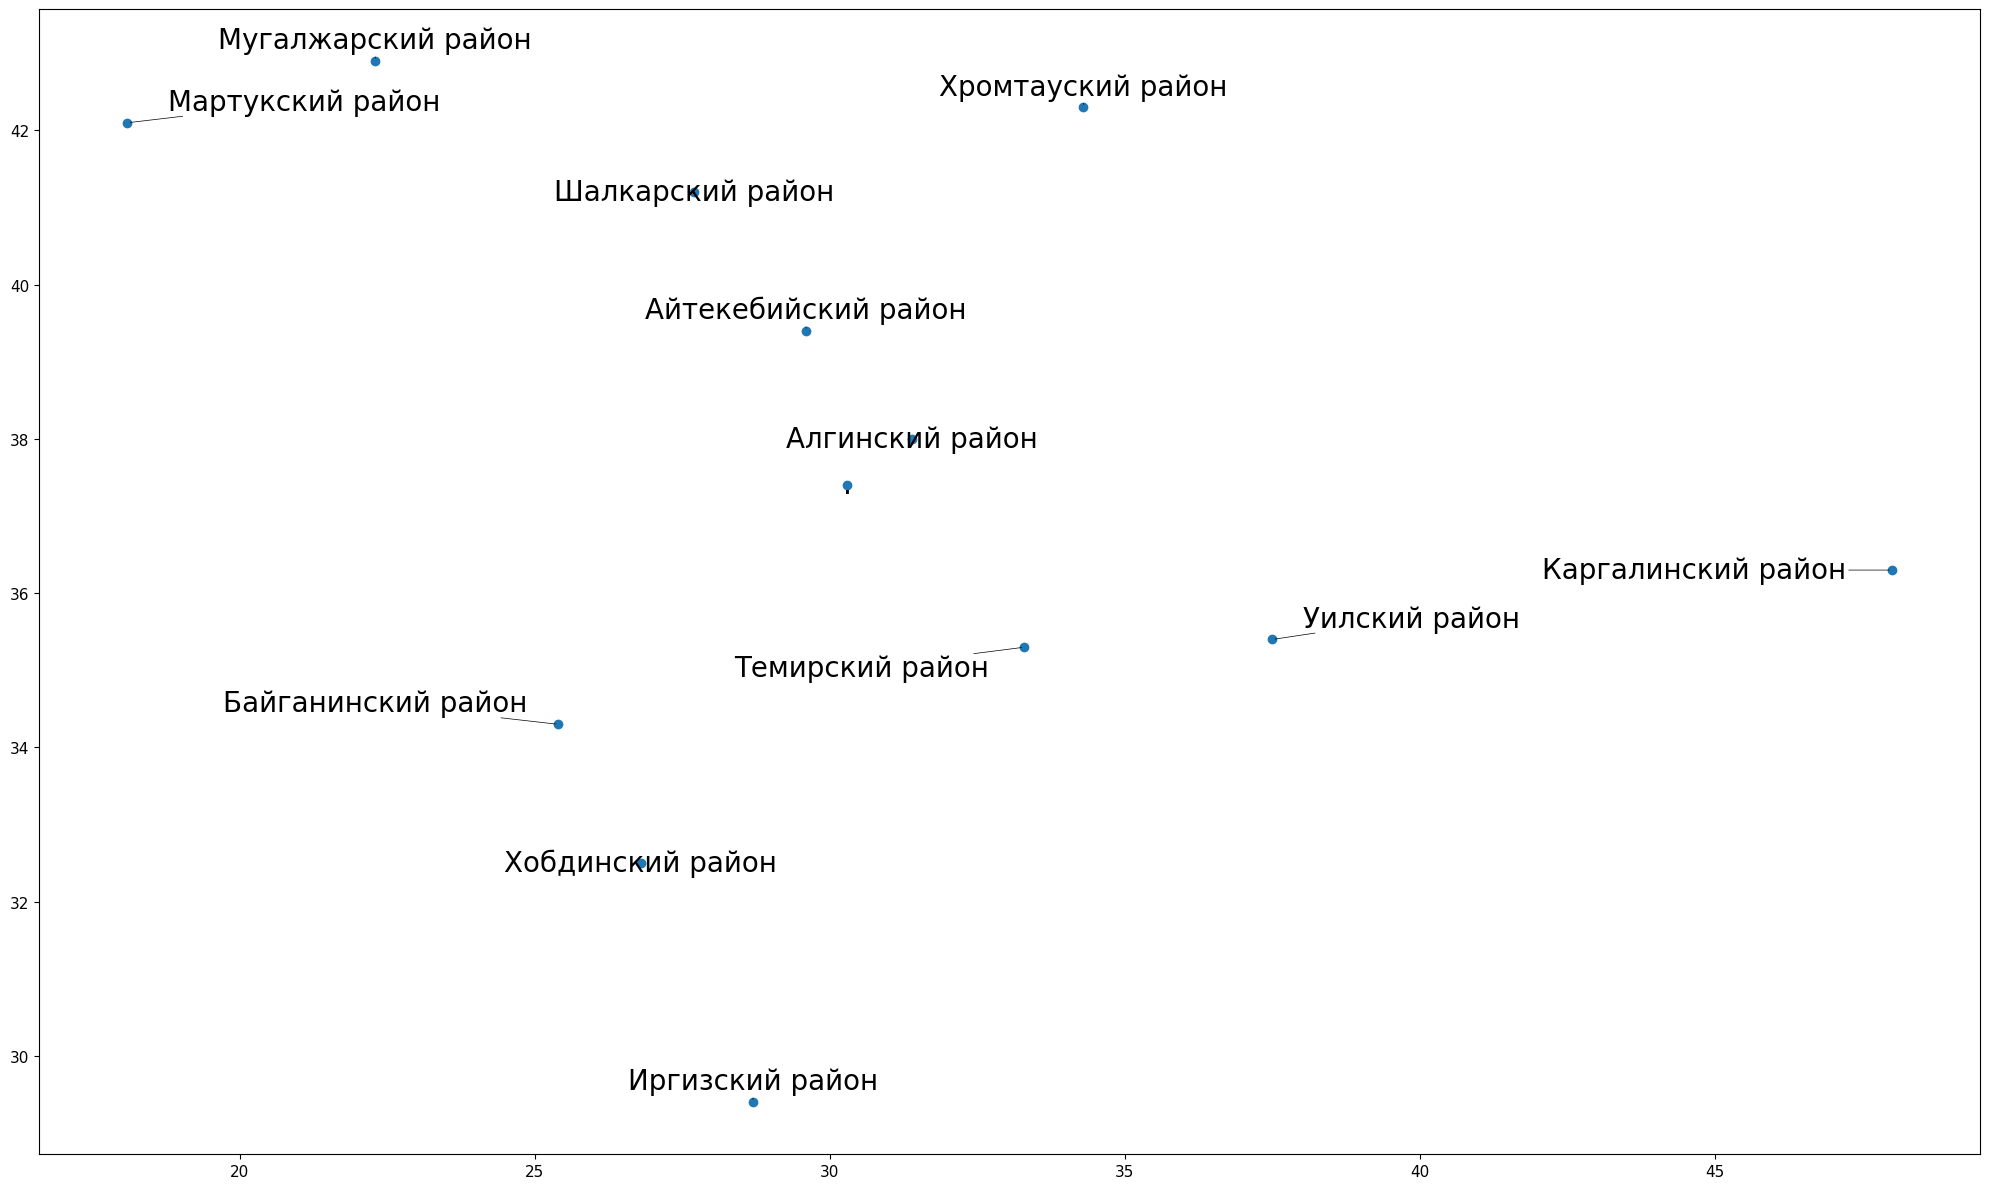

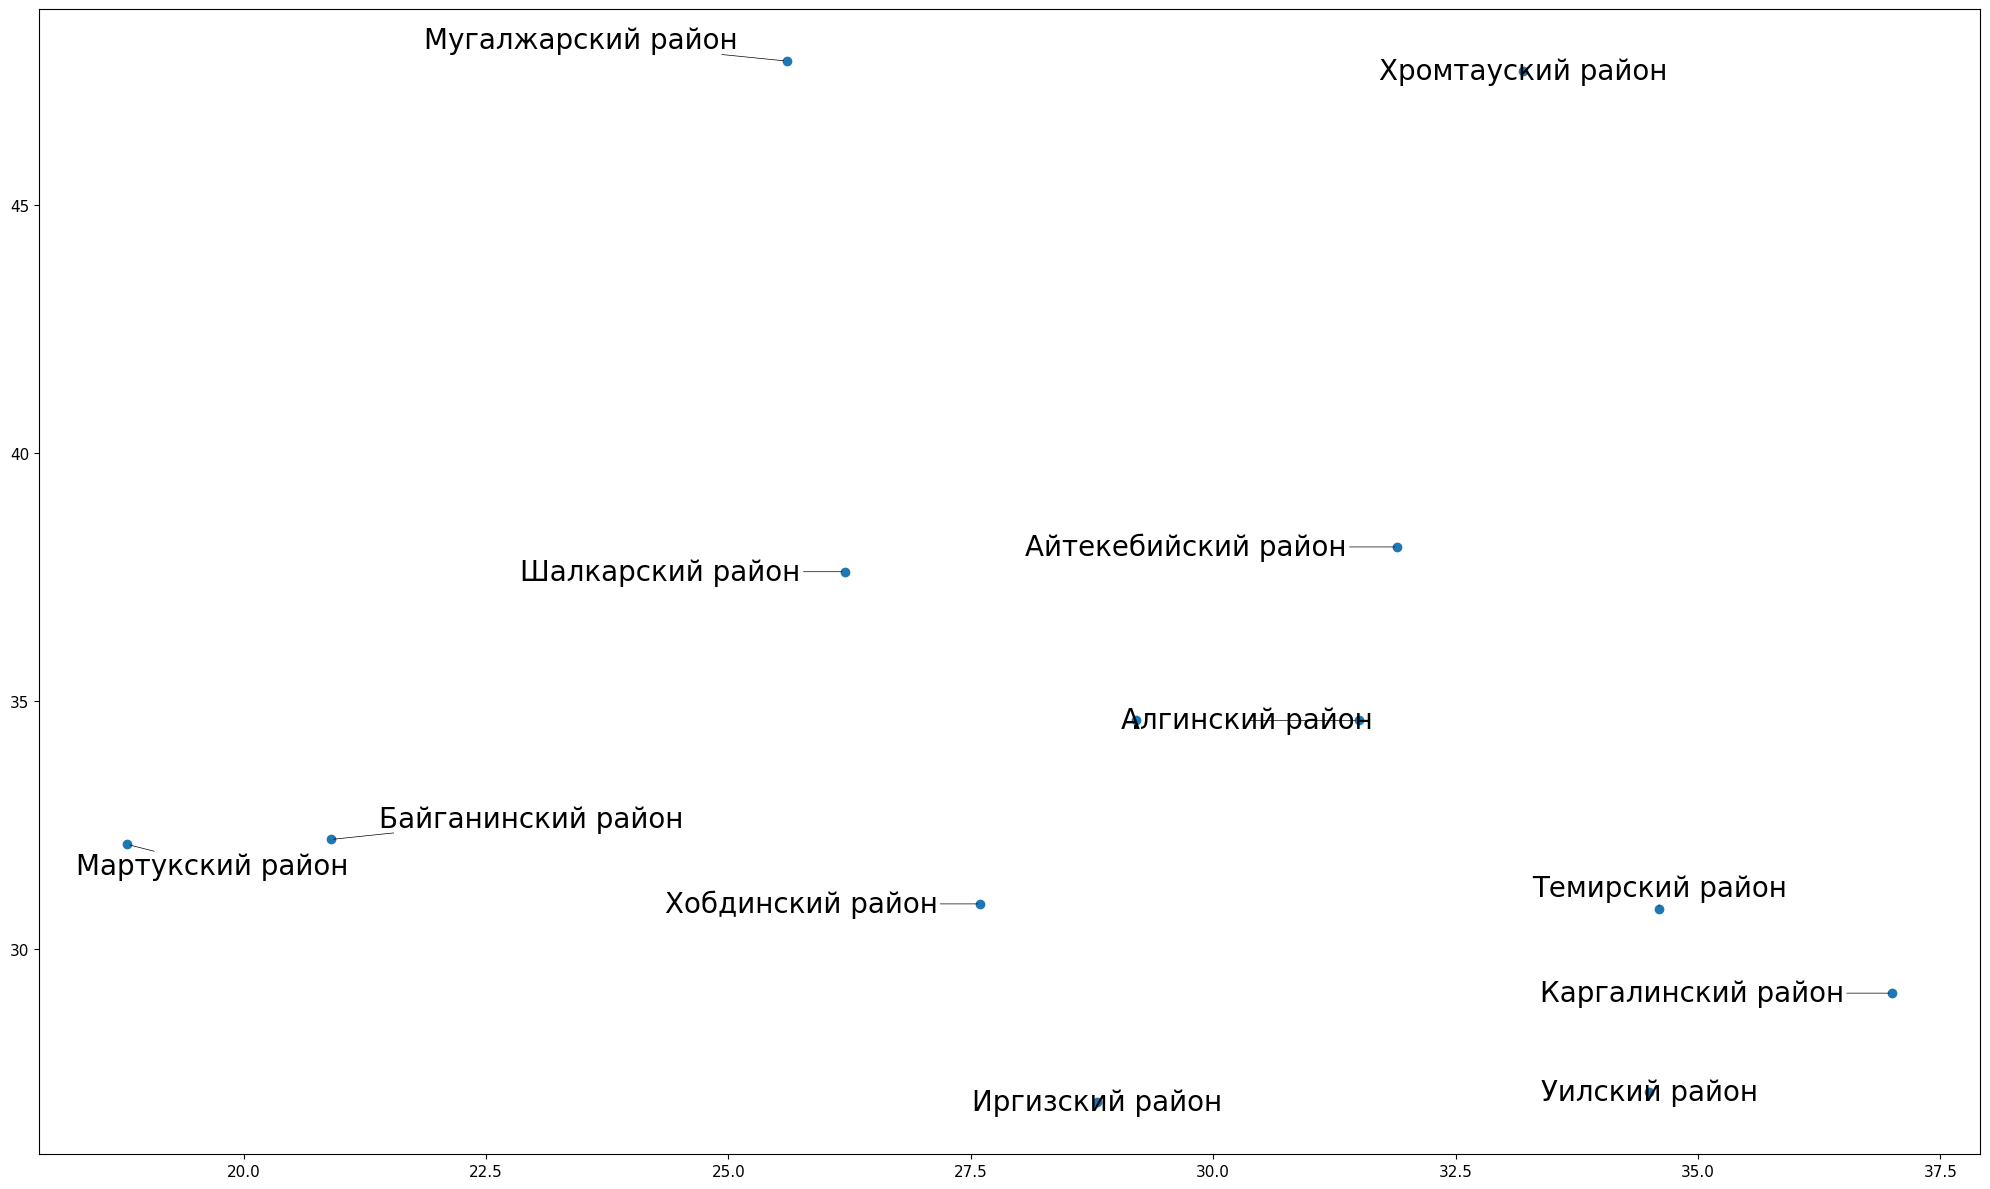

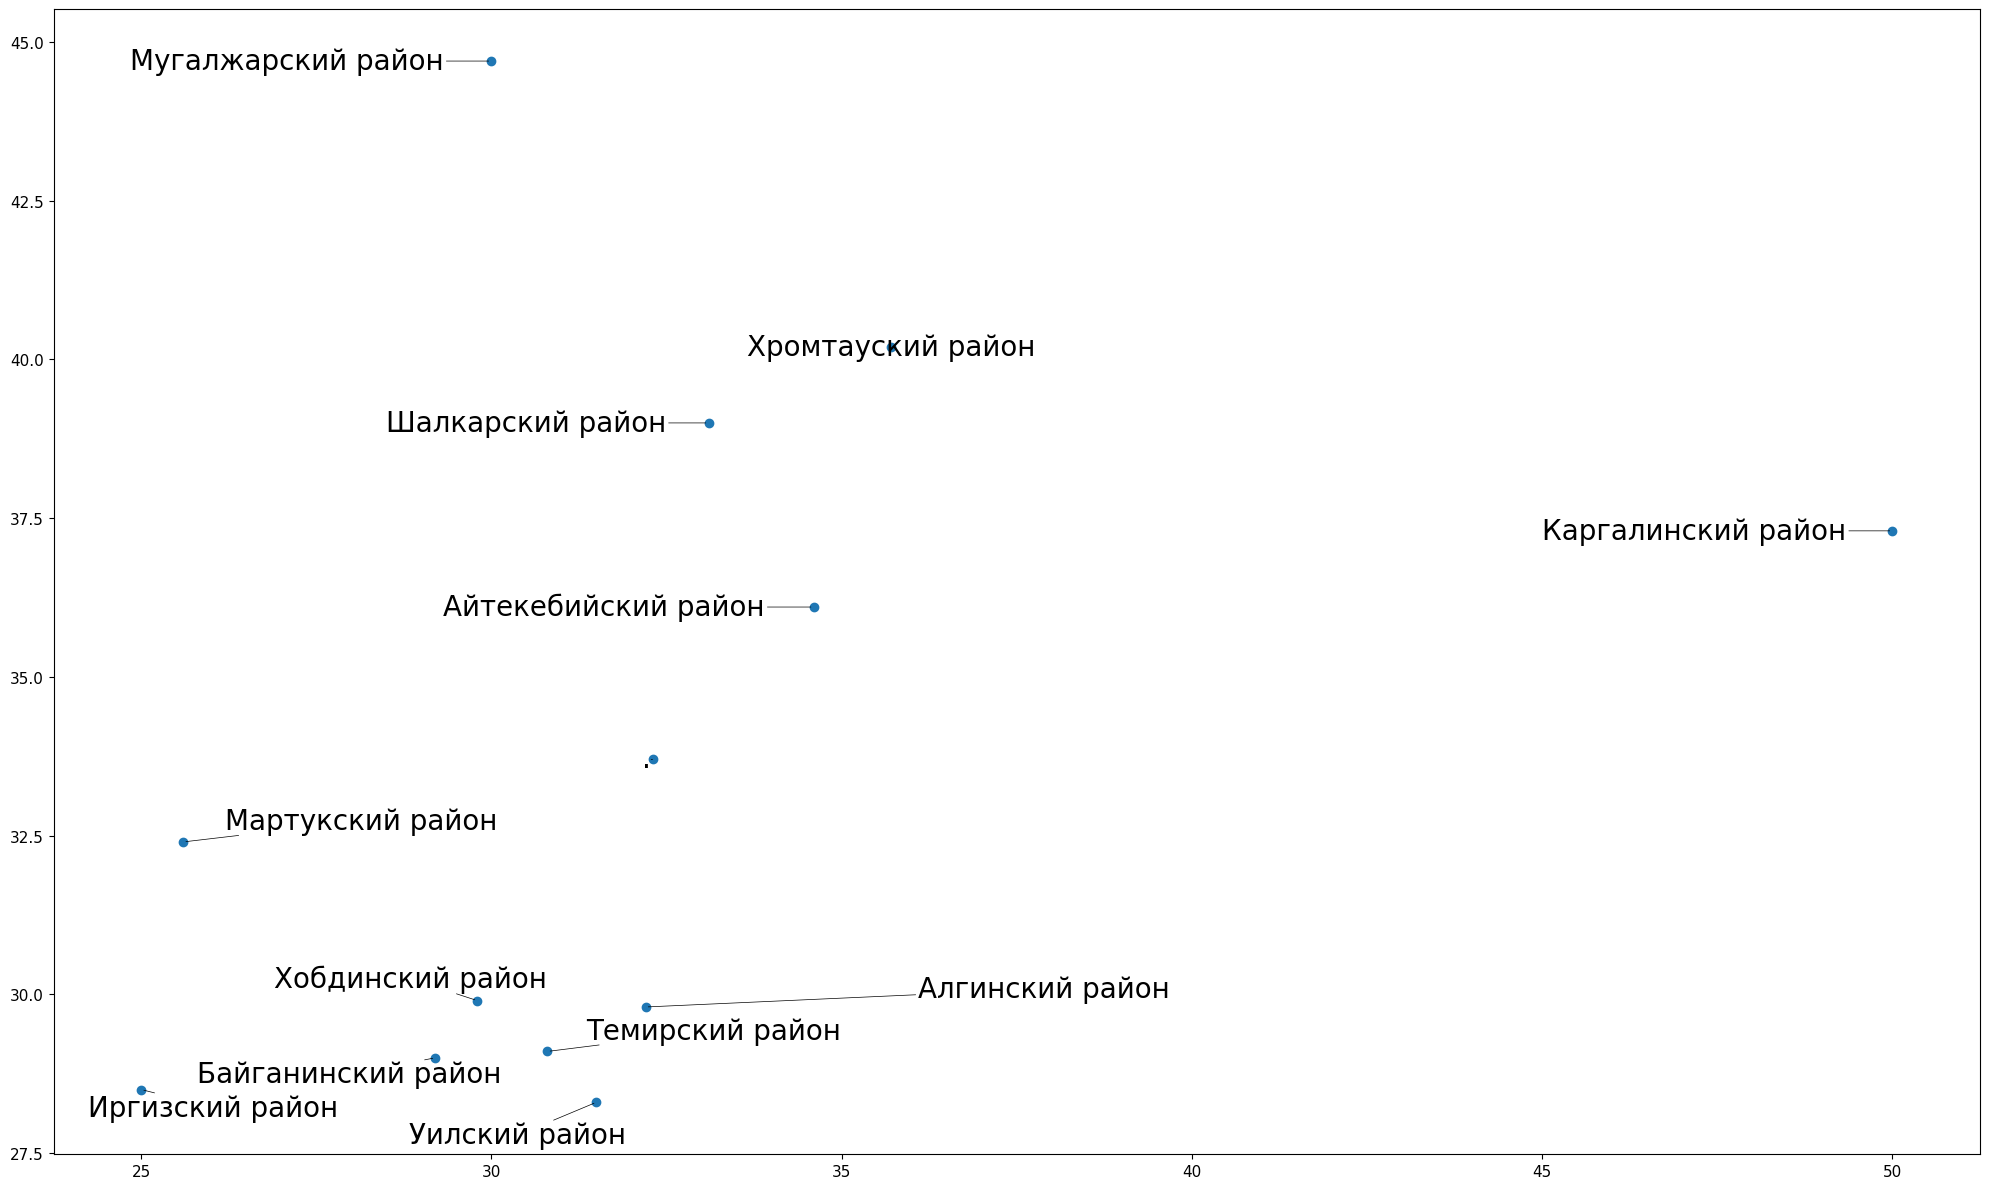

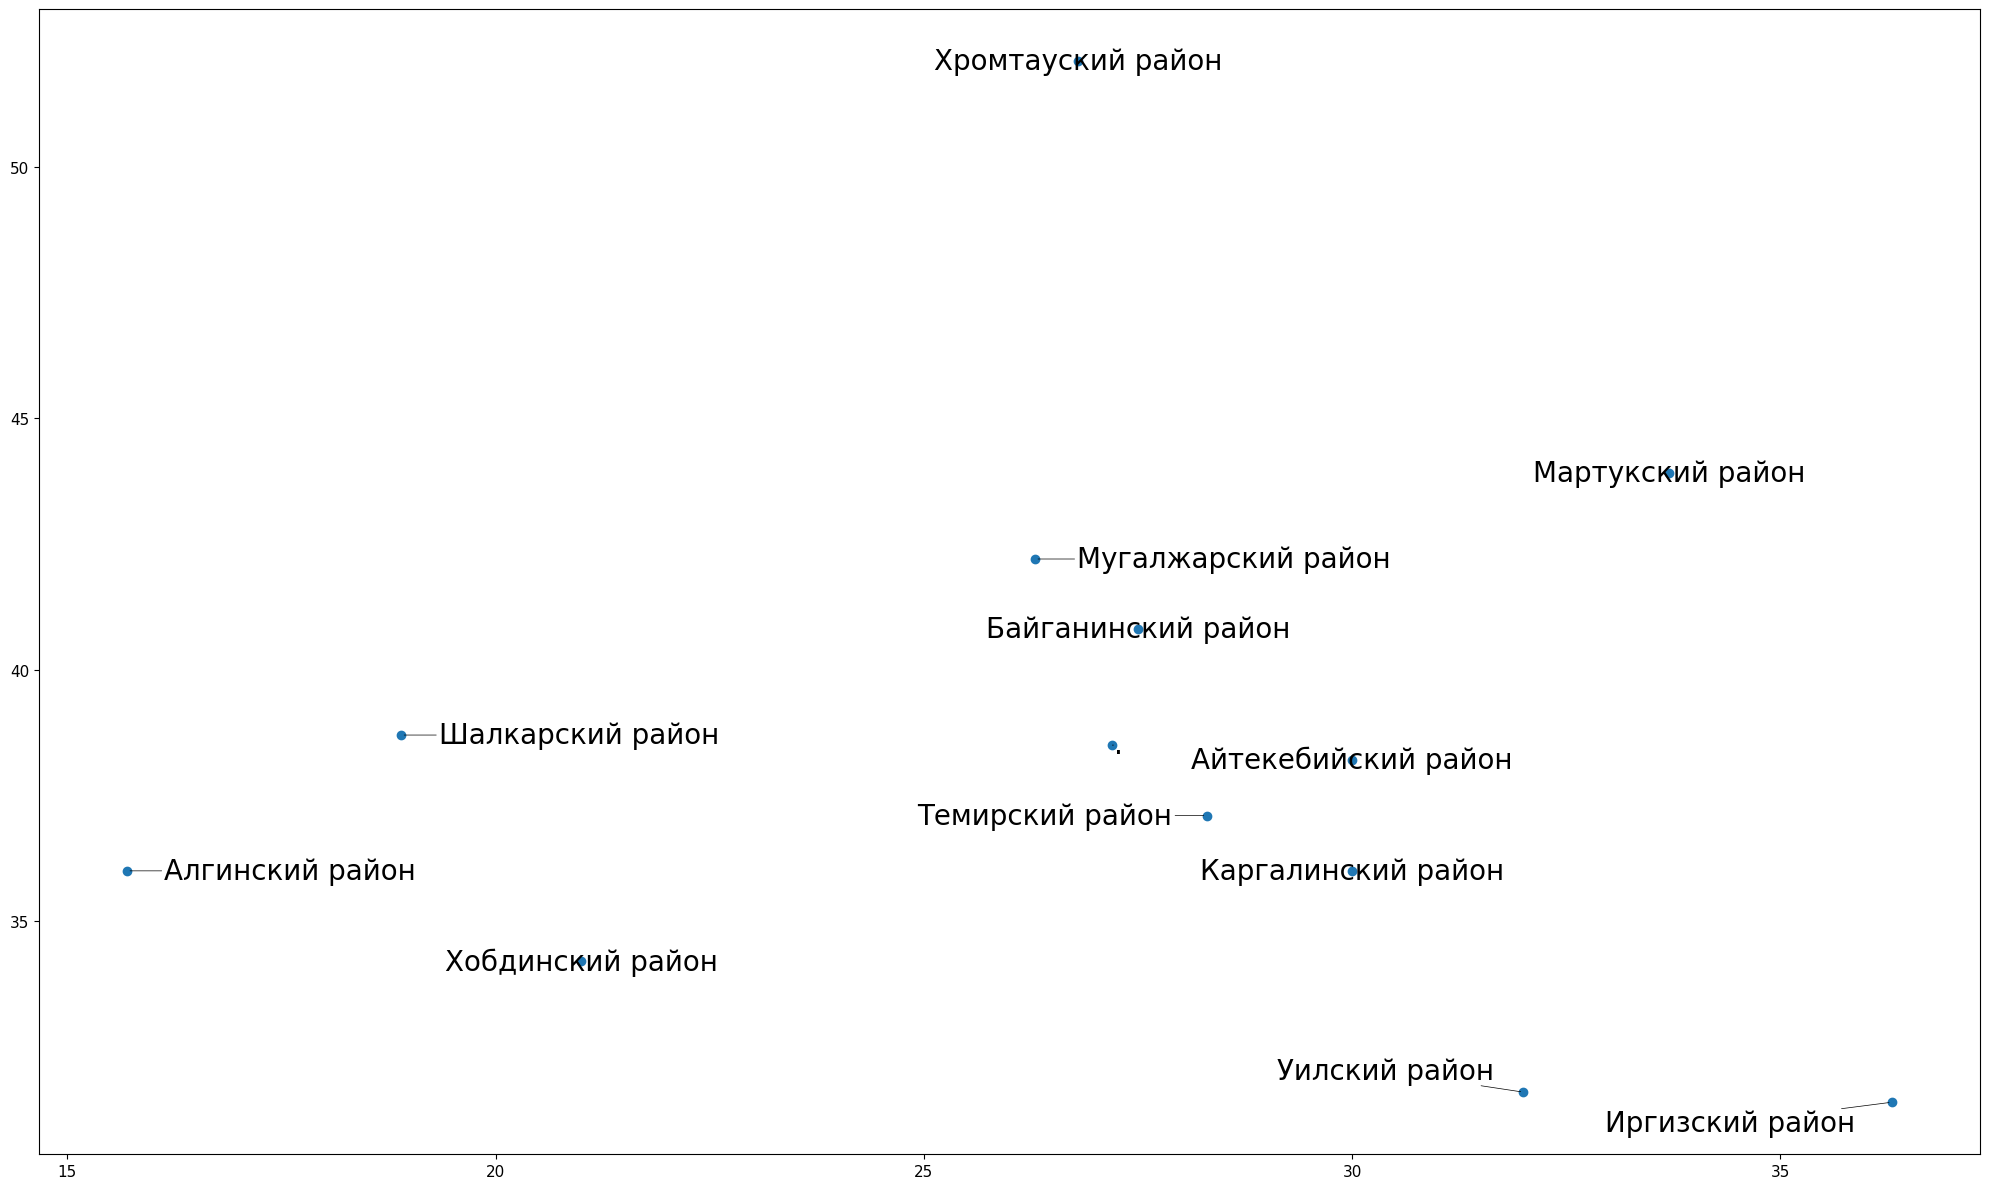

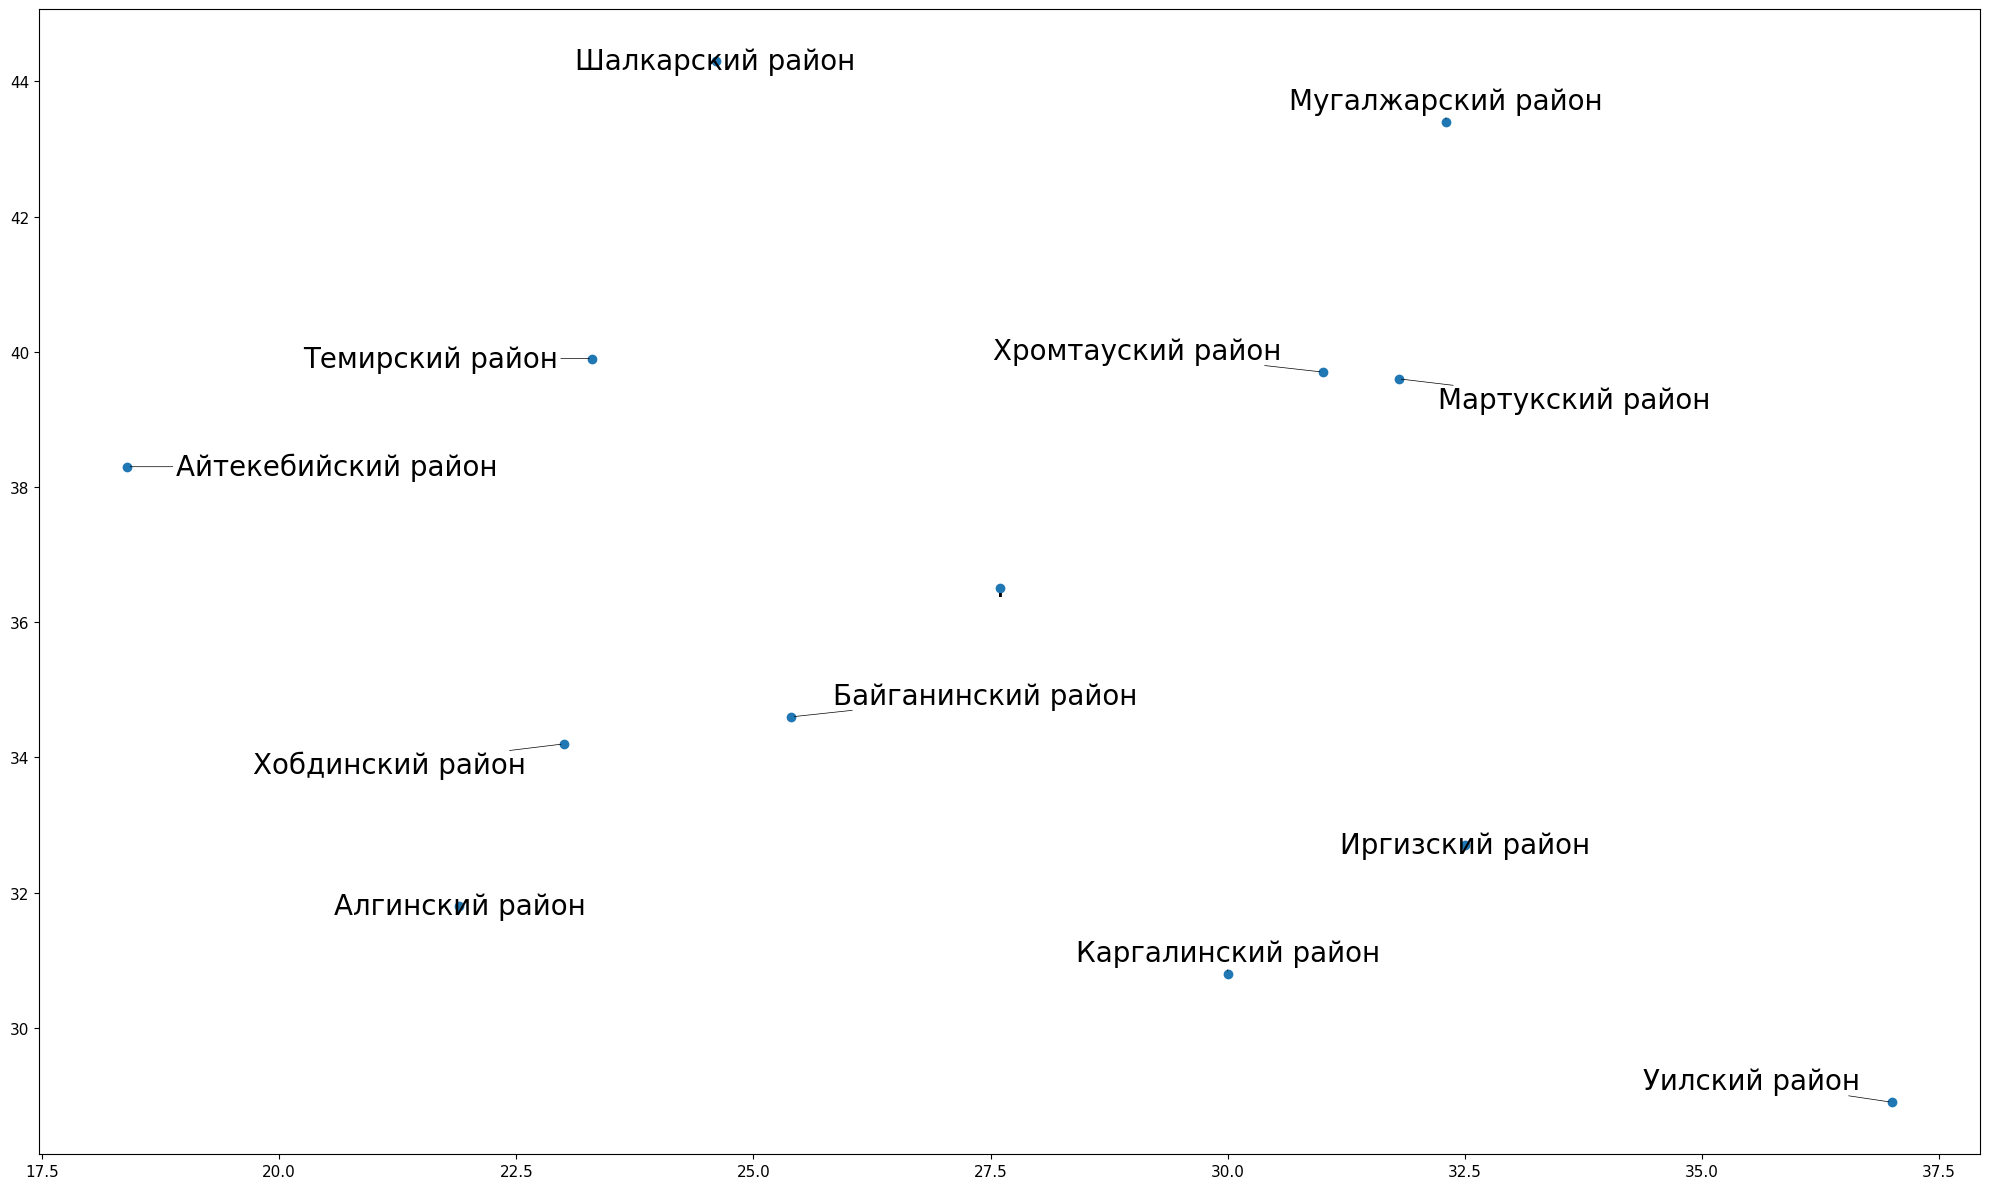

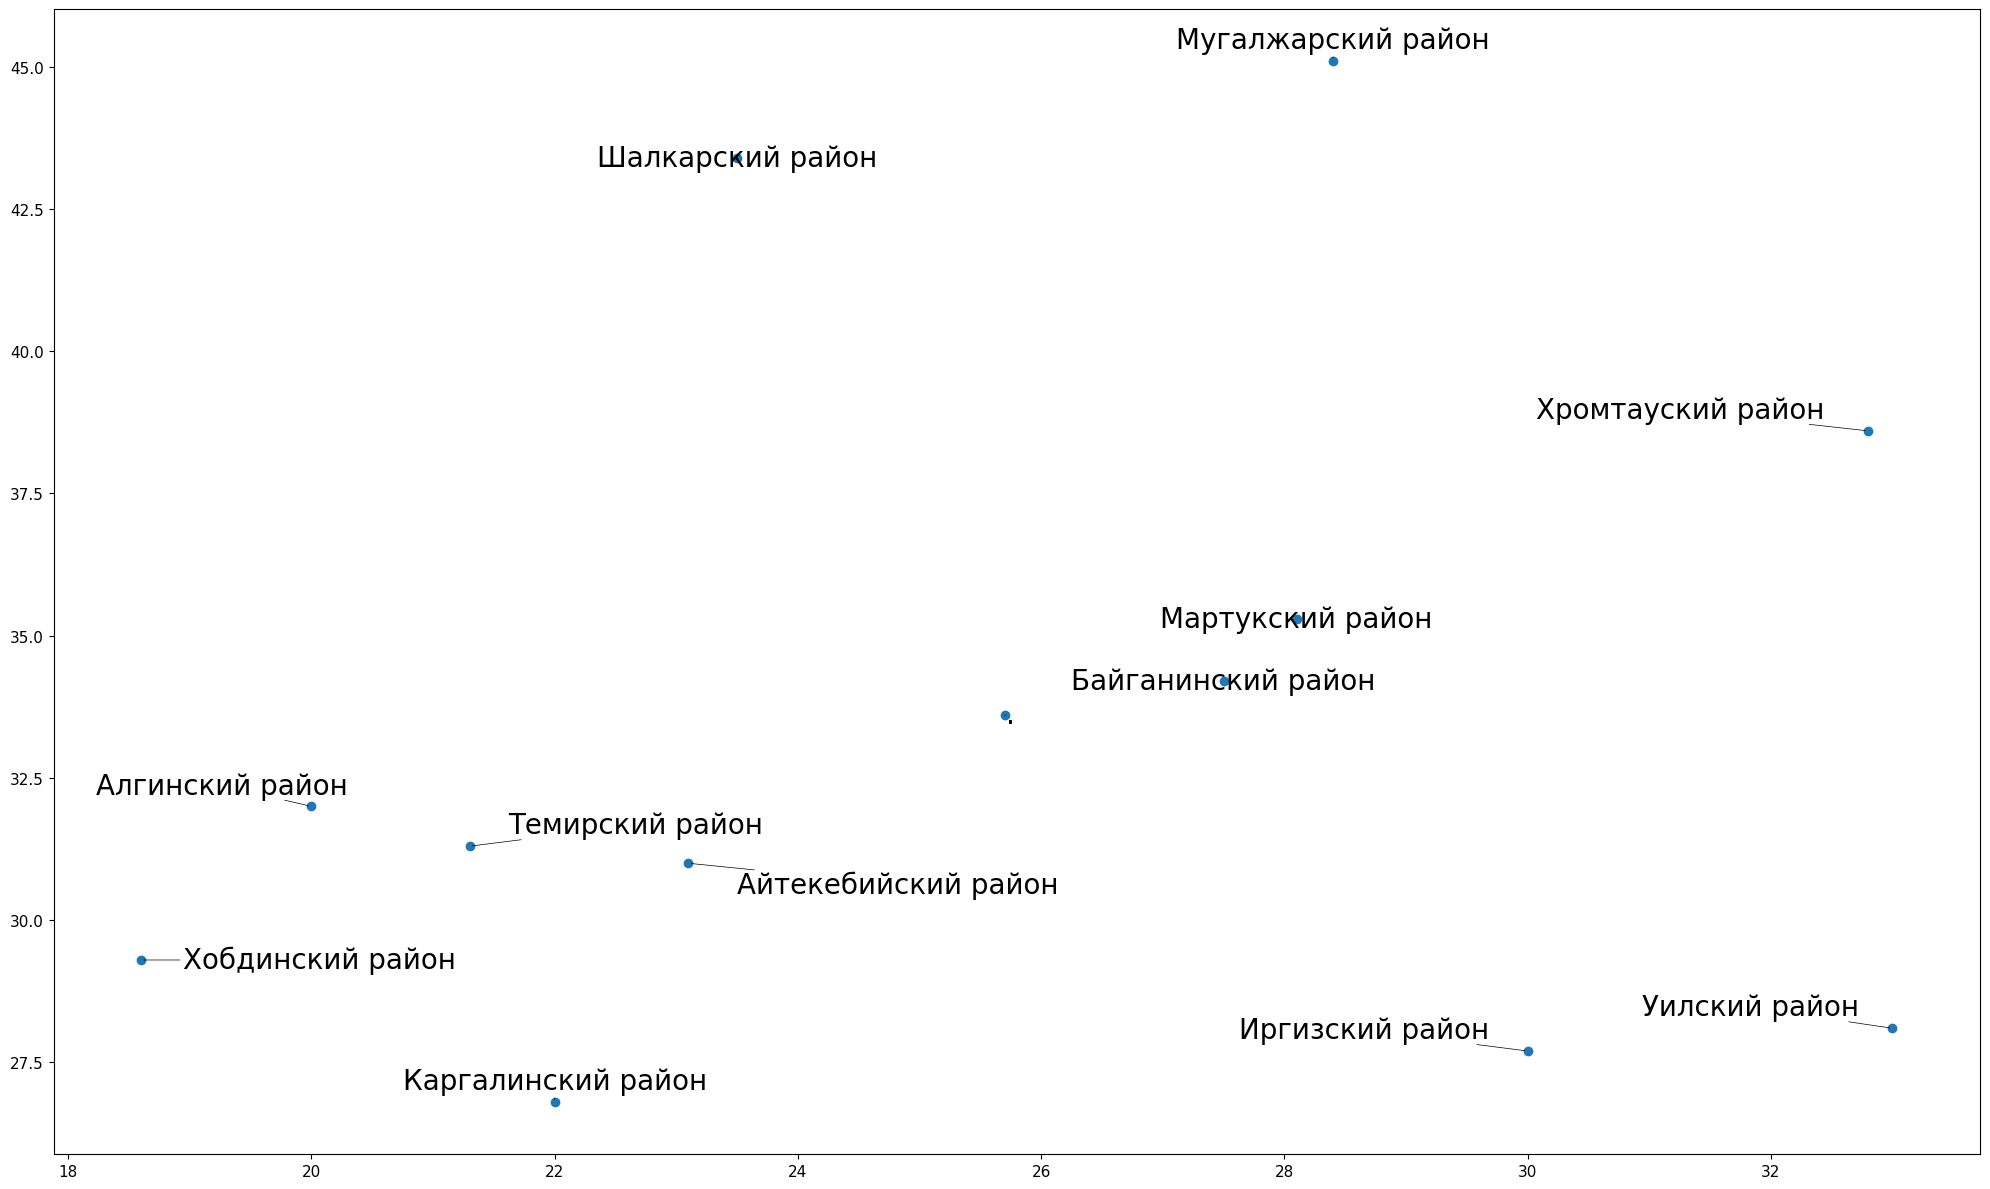

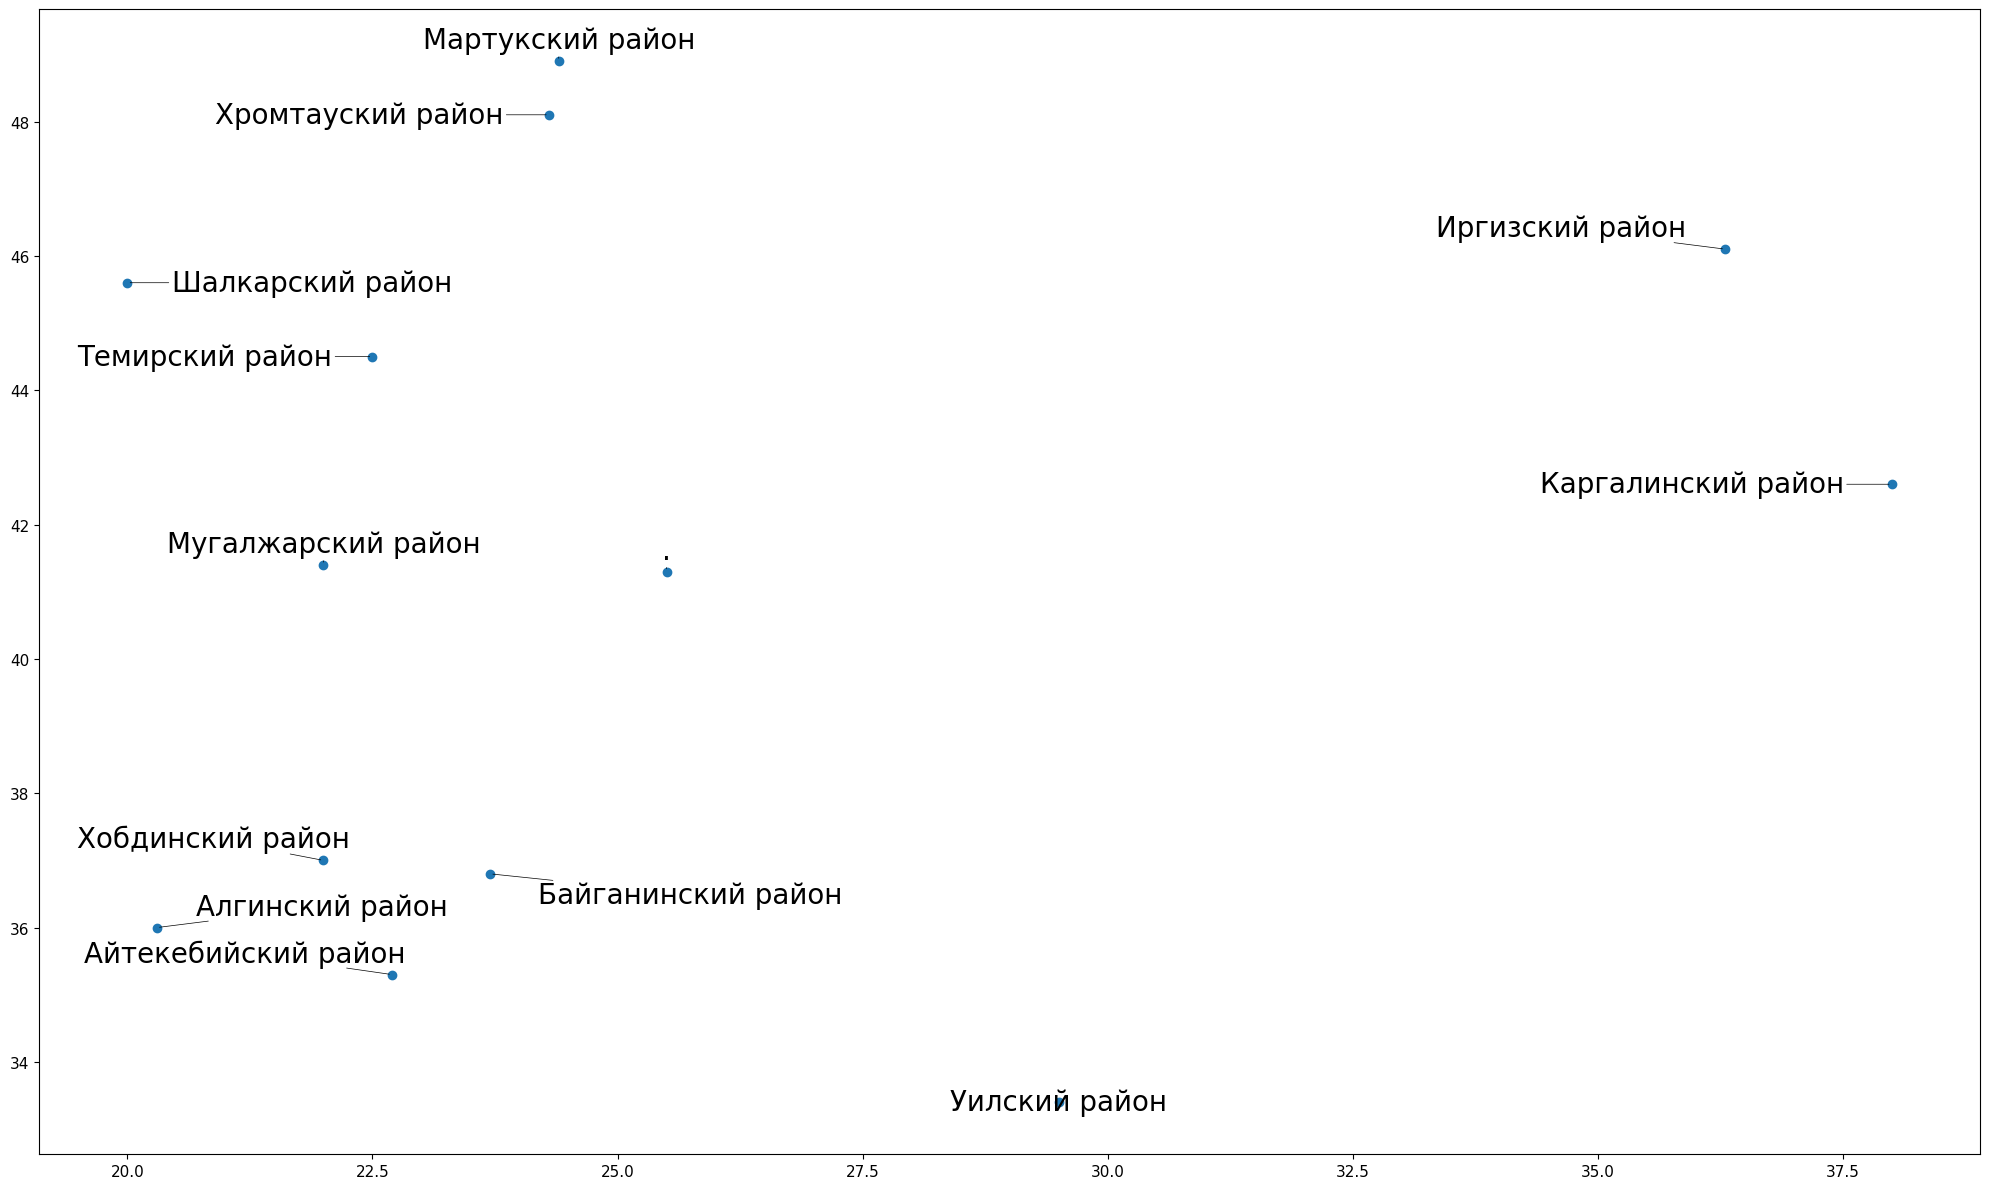

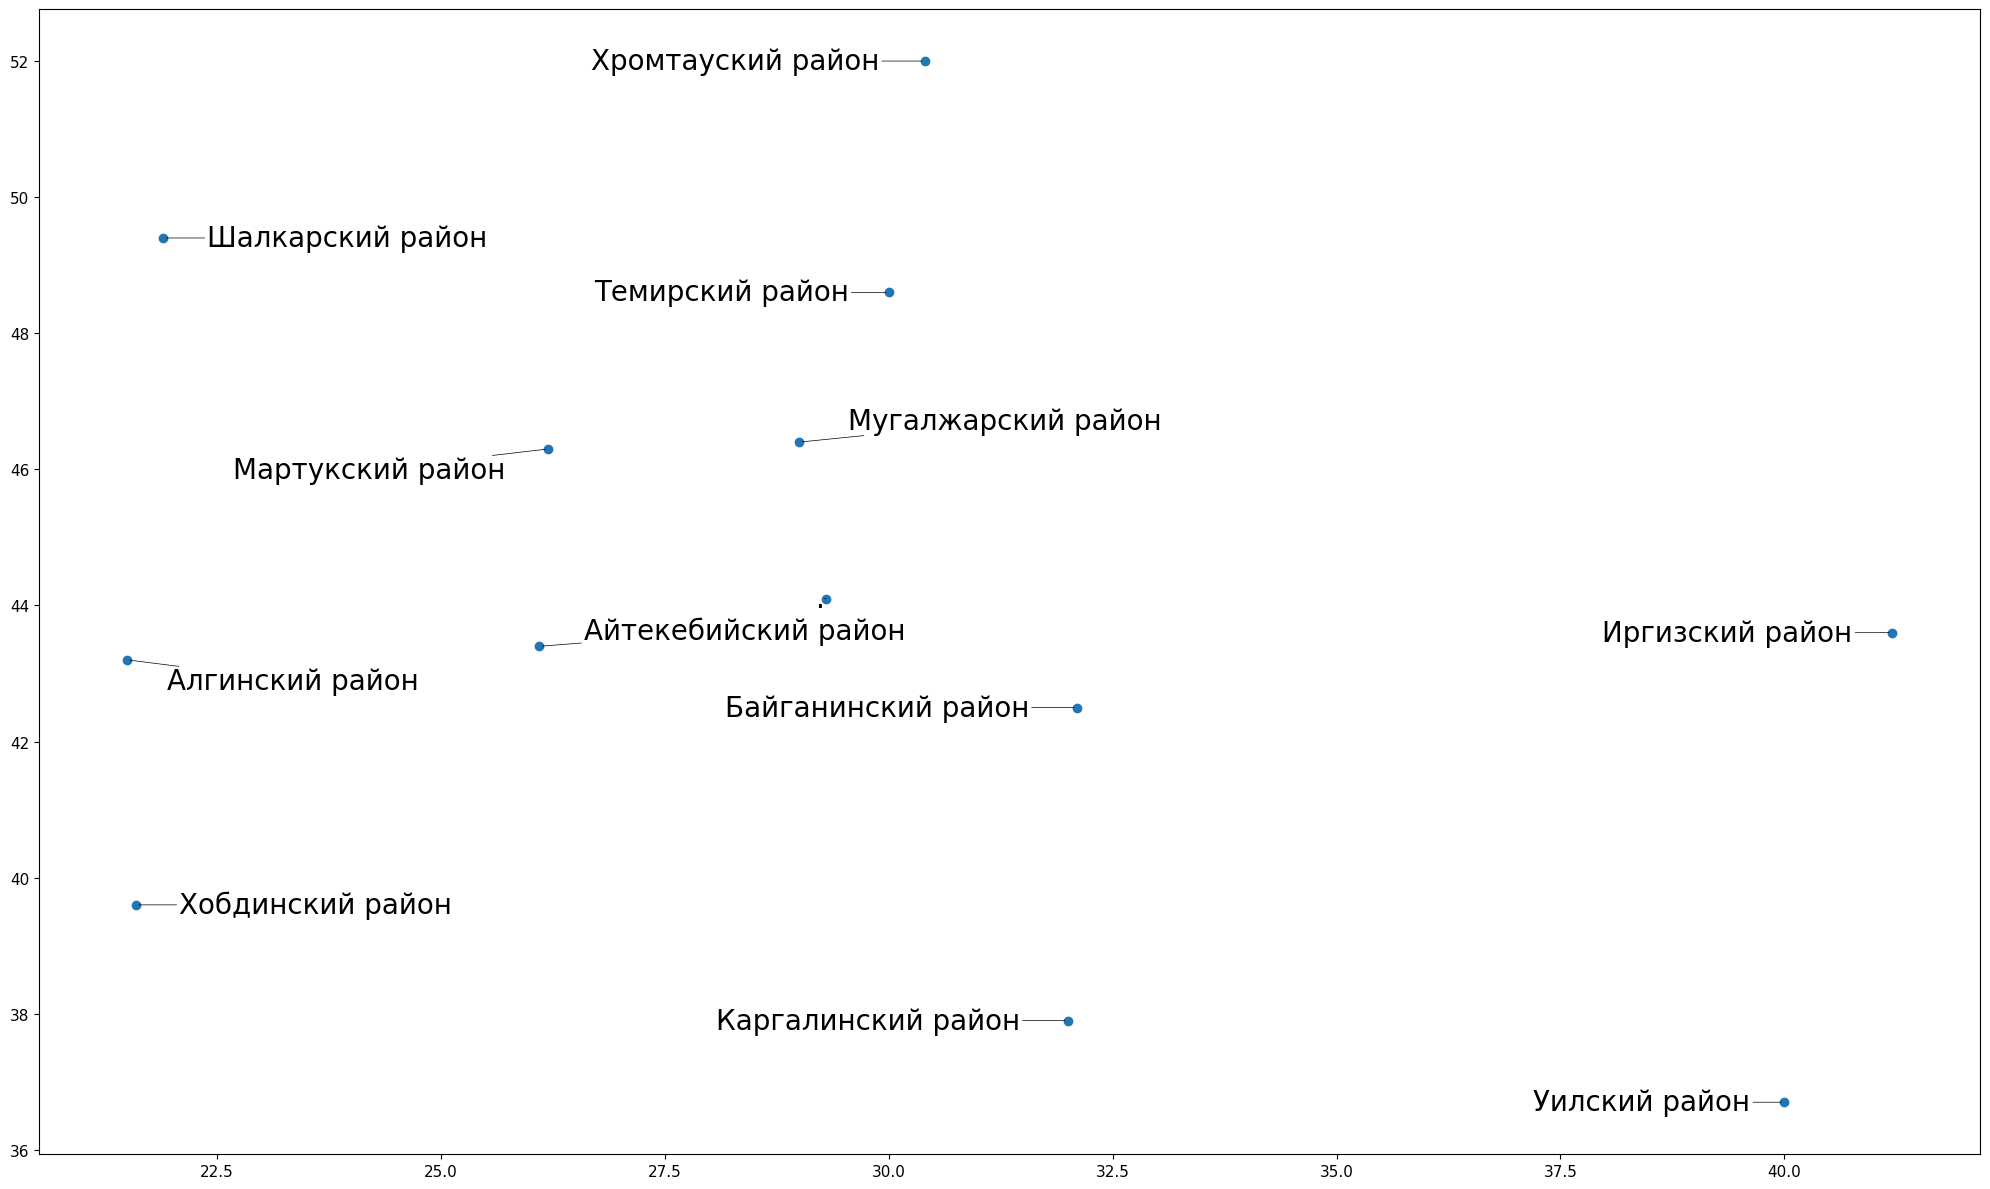

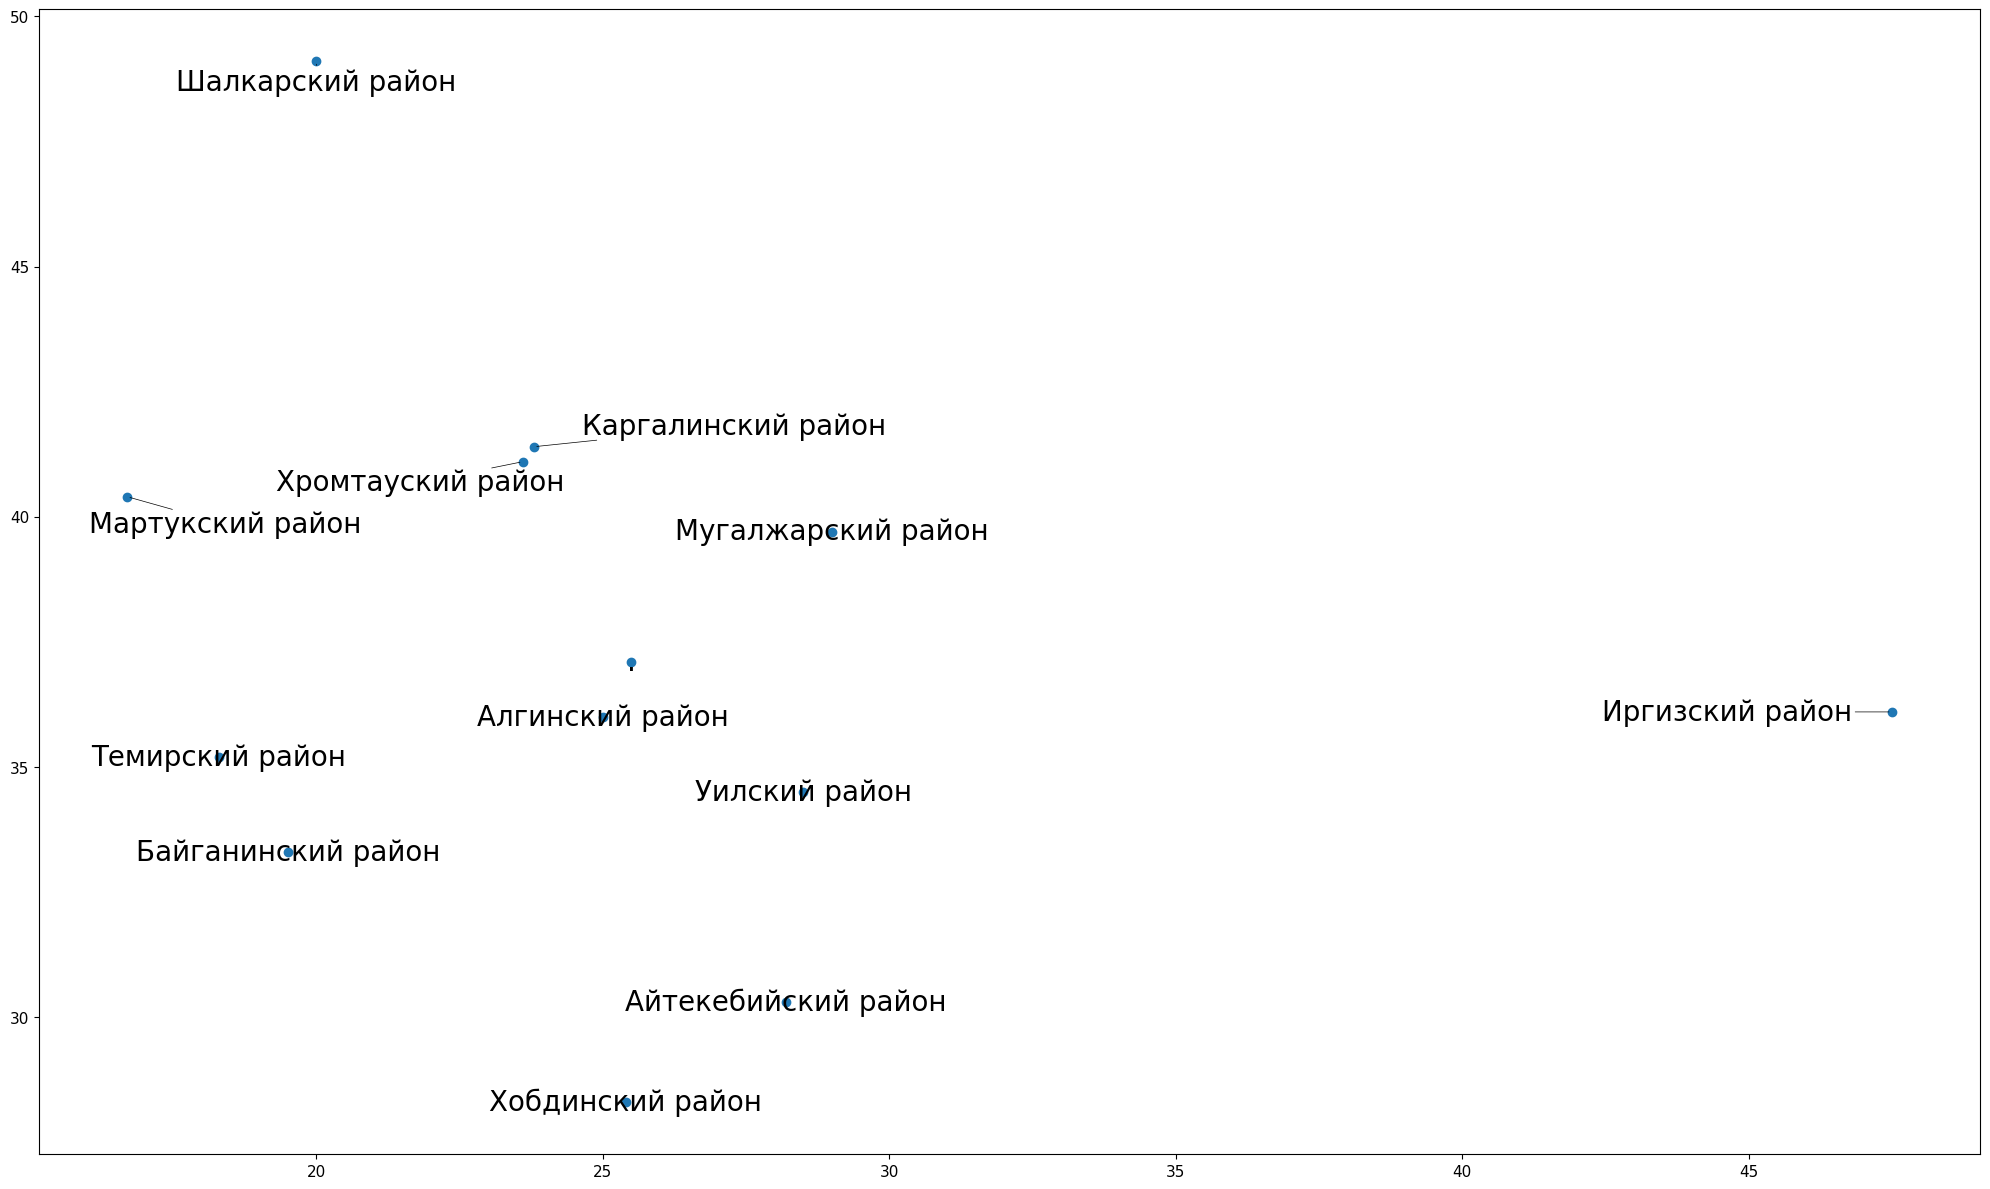

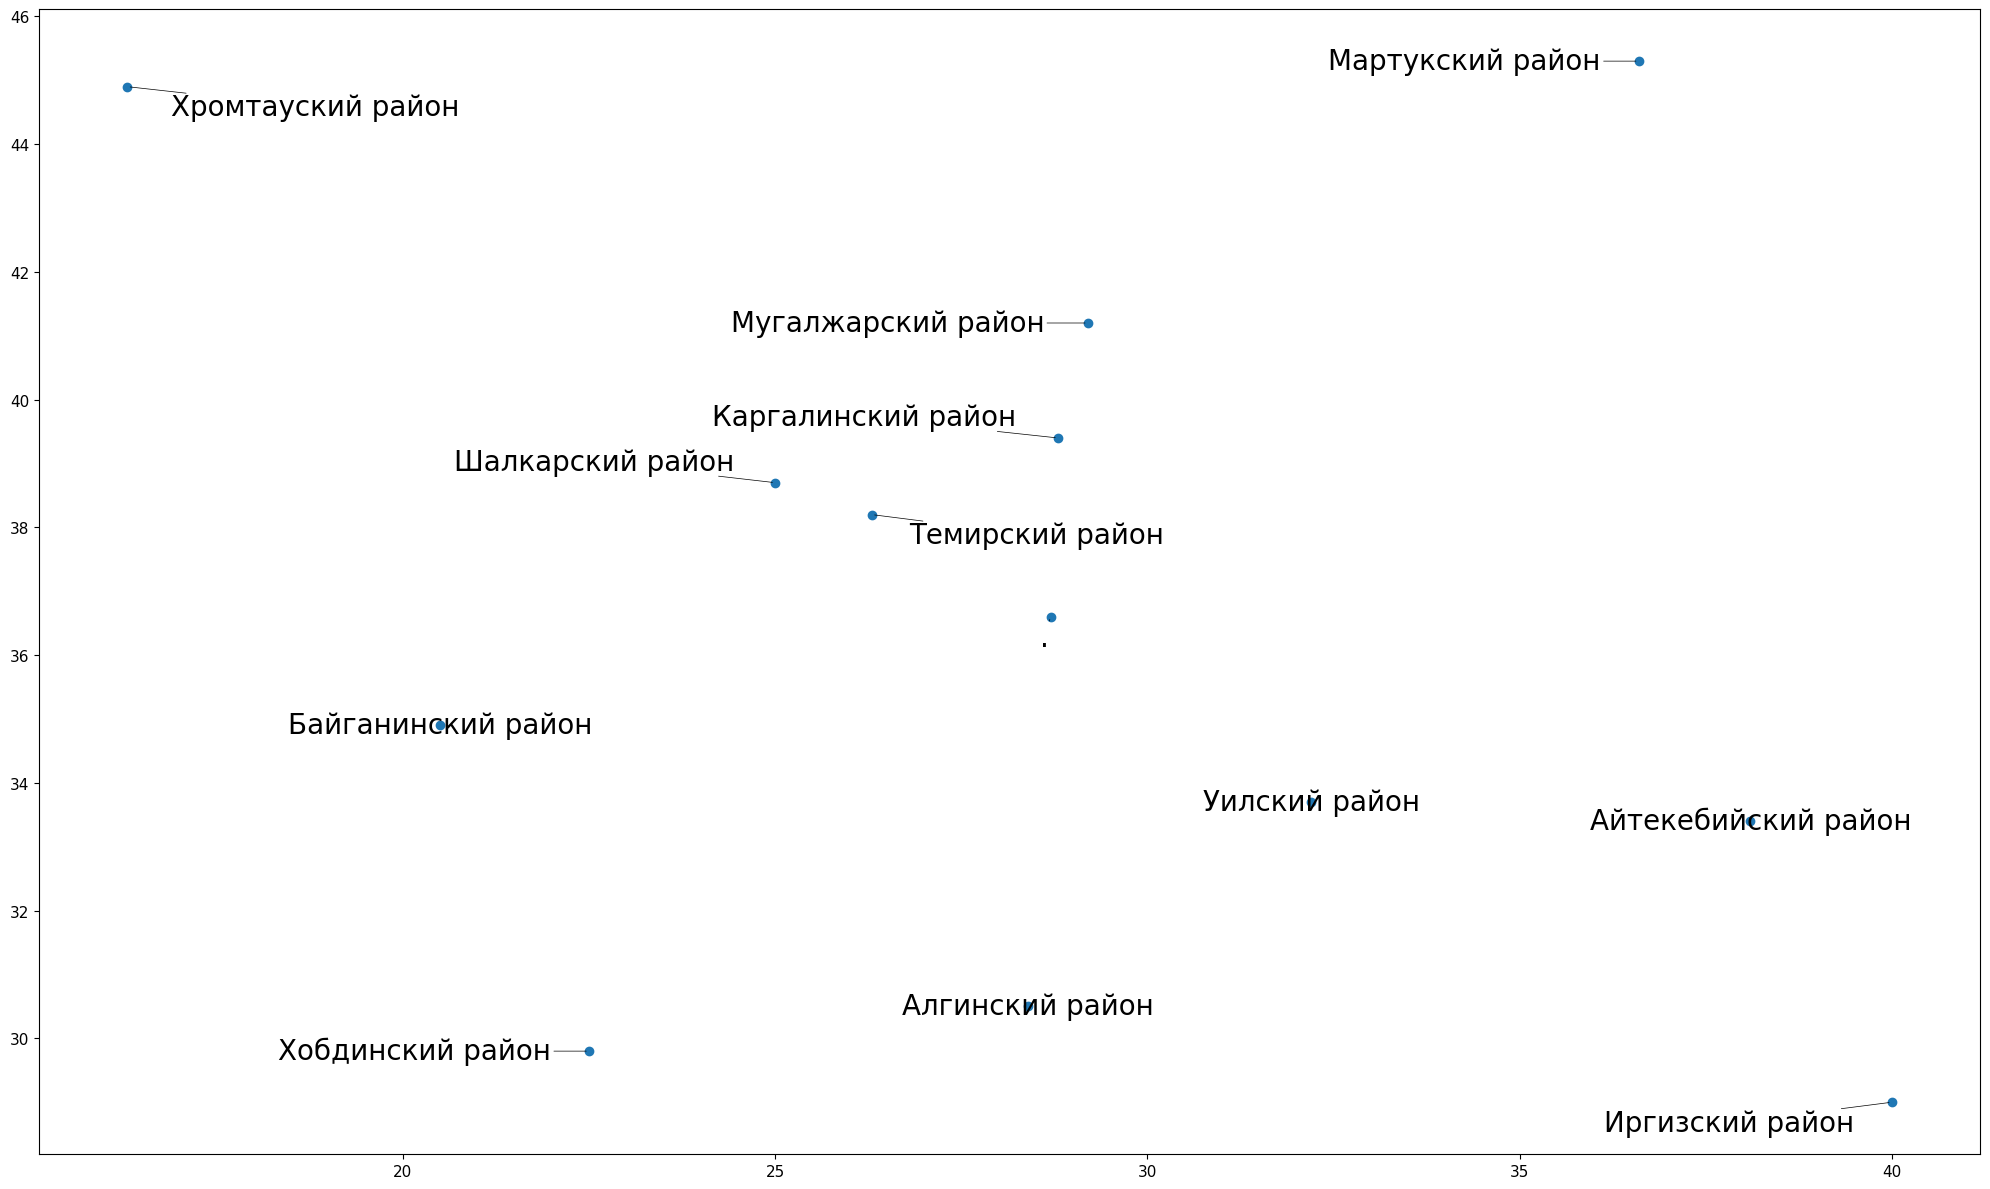

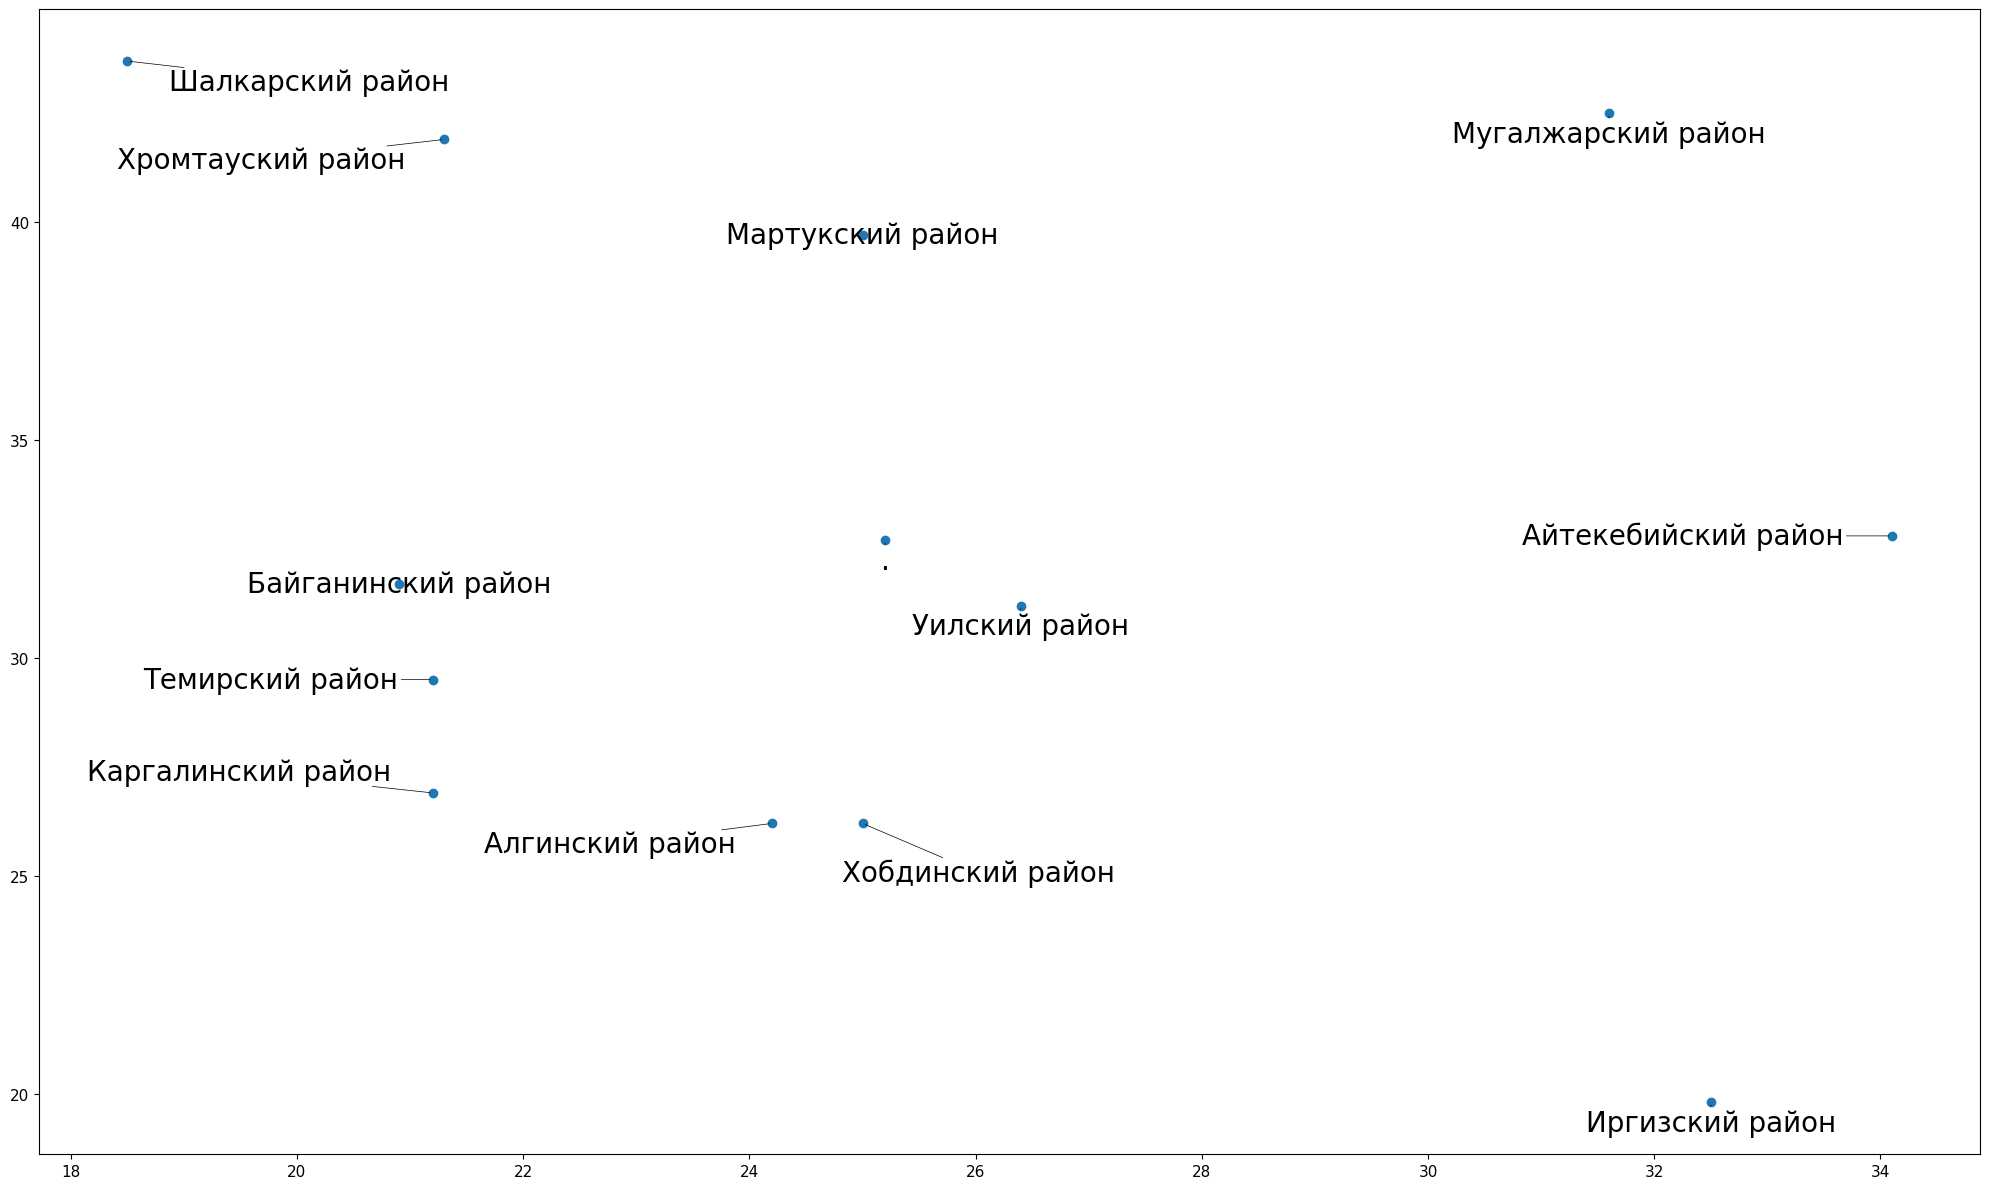

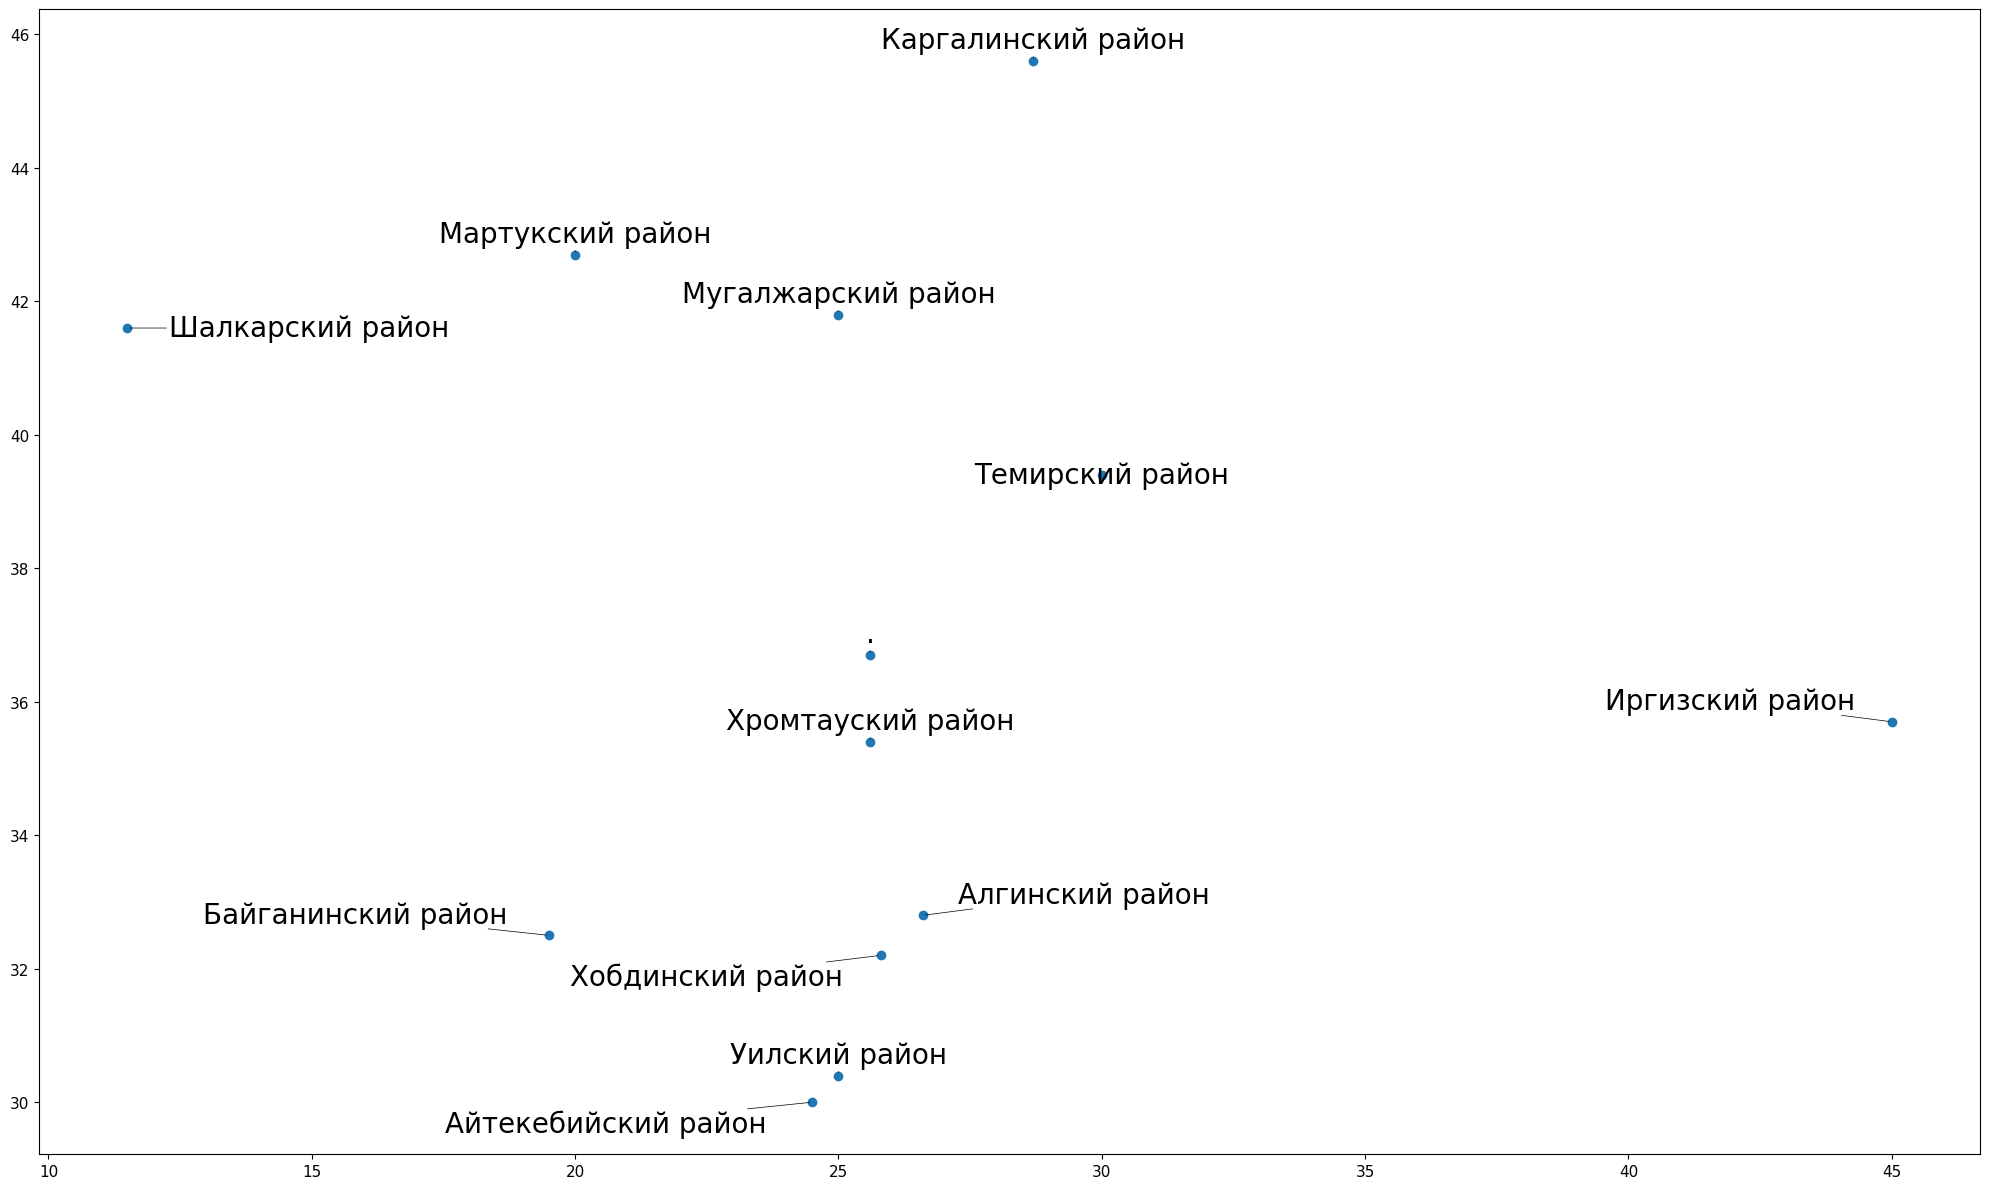

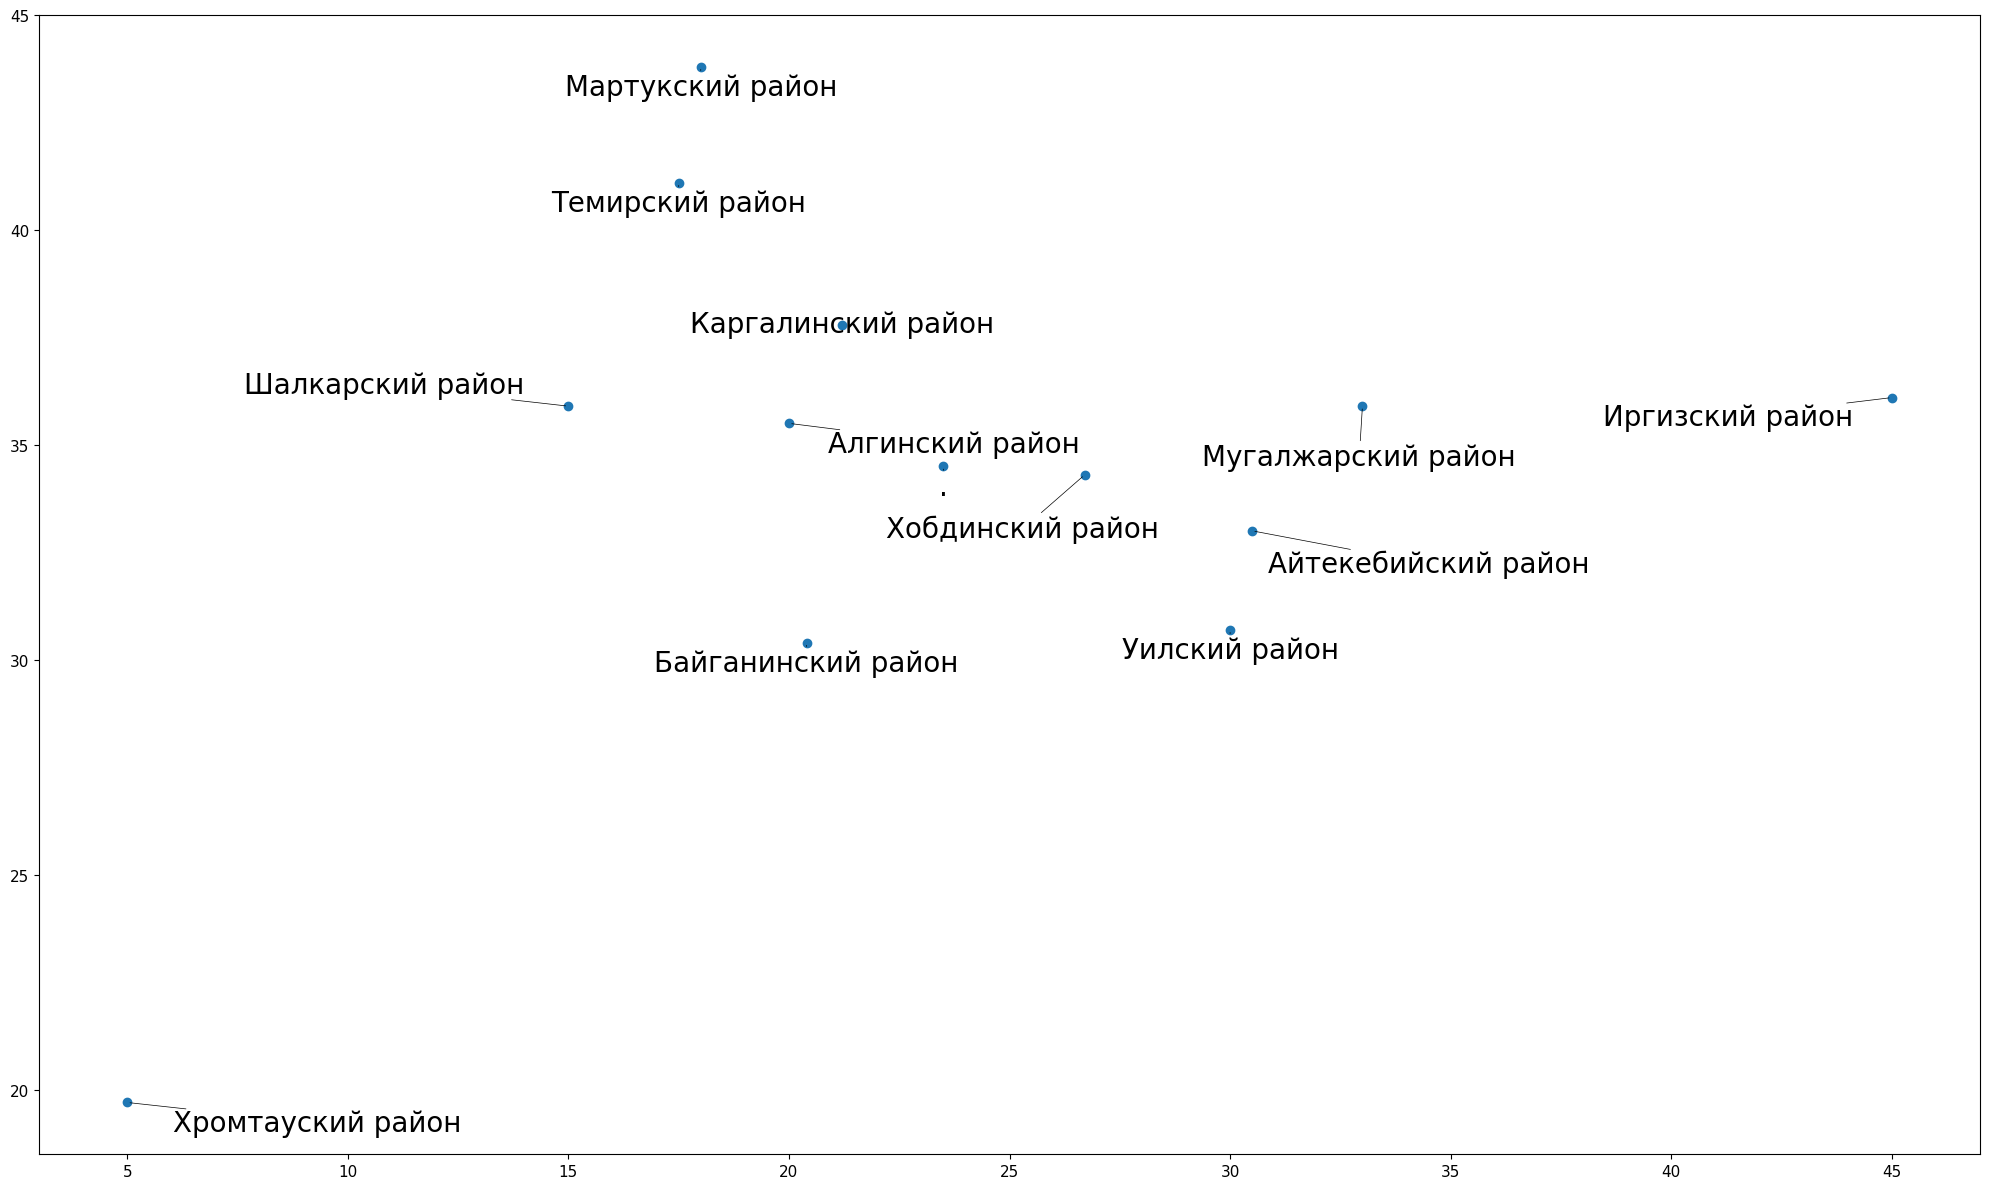

In [176]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

for grade, subs in seg_dict.items():
    for sub, data in subs.items():
        x = data['range']
        y = data['mean']
        region = data['region']
        
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.scatter(x, y)
        
        texts = []
        for xi, yi, region_label in zip(x, y, region):
            texts.append(ax.text(xi, yi, region_label, ha='left', va='bottom', fontsize=20))

        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5), autoalign=False)

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')

        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.grid(False)
        plt.tight_layout()
        # plt.savefig(rf"C:\Users\kassenov_r\report-automation\small_schools\segmentation\{grade}_{sub}.png")
        # plt.show()

Correlation matrix

In [54]:
# General correlation matrix
corr_dict = {}
for grade in grades:
    t = merged_df.loc[merged_df['grade'] == grade, ['subject', 'iin', 'percent']]
    pivot = t.pivot_table(index='iin', columns='subject', values='percent')
    corr = pivot.corr().round(1)
    corr = corr.reindex(columns=subject_order[grade], index=subject_order[grade])
    corr_dict[grade] = corr

# Saving the tables to xlsx
# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\corr_matrix.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, table in corr_dict.items():
#         table.to_excel(writer, sheet_name=f"{grade}")

In [55]:
langs = merged_df['lang'].unique()
corr_lang_dict = {}
for grade in grades:
    lang_dict = {}
    for lang in langs:
        t = merged_df.loc[(merged_df['grade'] == grade) & (merged_df['lang'] == lang), ['subject', 'iin', 'percent']]
        pivot = t.pivot_table(index='iin', columns='subject', values='percent')
        corr = pivot.corr().round(1)
        corr = corr.reindex(columns=subject_order[grade], index=subject_order[grade])
        lang_dict[lang] = corr
    corr_lang_dict[grade] = lang_dict

# Saving the tables to xlsx
# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\corr_lang_matrix1.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, langs in corr_lang_dict.items():
#         for lang, table in langs.items():
#             grade = str(grade)
#             table.to_excel(writer, sheet_name=f"{grade}_{lang}")

Inspection

In [118]:
merged_df.head(3)

,school,grade,subject,lang,lang_test,iin,answers,score,percent,1,...,12,13,14,15,16,17,18,19,20,region
0,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111031505028,01100000000101001010,6,30.0,0,...,1,0,1,0,0,1,0,1,0,Темирский район
1,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111225600781,00010000000001110009,4,20.0,0,...,0,0,1,1,1,0,0,0,0,Темирский район
2,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120105600946,10011011001001001000,8,40.0,1,...,0,0,1,0,0,1,0,0,0,Темирский район


In [117]:
inspection

,region,school,inspection,control_school
0,Айтекебийский район,КГУ «Общеобразовательная средняя школа имени А...,0,0
1,Айтекебийский район,КГУ «Баскудукская общеобразовательная средняя ...,0,0
2,Айтекебийский район,КГУ «Жабасакская общеобразовательная средняя ш...,1,0
3,Айтекебийский район,КГУ «Саратская общеобразовательная средняя школа»,0,0
4,Айтекебийский район,КГУ «Общеобразовательная Белкопинская средняя ...,0,0
...,...,...,...,...
136,Каргалинский район,"КГУ ""Кайрактинская основная школа - детский сад""",1,1
137,Мартукский район,КГУ «Бортинская общеобразовательная средняя шк...,1,1
138,Мартукский район,"КГУ ""Байторасайская общеобразовательная средня...",1,1
139,Хобдинский район,"КГУ ""Кобландинская основная школа""",1,1


In [106]:
cols = ['inspection', 'control_school']
for col in cols:
    inspection[col] = inspection[col].apply(lambda x: 1 if isinstance(x, str) else 0)

In [107]:
insp = inspection[(inspection['inspection'] != 0) | (inspection['control_school'] != 0)].groupby(['region', 'school'])[['inspection', 'control_school']].sum().reset_index()
print(f"Number of inspected schools: {len(insp)}")
display(insp)

Number of inspected schools: 24


,region,school,inspection,control_school
0,Айтекебийский район,КГУ «Жабасакская общеобразовательная средняя ш...,1,0
1,Айтекебийский район,КГУ «Общеобразовательная средняя школа имени Б...,1,1
2,Айтекебийский район,КГУ «Общеобразовательная средняя школа имени Ж...,1,0
3,Актобе город,"КГУ ""Белогорская основная школа""",1,0
4,Алгинский район,"КГУ ""Карахобдинская школа-детский сад""",1,0
5,Алгинский район,"КГУ ""Токмансайская средняя школа""",1,0
6,Байганинский район,"КГУ ""Средняя школа имени А.С.Пушкина""",1,0
7,Байганинский район,"КГУ ""Средняя школа имени Саги Жиенбаева""",1,0
8,Иргизский район,ГУ «Общеобразовательная средняя школа имени Б....,1,0
9,Иргизский район,"КГУ ""Общеобразовательная средняя школа имени Т...",1,0


In [109]:
merged_insp = pd.merge(merged_df, inspection, on=['school'], how='left')

In [113]:
merged_insp[merged_insp['region_y'].isna()]['school'].unique()

array(['КГУ "Общеобразовательная средняя школа имени Абая" отдел образования Темирского района',
       'КГУ «Общеобразовательная средняя школа имени Абая» отдел образования Айтекебийского района',
       'КГУ "Копинская средняя школа" отдел образования Хромтауского района',
       'КГУ "Копинская средняя школа" отдел образования Байганинского района'],
      dtype=object)

In [115]:
# insp_schools = insp['school'].unique()

# count = 0
# for school in merged_df['school'].unique():
#     if school in insp_schools:
#         count += 1
# print(count)

11


In [62]:
# merged_insp.fillna(0)

,school,grade,subject,lang,lang_test,iin,answers,score,percent,1,...,15,16,17,18,19,20,region_x,region_y,inspection,control_school
0,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111031505028,01100000000101001010,6,30.0,0,...,0,0,1,0,1,0,Темирский район,0,0.0,0.0
1,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,111225600781,00010000000001110009,4,20.0,0,...,1,1,0,0,0,0,Темирский район,0,0.0,0.0
2,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120105600946,10011011001001001000,8,40.0,1,...,0,0,1,0,0,0,Темирский район,0,0.0,0.0
3,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120113501733,01010001900010100110,7,35.0,0,...,1,0,0,1,1,0,Темирский район,0,0.0,0.0
4,"КГУ ""Общеобразовательная средняя школа имени А...",6,Естествознание и познание мира,Казахский,Казахский,120506500771,10111000000111010001,9,45.0,1,...,0,1,0,0,0,1,Темирский район,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12817,КГУ «Жабасакская общеобразовательная средняя ш...,10,Физика,Казахский,Казахский,081220553394,10000001100000000010,4,20.0,1,...,0,0,0,0,1,0,Айтекебийский район,Айтекебийский район,1.0,0.0
12818,"КГУ ""Кызылжарская средняя школа""",10,Физика,Казахский,Казахский,081222652036,10009001000009000000,2,10.0,1,...,0,0,0,0,0,0,Актобе Г.А.,Хобдинский район,0.0,0.0
12819,"КГУ ""Кызылжарская средняя школа""",10,Физика,Казахский,Казахский,081222652036,10009001000009000000,2,10.0,1,...,0,0,0,0,0,0,Хобдинский район,Хобдинский район,0.0,0.0
12820,"КГУ ""Калиновская средняя школа""",10,Физика,Казахский,Казахский,090520654389,10000000101000000001,4,20.0,1,...,0,0,0,0,0,1,Хобдинский район,Хобдинский район,1.0,0.0


In [63]:
merged_df[merged_df['school'].isin(insp_schools)]

,school,grade,subject,lang,lang_test,iin,answers,score,percent,1,...,12,13,14,15,16,17,18,19,20,region
418,"КГУ ""Токмансайская средняя школа""",8,Физика,Казахский,Казахский,090804652396,00000100000001000011,4,20.0,0,...,0,0,1,0,0,0,0,1,1,Алгинский район
437,"КГУ ""Токмансайская средняя школа""",6,Естествознание и познание мира,Казахский,Казахский,110209604188,10110000000100000000,4,20.0,1,...,1,0,0,0,0,0,0,0,0,Алгинский район
456,"КГУ ""Общеобразовательная средняя школа имени Т...",6,Естествознание и познание мира,Казахский,Казахский,110610503066,10010000101000110011,8,40.0,1,...,0,0,0,1,1,0,0,1,1,Иргизский район
457,"КГУ ""Общеобразовательная средняя школа имени Т...",6,Естествознание и познание мира,Казахский,Казахский,110610503066,10010000101000110011,8,40.0,1,...,0,0,0,1,1,0,0,1,1,Айтекебийский район
465,"КГУ ""Средняя школа имени Алии Молдагуловой""",6,Естествознание и познание мира,Казахский,Казахский,110622506096,11110001010100010011,10,50.0,1,...,1,0,0,0,1,0,0,1,1,Хобдинский район
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,КГУ «Общеобразовательная средняя школа имени Ы...,10,Физика,Казахский,Казахский,080930552383,11000100000011000100,6,30.0,1,...,0,1,1,0,0,0,1,0,0,Мугалжарский район
12760,"КГУ ""Общеобразовательная средняя школа имени Т...",10,Физика,Казахский,Казахский,081015653237,00001101000000000001,4,20.0,0,...,0,0,0,0,0,0,0,0,1,Иргизский район
12761,"КГУ ""Общеобразовательная средняя школа имени Т...",10,Физика,Казахский,Казахский,081015653237,00001101000000000001,4,20.0,0,...,0,0,0,0,0,0,0,0,1,Айтекебийский район
12767,"КГУ ""Саралжинская средняя школа имени А.Дербис...",10,Физика,Казахский,Казахский,081023652897,10011119001000000010,7,35.0,1,...,0,0,0,0,0,0,0,1,0,Уилский район


In [64]:
# for i, j in zip(merged_insp[merged_insp['school'].isin(insp_schools)]['region_x'], merged_insp[merged_insp['school'].isin(insp_schools)]['region_y']):
#     display(merged_df[(merged_df['school'].isin(insp_schools)) & (merged_insp['region_x'] != j)])

In [65]:
# ------------------------------------------------------------ #
inspected_schools = inspection[inspection['inspection'] == 1]['school']
control_schools = inspection[inspection['control_school'] == 1]['school']
# ------------------------------------------------------------ #

In [66]:
# Too liitle sample
merged_df[merged_df['school'].isin(inspected_schools)]['iin'].nunique()

687

Correlation matrix

In [67]:
langs = merged_df['lang'].unique()
subject_order = ['Математика', 'Естествознание и познание мира', 'Английский язык']

for grade in grades:
    t_grade = merged_df[merged_df['grade'] == grade]
    pivot_grade = t_grade.pivot_table(index='iin', columns='subject', values='percent')
    corr_grade = pivot_grade.corr().round(1).reindex(index=subject_order, columns=subject_order)
    print(grade)
    display(corr_grade)
    for lang in langs:
        t_lang = merged_df[(merged_df['grade'] == grade) & (merged_df['lang'] == lang)]
        pivot_lang = t_lang.pivot_table(index='iin', columns='subject', values='percent')
        corr_lang = pivot_lang.corr().round(1).reindex(index=subject_order, columns=subject_order)
        print(grade, lang)
        display(corr_lang)

6


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,0.4,0.5
Естествознание и познание мира,0.4,1.0,0.5
Английский язык,0.5,0.5,1.0


6 Казахский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,0.5,0.5
Естествознание и познание мира,0.5,1.0,0.5
Английский язык,0.5,0.5,1.0


6 Русский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,0.3,0.4
Естествознание и познание мира,0.3,1.0,0.5
Английский язык,0.4,0.5,1.0


8


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.5
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.5,NaN,1.0


8 Казахский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.5
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.5,NaN,1.0


8 Русский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.6
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.6,NaN,1.0


10


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.4
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.4,NaN,1.0


10 Казахский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.4
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.4,NaN,1.0


10 Русский


subject,Математика,Естествознание и познание мира,Английский язык
subject,,,
Математика,1.0,NaN,0.5
Естествознание и познание мира,NaN,NaN,NaN
Английский язык,0.5,NaN,1.0


In [68]:
langs = merged_df['lang'].unique()
for lang in langs:
    t = merged_df[merged_df['lang'] == lang]
    pivot = t.pivot_table(index='iin', columns='subject', values='percent')
    print(lang)
    display(pivot.corr())

Казахский


subject,Английский язык,Биология,Естествознание и познание мира,Математика,Физика,Химия
subject,,,,,,
Английский язык,1.000000,0.377475,0.473250,0.461546,0.375599,0.359108
Биология,0.377475,1.000000,NaN,0.397508,0.415205,0.560236
Естествознание и познание мира,0.473250,NaN,1.000000,0.459082,NaN,NaN
Математика,0.461546,0.397508,0.459082,1.000000,0.454641,0.385601
Физика,0.375599,0.415205,NaN,0.454641,1.000000,0.440868
Химия,0.359108,0.560236,NaN,0.385601,0.440868,1.000000


Русский


subject,Английский язык,Биология,Естествознание и познание мира,Математика,Физика,Химия
subject,,,,,,
Английский язык,1.000000,0.408521,0.526504,0.480061,0.591030,0.446707
Биология,0.408521,1.000000,NaN,0.497416,0.612067,0.651193
Естествознание и познание мира,0.526504,NaN,1.000000,0.349359,NaN,NaN
Математика,0.480061,0.497416,0.349359,1.000000,0.710281,0.502148
Физика,0.591030,0.612067,NaN,0.710281,1.000000,0.608791
Химия,0.446707,0.651193,NaN,0.502148,0.608791,1.000000


---

In [69]:
percent_dict = {}
for grade in grades:
    table = merged_df[merged_df['grade'] == grade]
    result_df = table.groupby('subject')['percent'].mean().round(1)
    percent_dict[grade] = result_df

# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\percent_subject.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, dataframe in percent_dict.items():
#         dataframe.to_excel(writer, sheet_name=grade)

In [70]:
percent_lang_dict = {}
for grade in grades:
    table = merged_df[merged_df['grade'] == grade]
    result_df = table.groupby(['subject', 'lang'])['percent'].mean().round(1)
    percent_lang_dict[grade] = result_df

# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\percent_subject_lang.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, dataframe in percent_lang_dict.items():
#         dataframe.to_excel(writer, sheet_name=grade)

Elements (waiting for elements)

In [71]:
elem_df = pd.read_excel(r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\Сельские школы\data\elements.xlsx")

elem_subject_map = {
    '8PHYS' : 'Физика', 
    '8BIOL' : 'Биология', 
    '8ENFL' : 'Английский язык', 
    '4SCIE' : 'Естествознание и познание мира', 
    '4MATH' : 'Математика', 
    '8MATH' : 'Математика', 
    '4RUFL' : 'Русский язык (Я1)',
    '8RUFL' : 'Русский язык (Я1)',
    '8RUSL' : 'Русский язык (Я2)', 
    '8CHEM' : 'Химия', 
    '4KZFL' : 'Казахский язык (Я1)', 
    '8KZFL' : 'Казахский язык (Я1)', 
    '8KZSL' : 'Казахский язык (Я2)'
}

elem_df['grade'] = elem_df['subject'].apply(lambda x: 8 if '8' in x else 4)
elem_df['subject'] = elem_df['subject'].map(elem_subject_map)

In [72]:
elem_melted = merged_df.melt(id_vars=['subject', 'iin'], value_vars=cols)

elem_percent_dict = {}

for grade in grades:
    subject_dict = {}
    for subject in subjects:
        table = merged_df[(merged_df['grade'] == grade) & (merged_df['subject'] == subject)]

        elem_melted = table.melt(id_vars=['subject', 'grade', 'iin'], value_vars=cols).rename(columns={'variable' : 'question', })
        elem_grouped = elem_melted.groupby(['subject', 'question', 'grade'])['value'].sum().reset_index().assign(percent = lambda x: x['value'] / 20 * 100).round(1)

        if len(elem_grouped) > 0:
            elem_grouped['percent'] = elem_grouped.apply(lambda x: x['value'] / elem_melted[elem_melted['subject'] == subject]['iin'].nunique() * 100, axis=1).round(1)
            elem_percent = elem_grouped.groupby(['subject', 'question'])['percent'].mean().round(1).reset_index().sort_values(by='percent', ascending=False)
            result_df = pd.merge(elem_percent, elem_df, on=['subject', 'question'])
            result_df = result_df[['question', 'element', 'percent']]
            result_df['question'] = range(1, len(result_df) + 1)
            subject_dict[subject] = result_df

    elem_percent_dict[grade] = subject_dict

KeyError: "The following 'value_vars' are not present in the DataFrame: ['control_school', 'inspection']"

In [ ]:
# file_path = r"C:\Users\kassenov_r\OneDrive - AEO NIS\Рабочий стол\Мониторинг\МКШ\excels\elem_percent_tables.xlsx"
# with pd.ExcelWriter(file_path) as writer:
#     for grade, subjects in elem_percent_dict.items():
#         for subject, table in subjects.items():
#             table.to_excel(writer, sheet_name=f"{grade}_{subject}", index=False)

{'6': {'Естествознание и познание мира':     question                                            element  percent
  0          1               Указывает верный промежуток времени.     75.2
  1          2                Объясняет основную цель вакцинации.     71.9
  2          3                          Называет низшие растения.     70.4
  3          4  Определяет последовательность развития растени...     67.0
  4          5  Указывает причину изменения направления воздух...     56.9
  5          6  Указывает тип взаимоотношений между птицей и к...     45.9
  6          7   Объясняет зависимость тени от размера преграды.      45.4
  7          8  Исследует и объяснять такие свойства света, ка...     44.8
  8          9  Исследует  теплопроводность различных материалов.     39.0
  9         10  Исследует  электропроводность различных матери...     37.9
  10        11  Исследует  растворимость различных веществ в в...     33.9
  11        12                Описывает жизненный цикл насеко